<a href="https://colab.research.google.com/github/erickcori/Delphi_CIA_XAI_WaterReuse/blob/main/PROF_EVANDRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Instalar dependencias (statsmodels, openpyxl)
!pip -q install statsmodels openpyxl

import warnings, io, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams["figure.dpi"] = 300  # 300 dpi en pantalla
plt.rcParams["savefig.dpi"] = 300 # 300 dpi al guardar
plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

os.makedirs("outputs", exist_ok=True)

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), 1e-9)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def month_diff(d_end, d_start):
    return (d_end.year - d_start.year) * 12 + (d_end.month - d_start.month)

print("Entorno listo.")

Entorno listo.


In [ ]:
# @title Subir archivo Excel (sube aquí `predição.xlsx`)
from google.colab import files

uploaded = files.upload()  # selecciona tu archivo .xlsx
fname = next(iter(uploaded))  # toma el primer archivo subido

raw = pd.read_excel(io.BytesIO(uploaded[fname]))
print("Columnas detectadas:", list(raw.columns))
raw.head()

Saving predição.xlsx to predição.xlsx
Columnas detectadas: ['Mês/Ano', 'Geração']


Mês/Ano       Geração
0 2003-01-01  39049.737742
1 2003-02-01  40936.205595
2 2003-03-01  39618.956183
3 2003-04-01  39842.030950
4 2003-05-01  38570.788575

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2003-01-01 to 2012-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   geracao  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB
None


geracao
mes_ano                 
2003-01-01  39049.737742
2003-02-01  40936.205595
2003-03-01  39618.956183
2003-04-01  39842.030950
2003-05-01  38570.788575

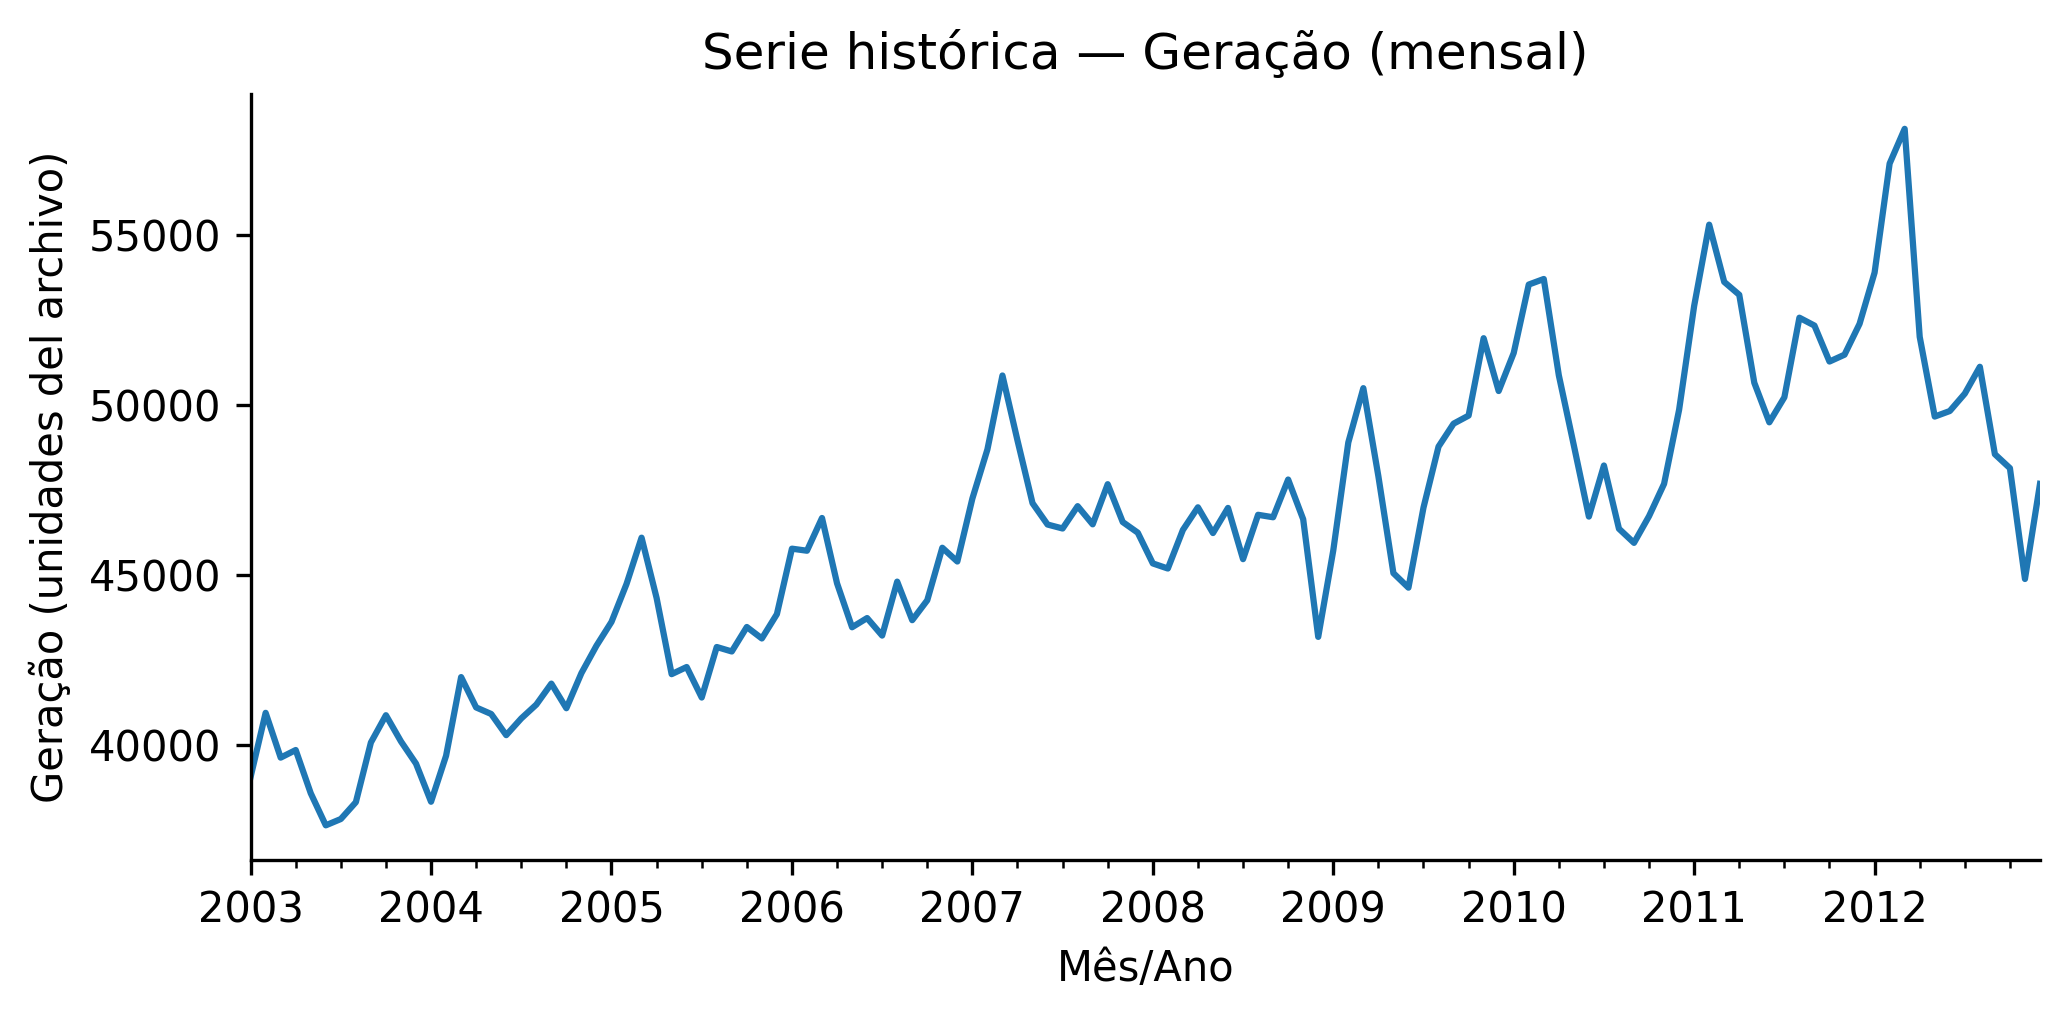

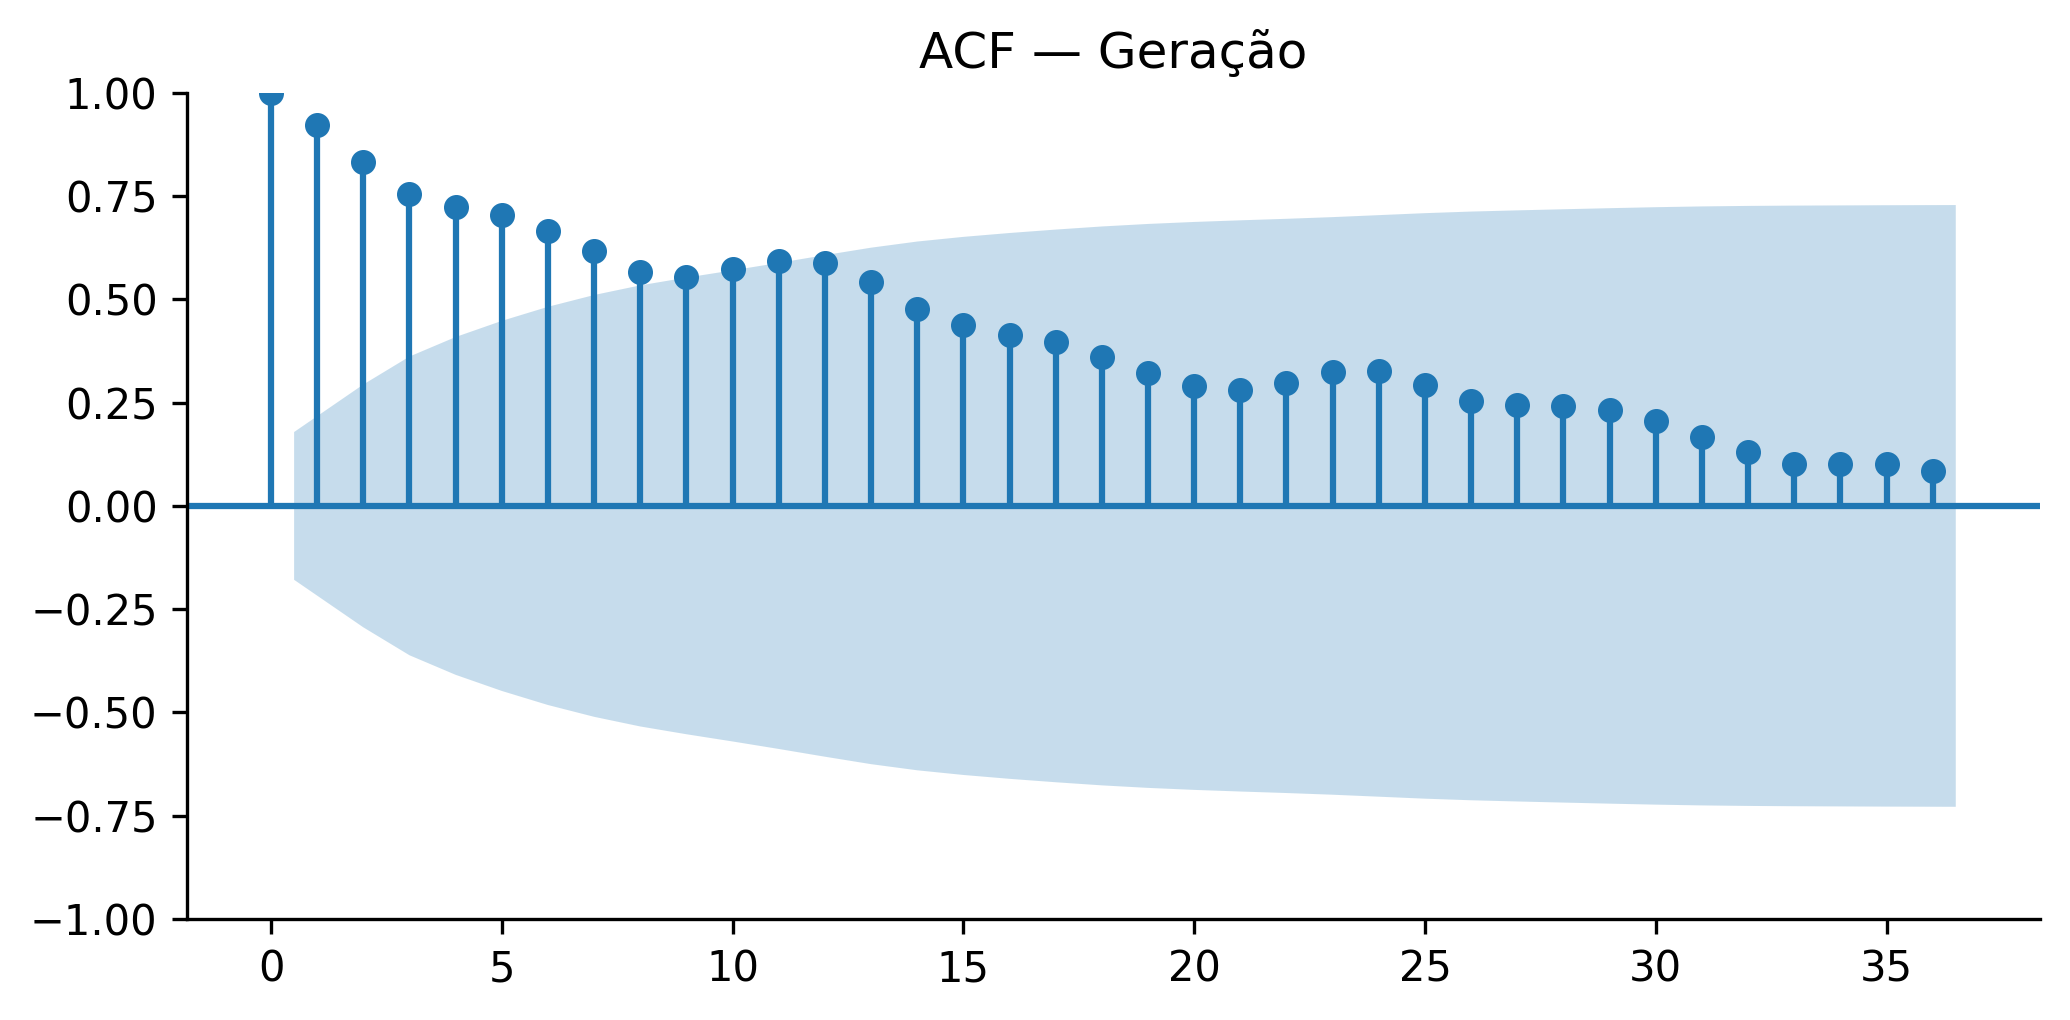

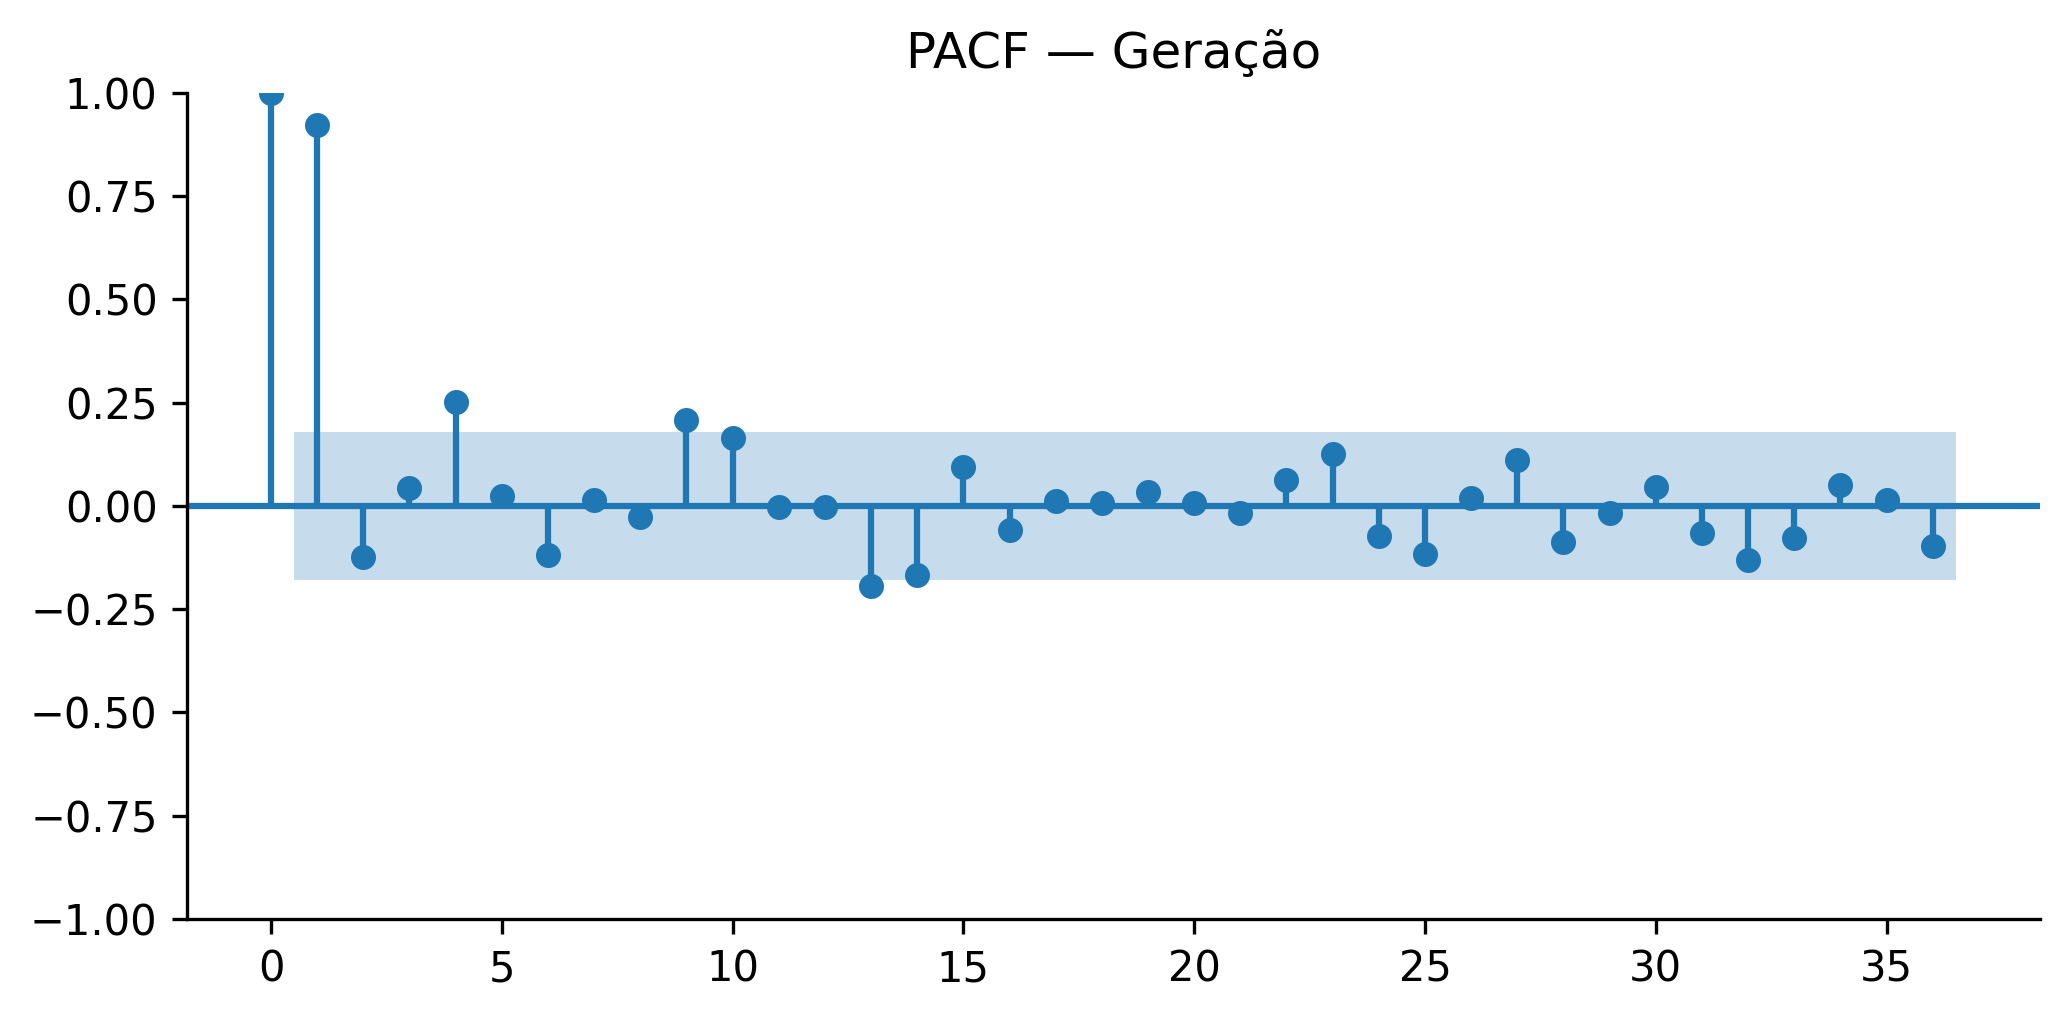

In [ ]:
# @title Limpieza y formateo a serie mensual
# Ajusta aquí los nombres si tu archivo difiere:
COL_FECHA = "Mês/Ano"
COL_VALOR = "Geração"

df = raw.rename(columns={COL_FECHA: "mes_ano", COL_VALOR: "geracao"}).copy()
df["mes_ano"] = pd.to_datetime(df["mes_ano"])
df = df.sort_values("mes_ano").drop_duplicates("mes_ano")
df = df.set_index("mes_ano").asfreq("MS")  # índice mensual 'Month Start'
df["geracao"] = pd.to_numeric(df["geracao"], errors="coerce")
df = df.dropna(subset=["geracao"])  # descarta huecos tras coerción si existieran

print(df.info())
display(df.head())

# Gráfico histórico
ax = df["geracao"].plot()
ax.set_title("Serie histórica — Geração (mensal)")
ax.set_xlabel("Mês/Ano"); ax.set_ylabel("Geração (unidades del archivo)")
plt.tight_layout()
plt.savefig("outputs/00_historico.png")
plt.show()

# ACF/PACF de la serie (opcional, informativo)
fig = plt.figure(figsize=(7,3.5))
plot_acf(df["geracao"], ax=plt.gca(), lags=36)
plt.title("ACF — Geração")
plt.tight_layout(); plt.savefig("outputs/01_acf.png"); plt.show()

fig = plt.figure(figsize=(7,3.5))
plot_pacf(df["geracao"], ax=plt.gca(), lags=36, method="ywm")
plt.title("PACF — Geração")
plt.tight_layout(); plt.savefig("outputs/02_pacf.png"); plt.show()

In [ ]:
# @title Backtesting SARIMA: grilla y selección por MAE/MAPE
y = df["geracao"].astype(float).copy()
season_length = 12

# Configuración de backtest
n_folds = 3
fh = 12  # horizonte de cada fold (12 meses)

# Punto desde el que comienzan los folds (últimos n_folds*fh meses se usan como tests)
start_train_end_idx = len(y) - n_folds * fh
assert start_train_end_idx > season_length * 2, "Muy pocos datos para backtesting."

def folds_indices(y, fh=12, n_folds=3):
    """Genera índices (train_slice, test_slice) para 3 folds de 12 meses consecutivos."""
    start = len(y) - n_folds * fh
    for i in range(n_folds):
        train_end = start + i * fh
        test_end = train_end + fh
        yield slice(0, train_end), slice(train_end, test_end)

# Grilla rápida (puedes ampliar p,q y P,Q a [0,1,2] si tienes más tiempo)
p_grid = [0, 1, 2]
d_grid = [0, 1]
q_grid = [0, 1, 2]
P_grid = [0, 1]
D_grid = [0, 1]
Q_grid = [0, 1]

results = []
total_trials = len(p_grid)*len(d_grid)*len(q_grid)*len(P_grid)*len(D_grid)*len(Q_grid)
print(f"Probando hasta {total_trials} combinaciones...")

trial = 0
for p in p_grid:
    for d in d_grid:
        for q in q_grid:
            for P in P_grid:
                for D in D_grid:
                    for Q in Q_grid:
                        trial += 1
                        order = (p, d, q)
                        seasonal_order = (P, D, Q, season_length)
                        maes, mapes = [], []
                        feasible = True
                        try:
                            for tr_idx, te_idx in folds_indices(y, fh=fh, n_folds=n_folds):
                                y_tr = y.iloc[tr_idx]
                                y_te = y.iloc[te_idx]

                                # Ajuste y predicción multi-paso para el bloque de test
                                model = SARIMAX(
                                    y_tr, order=order, seasonal_order=seasonal_order,
                                    enforce_stationarity=False, enforce_invertibility=False
                                )
                                res = model.fit(disp=False)
                                pred = res.get_prediction(start=y_te.index[0], end=y_te.index[-1], dynamic=False)
                                y_hat = pred.predicted_mean

                                maes.append(np.mean(np.abs(y_te.values - y_hat.values)))
                                mapes.append(mape(y_te.values, y_hat.values))
                        except Exception as e:
                            feasible = False

                        if feasible and len(maes) == n_folds:
                            results.append({
                                "order": order,
                                "seasonal_order": seasonal_order,
                                "MAE": np.mean(maes),
                                "MAPE": np.mean(mapes)
                            })

# Selección del mejor
res_df = pd.DataFrame(results).sort_values(by=["MAE","MAPE"]).reset_index(drop=True)
print(f"Combinaciones viables: {len(res_df)}")
display(res_df.head(10))

best = res_df.iloc[0]
best_order = tuple(best["order"])
best_seasonal = tuple(best["seasonal_order"])
print("Mejor combinación:")
print(" order =", best_order, "| seasonal_order =", best_seasonal,
      f'| CV_MAE={best["MAE"]:.1f} | CV_MAPE={best["MAPE"]:.2f}%')

res_df.to_csv("outputs/03_cv_results.csv", index=False)

Probando hasta 144 combinaciones...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Combinaciones viables: 144


order seasonal_order          MAE      MAPE
0  (2, 0, 2)  (1, 1, 1, 12)  1943.992803  3.904196
1  (1, 0, 2)  (1, 1, 1, 12)  1976.535820  3.964215
2  (2, 1, 1)  (0, 1, 1, 12)  1986.985620  4.041186
3  (2, 0, 0)  (1, 1, 0, 12)  2029.751093  4.063674
4  (2, 0, 1)  (1, 1, 0, 12)  2035.367024  4.064758
5  (1, 1, 1)  (0, 1, 1, 12)  2037.526720  4.132118
6  (1, 0, 1)  (1, 1, 0, 12)  2047.632924  4.104095
7  (1, 0, 1)  (1, 1, 1, 12)  2049.212116  4.129117
8  (1, 0, 0)  (1, 1, 0, 12)  2057.298168  4.122982
9  (2, 0, 2)  (1, 1, 0, 12)  2064.651101  4.123859

Mejor combinación:
 order = (2, 0, 2) | seasonal_order = (1, 1, 1, 12) | CV_MAE=1944.0 | CV_MAPE=3.90%


In [ ]:
# @title Diagnóstico profesional de residuales (300 dpi) + tests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# Asegura que existen y,yhat y final_model en el entorno (Celda 5)
assert 'final_model' in globals(), "final_model no existe; ejecuta antes la Celda 5."
assert 'y' in globals(), "Serie histórica 'y' no encontrada; ejecuta antes la Celda 3."

# (Opcional) Si tu mejor fit dio ConvergenceWarning, reintenta con más iteraciones/otro solver:
# final_model = SARIMAX(
#     y, order=best_order, seasonal_order=best_seasonal,
#     enforce_stationarity=False, enforce_invertibility=False
# ).fit(disp=False, maxiter=500, method='lbfgs')

# ========================
# 1) Métricas y resumen
# ========================
print(f"Modelo final: SARIMA {best_order} x {best_seasonal}")
print(f"AIC = {final_model.aic:.1f} | BIC = {final_model.bic:.1f}")

resid = final_model.resid.dropna()
sigma = resid.std(ddof=1)
z = resid / (sigma if sigma > 0 else 1.0)

# ========================
# 2) Gráficos de diagnóstico
# ========================

# (a) Serie de residuales estandarizados
fig, ax = plt.subplots()
ax.plot(z, lw=1)
ax.axhline(0, color="k", lw=1)
ax.set_title("Residuales estandarizados")
ax.set_xlabel("Mês/Ano"); ax.set_ylabel("z-residual")
plt.tight_layout(); plt.savefig("outputs/05_residuos_estandarizados.png"); plt.show()

# (b) ACF de residuales
fig = plt.figure(figsize=(7, 3.5))
plot_acf(z, lags=36, ax=plt.gca())
plt.title("ACF de residuales estandarizados")
plt.tight_layout(); plt.savefig("outputs/06_residuos_acf.png"); plt.show()

# (c) QQ-plot (normalidad)
fig = qqplot(z, line='s')
plt.title("QQ-plot de residuales estandarizados")
plt.tight_layout(); plt.savefig("outputs/07_residuos_qq.png"); plt.show()

# (d) Histograma simple
fig, ax = plt.subplots()
ax.hist(z, bins=24, alpha=0.85)
ax.set_title("Histograma de residuales estandarizados")
ax.set_xlabel("z"); ax.set_ylabel("Frecuencia")
plt.tight_layout(); plt.savefig("outputs/08_residuos_hist.png"); plt.show()

# (e) Escala-localización: ajuste vs. |z|
fitted = final_model.fittedvalues.reindex(y.index)
common = resid.index.intersection(fitted.index)
abs_z = z.reindex(common).abs()
fit_common = fitted.reindex(common)

fig, ax = plt.subplots()
ax.scatter(fit_common, abs_z, s=12, alpha=0.6)
ax.set_title("Escala–localización (|z| vs. ajustado)")
ax.set_xlabel("Valor ajustado"); ax.set_ylabel("|z-residual|")
plt.tight_layout(); plt.savefig("outputs/09_scale_location.png"); plt.show()

# ========================
# 3) Tests formales
# ========================

# Ljung–Box (no autocorrelación de residuales)
lb = acorr_ljungbox(resid, lags=[12, 24, 36], return_df=True)
print("\nLjung–Box p-values (p>0.05 ⇒ no autocorrelación):")
display(lb)

# Jarque–Bera (normalidad)
jb_stat, jb_p, skew, kurt = jarque_bera(resid)
print(f"\nJarque–Bera: stat={jb_stat:.2f}, p={jb_p:.4f} (p>0.05 ⇒ normalidad plausible)")
print(f"Sesgo={skew:.2f}, Curtosis={kurt:.2f}")

# ARCH LM (heterocedasticidad)
arch_stat, arch_p, _, _ = het_arch(resid)
print(f"\nARCH LM: stat={arch_stat:.2f}, p={arch_p:.4f} (p>0.05 ⇒ varianza constante)")

# Guardar resultados
lb.to_csv("outputs/10_ljungbox.csv", index=False)
pd.DataFrame({
    "JB_stat":[jb_stat], "JB_p":[jb_p], "skew":[skew], "kurt":[kurt],
    "ARCH_stat":[arch_stat], "ARCH_p":[arch_p],
    "AIC":[final_model.aic], "BIC":[final_model.bic],
    "order":[str(best_order)], "seasonal_order":[str(best_seasonal)]
}).to_csv("outputs/11_diag_resumen.csv", index=False)

print("\nDiagnósticos guardados en outputs/:")
print("- 05_residuos_estandarizados.png")
print("- 06_residuos_acf.png")
print("- 07_residuos_qq.png")
print("- 08_residuos_hist.png")
print("- 09_scale_location.png")
print("- 10_ljungbox.csv")
print("- 11_diag_resumen.csv")

AssertionError: final_model no existe; ejecuta antes la Celda 5.

In [ ]:
# @title Celda 5-bis — Reentreno rápido del modelo final si falta
import numpy as np, pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) Asegura la serie y
if 'y' not in globals():
    assert 'df' in globals(), "No encuentro df; ejecuta la Celda 3 (limpieza y EDA) primero."
    y = df['geracao'].astype(float).copy()

# 2) Usa el mejor orden encontrado en tu backtest (puedes cambiarlo si luego pruebas otros)
if 'best_order' not in globals():
    best_order = (2, 0, 2)
if 'best_seasonal' not in globals():
    best_seasonal = (1, 1, 1, 12)

# 3) Ajuste final (más iteraciones y solver robusto)
final_model = SARIMAX(
    y, order=best_order, seasonal_order=best_seasonal,
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False, maxiter=500, method='lbfgs')

print("Modelo final listo:", best_order, "x", best_seasonal)
print(f"AIC={final_model.aic:.1f} | BIC={final_model.bic:.1f}")

Modelo final listo: (2, 0, 2) x (1, 1, 1, 12)
AIC=1634.1 | BIC=1651.9


Modelo final: SARIMA (2, 0, 2) x (1, 1, 1, 12)
AIC = 1634.1 | BIC = 1651.9


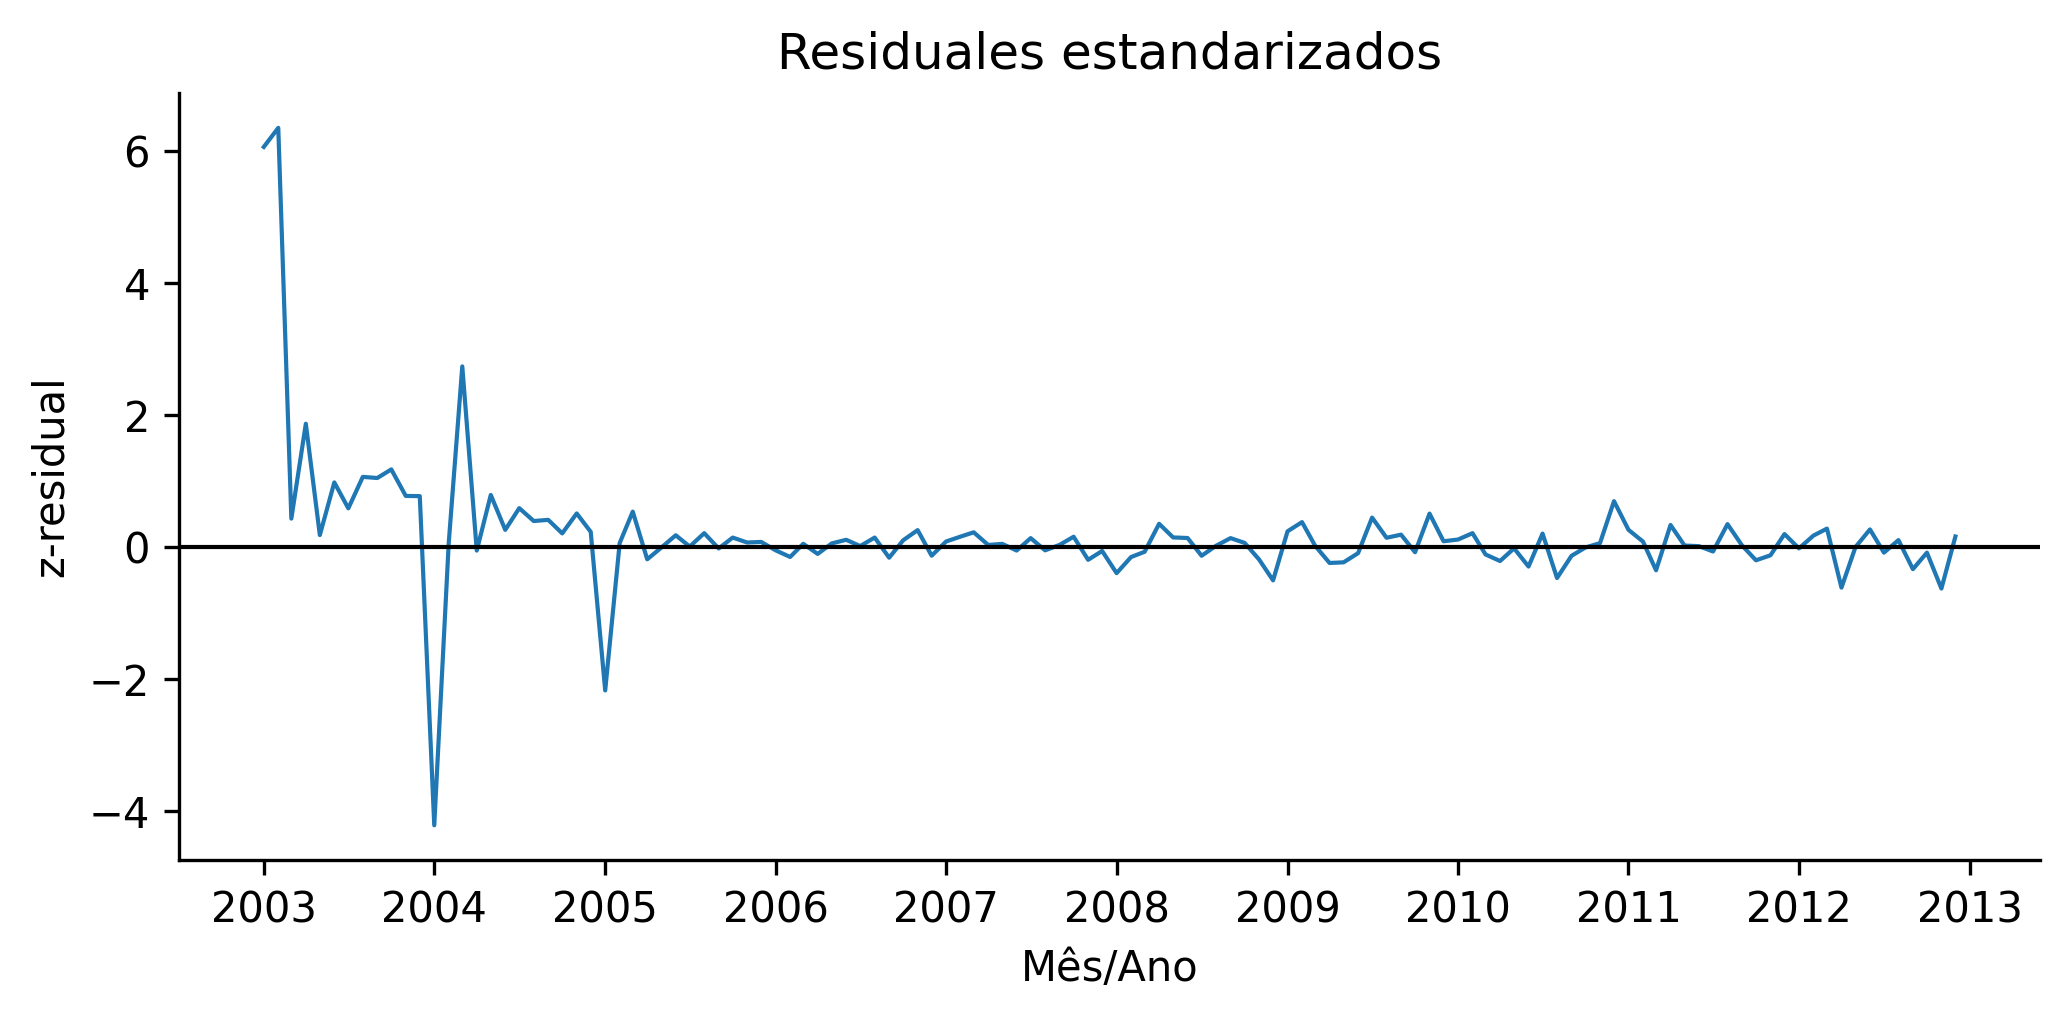

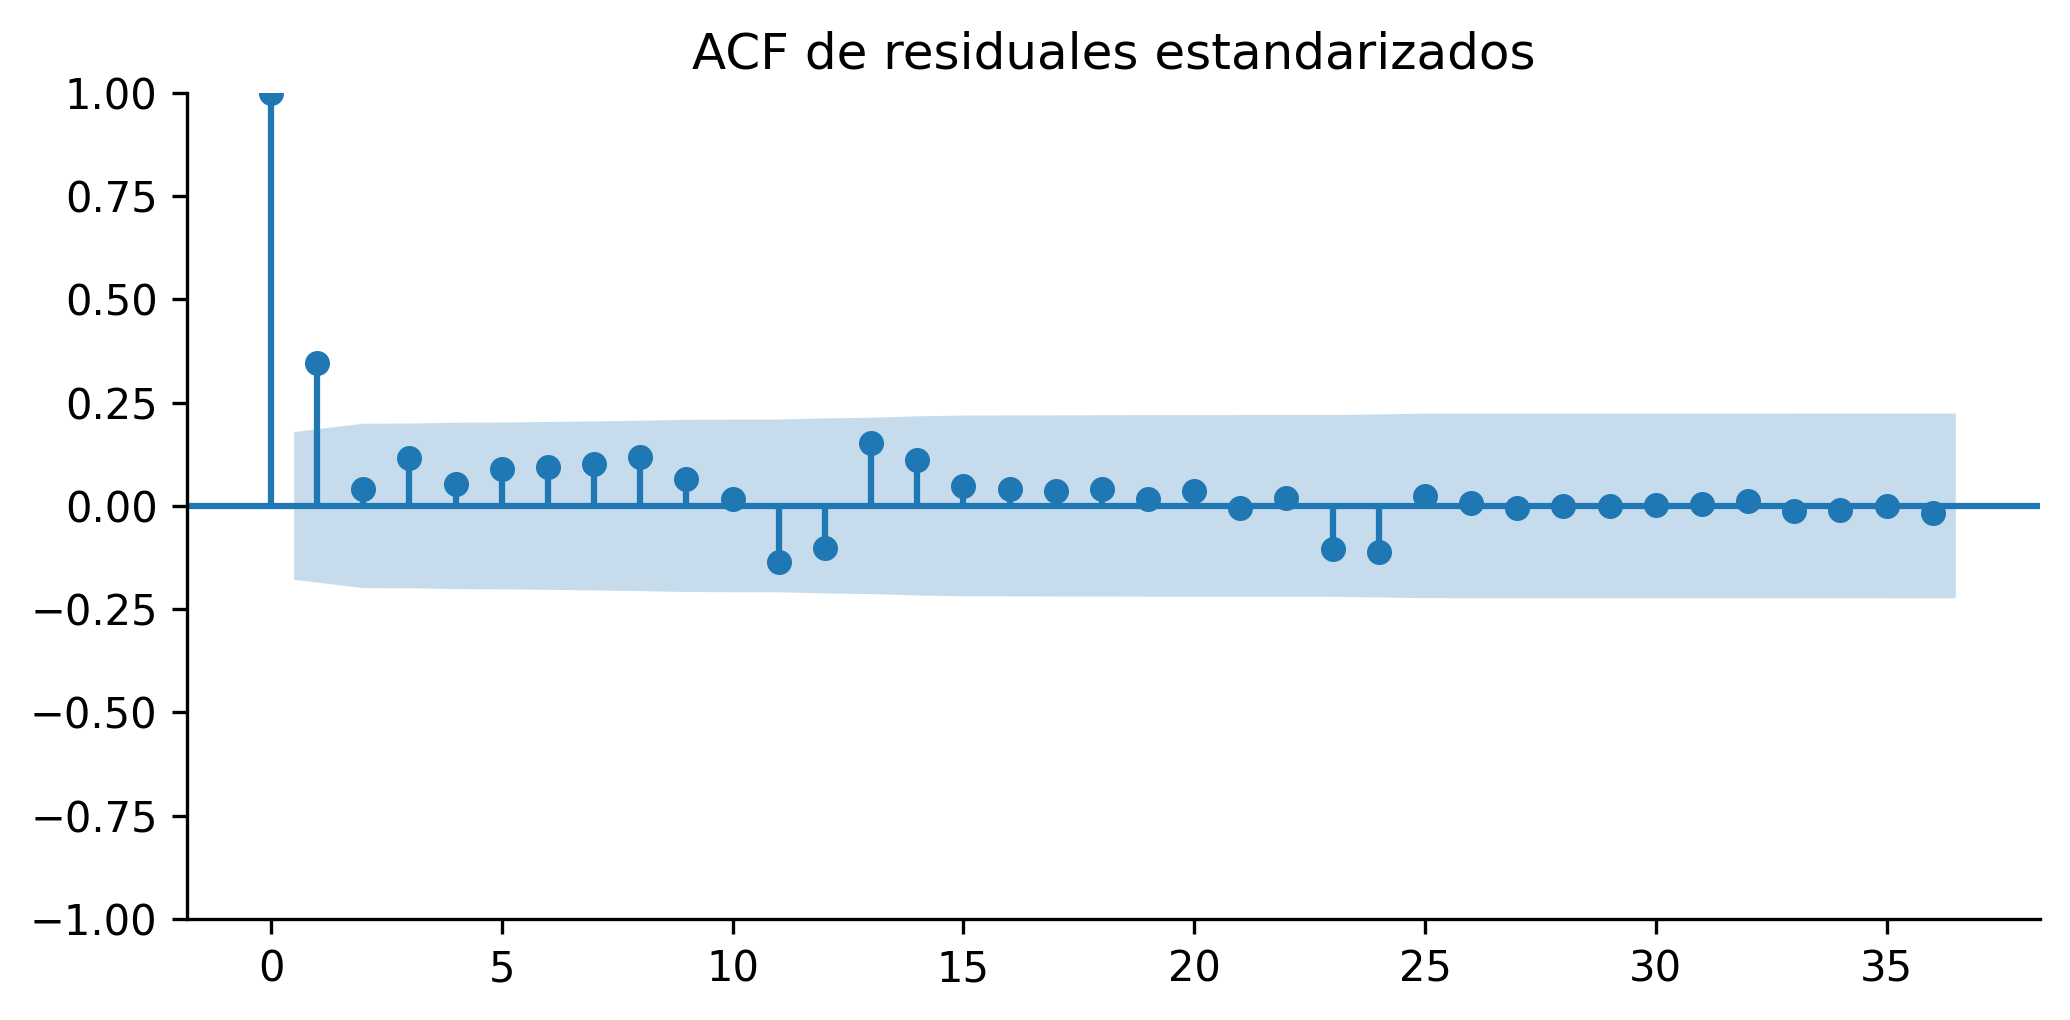

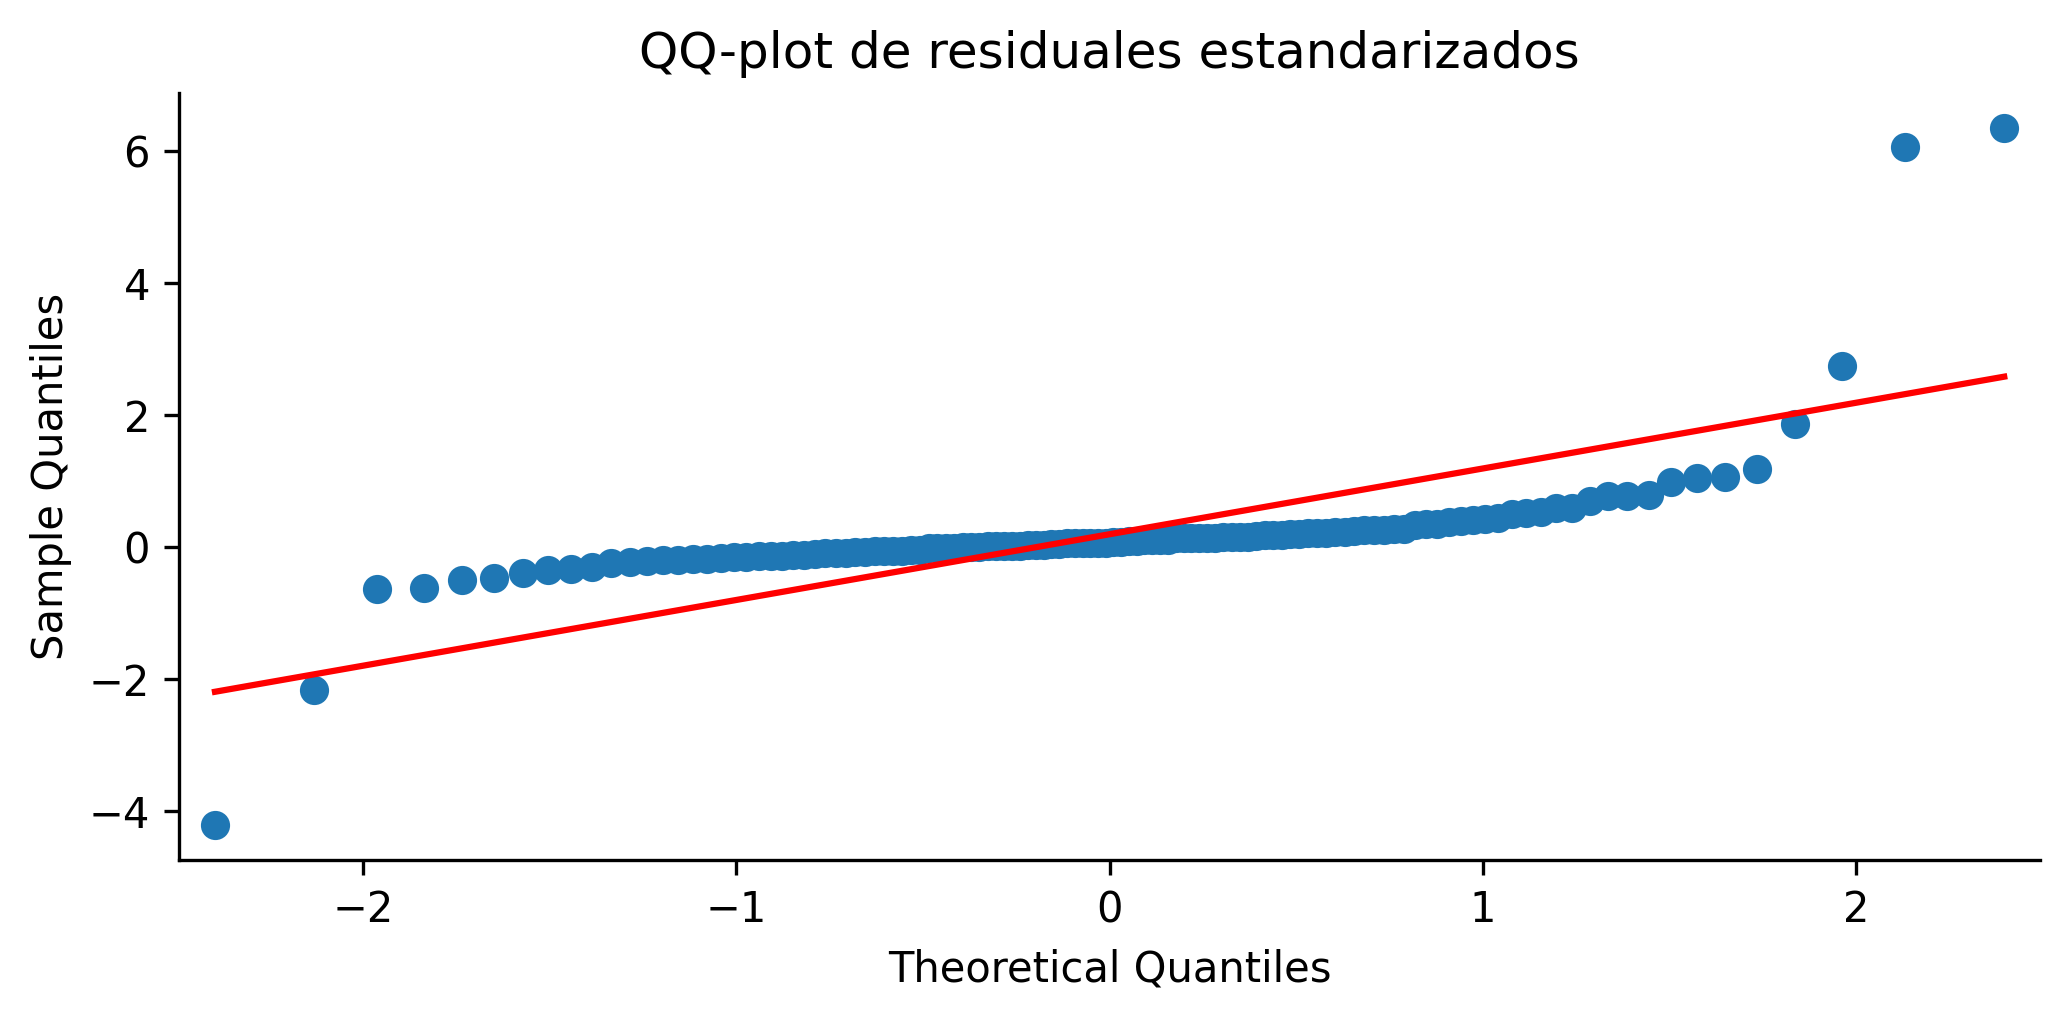

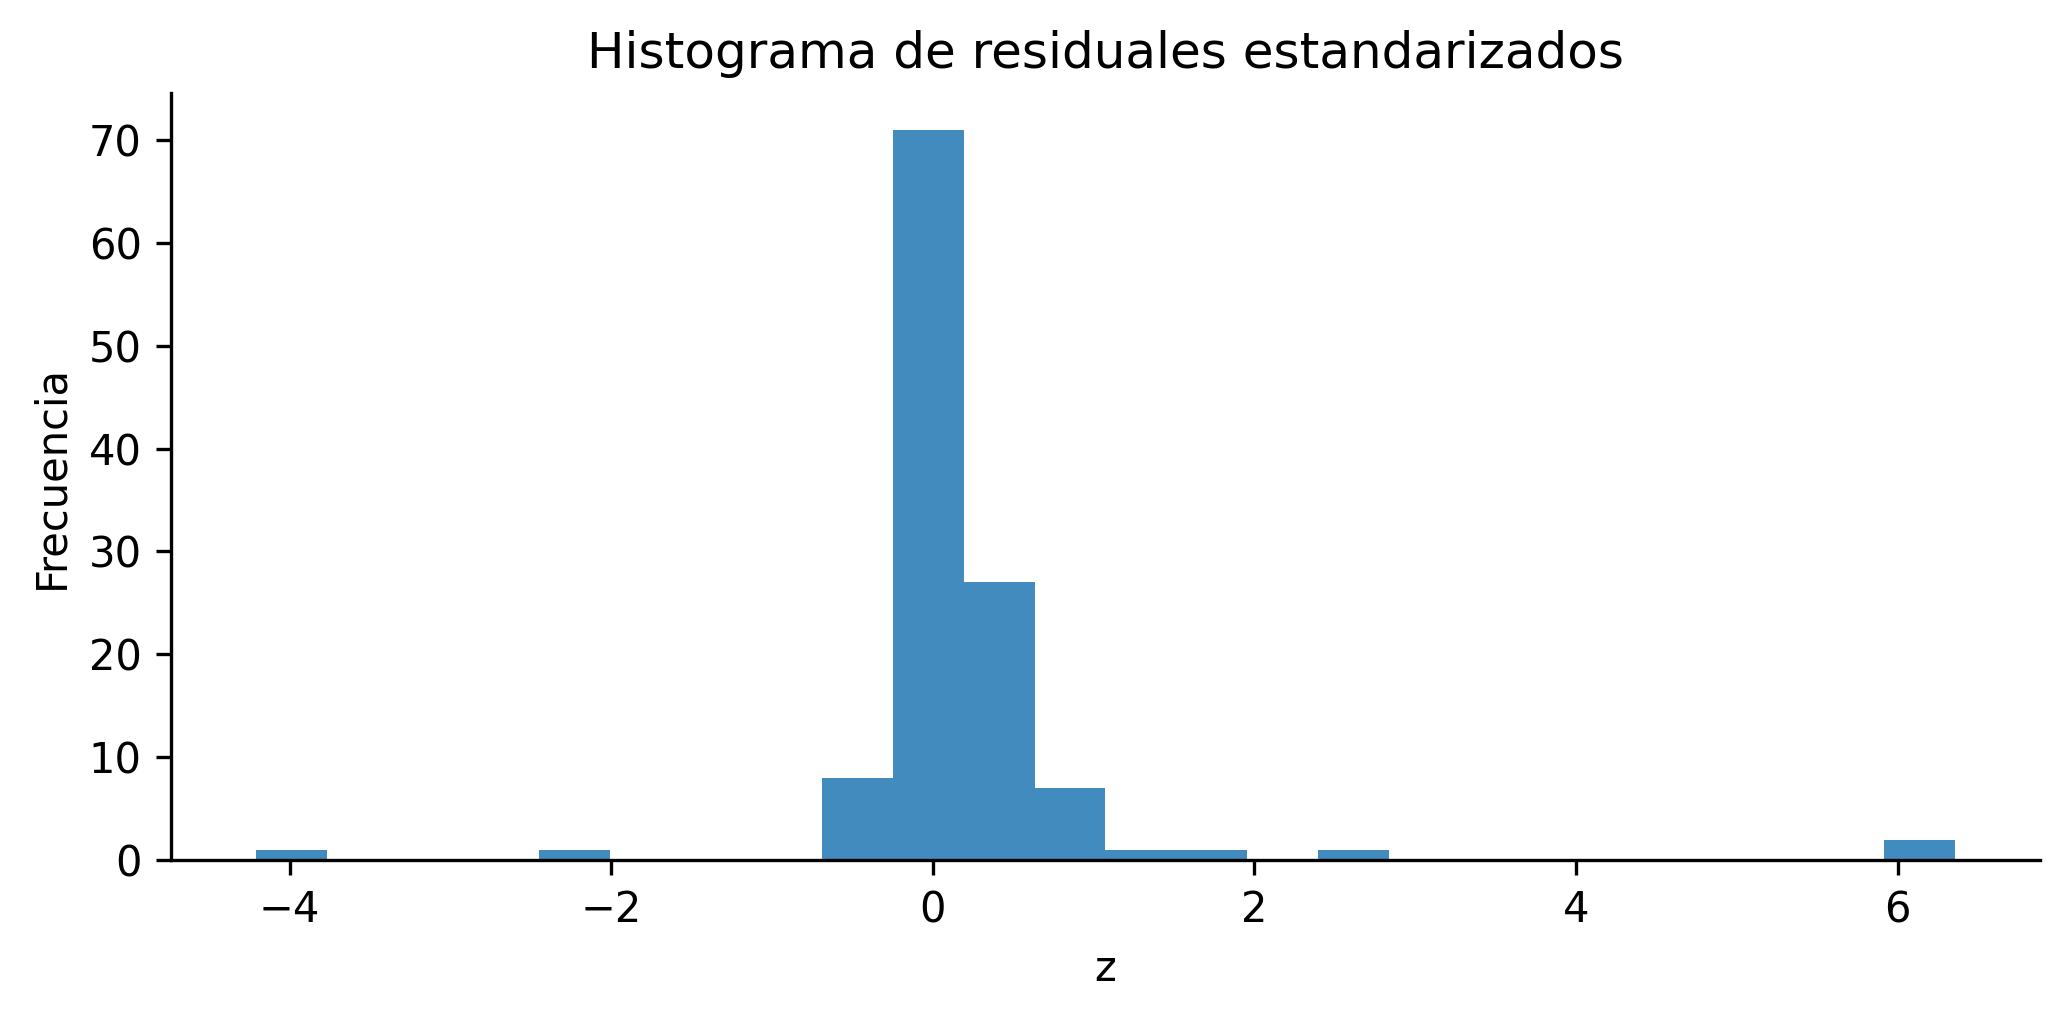

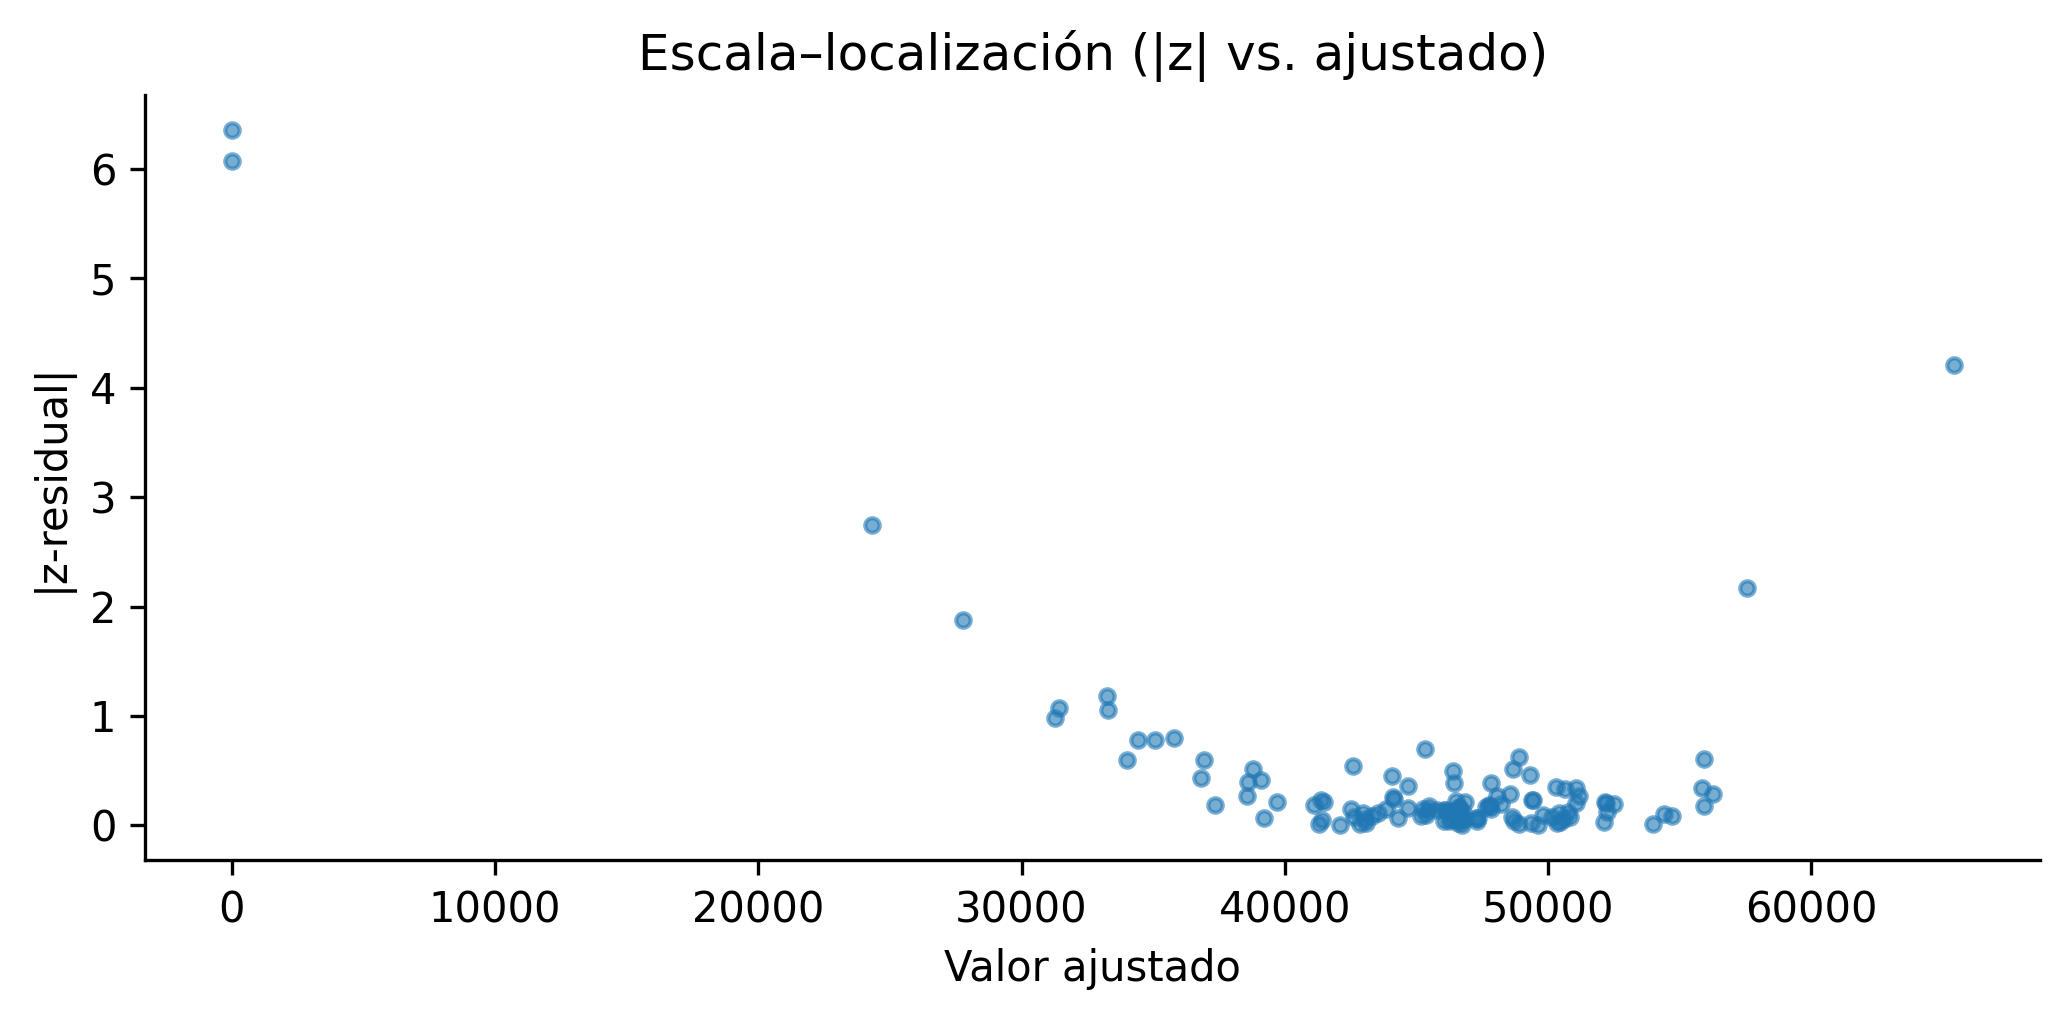


Ljung–Box p-values (p>0.05 ⇒ no autocorrelación):


lb_stat  lb_pvalue
12  26.772307   0.008332
24  36.475473   0.049321
36  36.698049   0.436329


Jarque–Bera: stat=2861.07, p=0.0000 (p>0.05 ⇒ normalidad plausible)
Sesgo=3.02, Curtosis=26.15

ARCH LM: stat=16.05, p=0.0983 (p>0.05 ⇒ varianza constante)

Diagnósticos guardados en outputs/:
- 05_residuos_estandarizados.png
- 06_residuos_acf.png
- 07_residuos_qq.png
- 08_residuos_hist.png
- 09_scale_location.png
- 10_ljungbox.csv
- 11_diag_resumen.csv


In [ ]:
# @title Diagnóstico profesional de residuales (300 dpi) + tests (autocontenida)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# --- Autocuración mínima ---
if 'y' not in globals():
    assert 'df' in globals(), "No encuentro df; ejecuta la Celda 3 (limpieza y EDA) primero."
    y = df['geracao'].astype(float).copy()

if 'final_model' not in globals():
    # Si no hay modelo en memoria, reentrena con tu mejor combinación
    best_order = (2, 0, 2)
    best_seasonal = (1, 1, 1, 12)
    final_model = SARIMAX(
        y, order=best_order, seasonal_order=best_seasonal,
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False, maxiter=500, method='lbfgs')

# En caso de que best_order/best_seasonal no existan, los tomamos del objeto
order_from_model = getattr(final_model.model, "order", None)
seasonal_from_model = getattr(final_model.model, "seasonal_order", None)
if 'best_order' not in globals() and order_from_model is not None:
    best_order = order_from_model
if 'best_seasonal' not in globals() and seasonal_from_model is not None:
    best_seasonal = seasonal_from_model

# ========================
# 1) Métricas y resumen
# ========================
print(f"Modelo final: SARIMA {best_order} x {best_seasonal}")
print(f"AIC = {final_model.aic:.1f} | BIC = {final_model.bic:.1f}")

resid = final_model.resid.dropna()
sigma = resid.std(ddof=1)
z = resid / (sigma if sigma > 0 else 1.0)

# ========================
# 2) Gráficos de diagnóstico
# ========================

# (a) Serie de residuales estandarizados
fig, ax = plt.subplots()
ax.plot(z, lw=1)
ax.axhline(0, color="k", lw=1)
ax.set_title("Residuales estandarizados")
ax.set_xlabel("Mês/Ano"); ax.set_ylabel("z-residual")
plt.tight_layout(); plt.savefig("outputs/05_residuos_estandarizados.png"); plt.show()

# (b) ACF de residuales
fig = plt.figure(figsize=(7, 3.5))
plot_acf(z, lags=36, ax=plt.gca())
plt.title("ACF de residuales estandarizados")
plt.tight_layout(); plt.savefig("outputs/06_residuos_acf.png"); plt.show()

# (c) QQ-plot (normalidad)
fig = qqplot(z, line='s')
plt.title("QQ-plot de residuales estandarizados")
plt.tight_layout(); plt.savefig("outputs/07_residuos_qq.png"); plt.show()

# (d) Histograma simple
fig, ax = plt.subplots()
ax.hist(z, bins=24, alpha=0.85)
ax.set_title("Histograma de residuales estandarizados")
ax.set_xlabel("z"); ax.set_ylabel("Frecuencia")
plt.tight_layout(); plt.savefig("outputs/08_residuos_hist.png"); plt.show()

# (e) Escala–localización: ajuste vs. |z|
fitted = final_model.fittedvalues.reindex(y.index)
common = resid.index.intersection(fitted.index)
abs_z = z.reindex(common).abs()
fit_common = fitted.reindex(common)

fig, ax = plt.subplots()
ax.scatter(fit_common, abs_z, s=12, alpha=0.6)
ax.set_title("Escala–localización (|z| vs. ajustado)")
ax.set_xlabel("Valor ajustado"); ax.set_ylabel("|z-residual|")
plt.tight_layout(); plt.savefig("outputs/09_scale_location.png"); plt.show()

# ========================
# 3) Tests formales
# ========================

# Ljung–Box (no autocorrelación de residuales)
lb = acorr_ljungbox(resid, lags=[12, 24, 36], return_df=True)
print("\nLjung–Box p-values (p>0.05 ⇒ no autocorrelación):")
display(lb)

# Jarque–Bera (normalidad)
jb_stat, jb_p, skew, kurt = jarque_bera(resid)
print(f"\nJarque–Bera: stat={jb_stat:.2f}, p={jb_p:.4f} (p>0.05 ⇒ normalidad plausible)")
print(f"Sesgo={skew:.2f}, Curtosis={kurt:.2f}")

# ARCH LM (heterocedasticidad)
arch_stat, arch_p, _, _ = het_arch(resid)
print(f"\nARCH LM: stat={arch_stat:.2f}, p={arch_p:.4f} (p>0.05 ⇒ varianza constante)")

# Guardar resultados
lb.to_csv("outputs/10_ljungbox.csv", index=False)
pd.DataFrame({
    "JB_stat":[jb_stat], "JB_p":[jb_p], "skew":[skew], "kurt":[kurt],
    "ARCH_stat":[arch_stat], "ARCH_p":[arch_p],
    "AIC":[final_model.aic], "BIC":[final_model.bic],
    "order":[str(best_order)], "seasonal_order":[str(best_seasonal)]
}).to_csv("outputs/11_diag_resumen.csv", index=False)

print("\nDiagnósticos guardados en outputs/:")
print("- 05_residuos_estandarizados.png")
print("- 06_residuos_acf.png")
print("- 07_residuos_qq.png")
print("- 08_residuos_hist.png")
print("- 09_scale_location.png")
print("- 10_ljungbox.csv")
print("- 11_diag_resumen.csv")

In [ ]:
# @title Instalar dependencias y configurar gráficos (300 dpi)
!pip -q install statsmodels openpyxl

import warnings, io, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = (7.5, 3.8)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

os.makedirs("outputs", exist_ok=True)

def month_diff(d_end, d_start):
    return (d_end.year - d_start.year) * 12 + (d_end.month - d_start.month)

print("Entorno listo.")

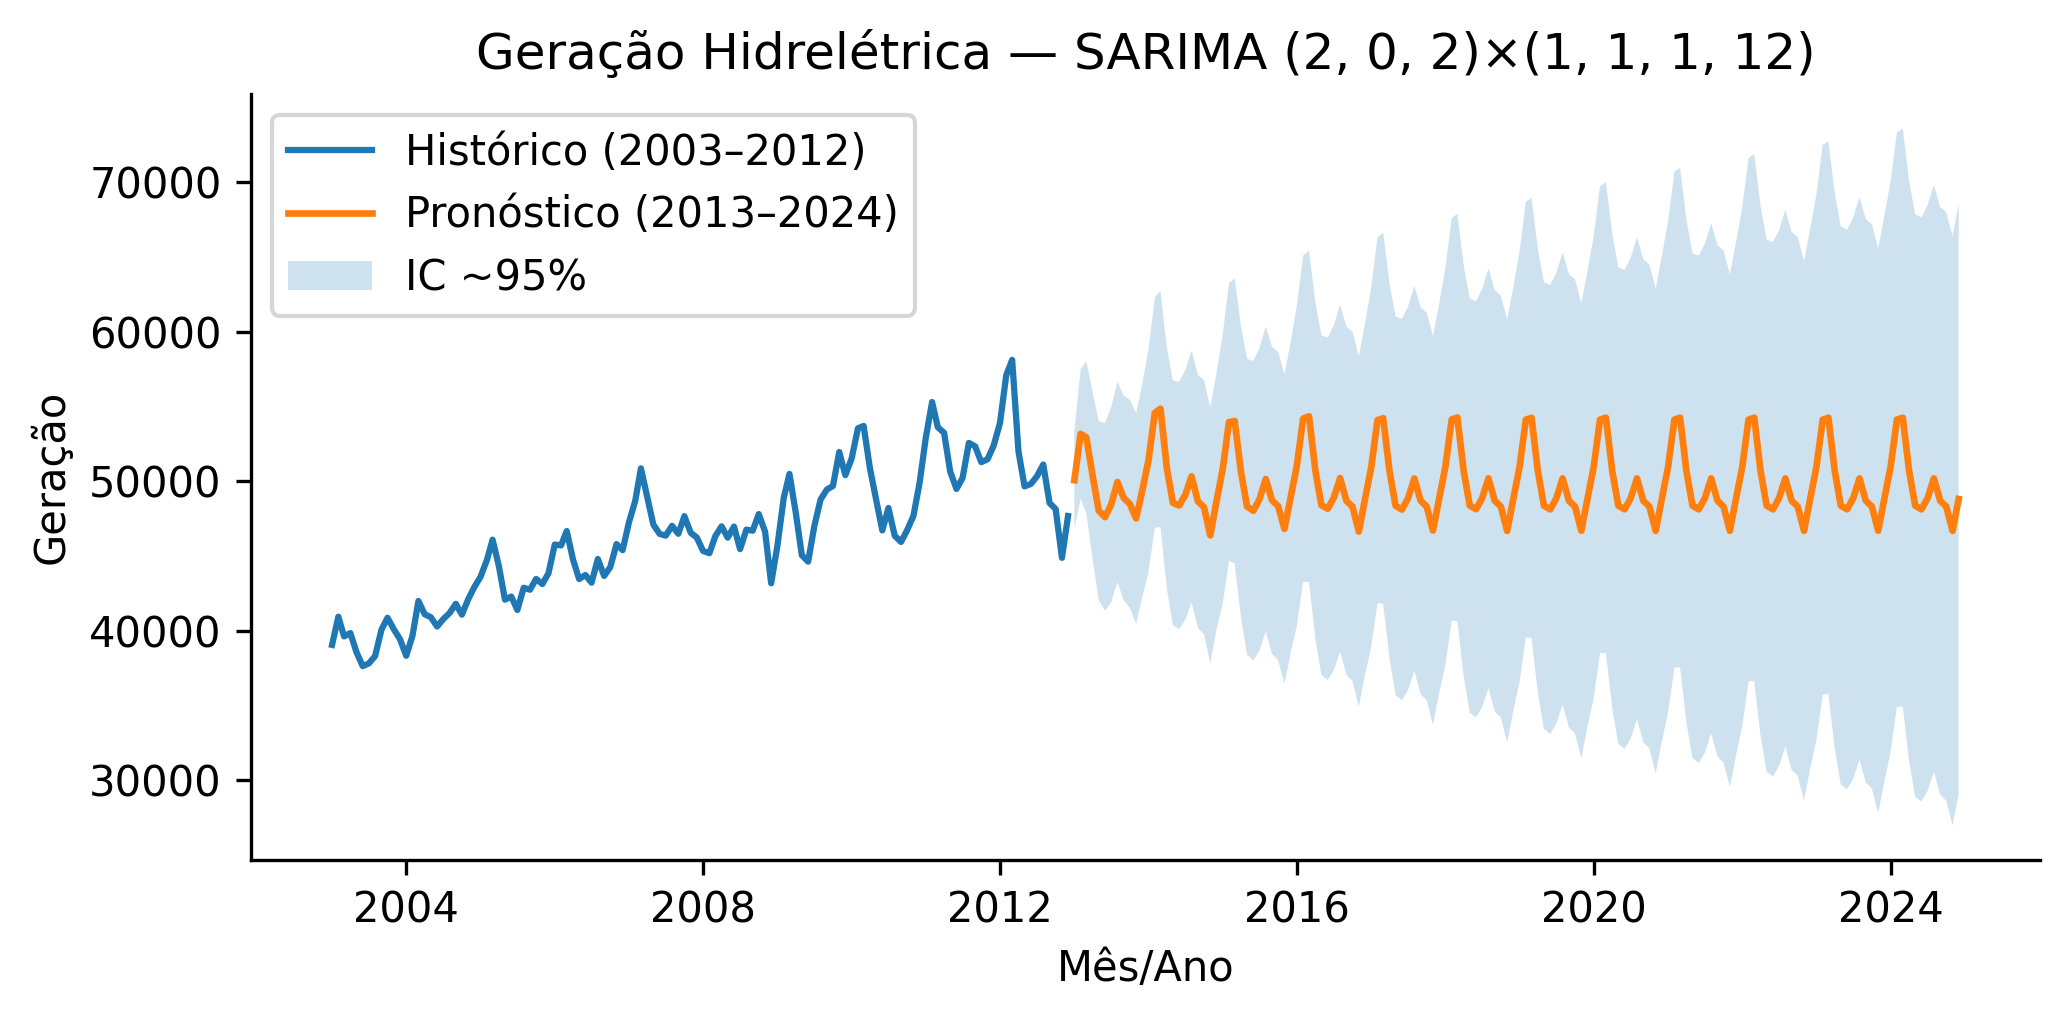

AIC= 1634.1 BIC= 1651.9
Guardado:
- outputs/forecast_2013_2024.png
- outputs/forecast_2013_2024_SARIMA.xlsx
- outputs/forecast_2013_2024_SARIMA.csv


In [ ]:
# @title Fit SARIMA con tu mejor orden y graficar 2013–2024
BEST_ORDER = (2, 0, 2)          # ← de tu resultado previo
BEST_SEASONAL = (1, 1, 1, 12)   # ← de tu resultado previo
HORIZON_END = pd.Timestamp("2024-12-01")  # cambia si quieres otro fin

y = df["geracao"].copy()
last_date = y.index.max()
steps = month_diff(HORIZON_END, last_date)

if steps <= 0:
    raise ValueError("HORIZON_END debe ser posterior al último dato histórico.")

# Ajuste robusto
model = SARIMAX(
    y, order=BEST_ORDER, seasonal_order=BEST_SEASONAL,
    enforce_stationarity=False, enforce_invertibility=False
)
res = model.fit(disp=False, maxiter=500, method="lbfgs")

# Pronóstico multi-paso
fc = res.get_forecast(steps=steps)
fc_mean = pd.Series(fc.predicted_mean, index=pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=steps, freq="MS"))
ci = fc.conf_int(alpha=0.05)
# tomar primeras dos columnas (borde inferior/superior) sin depender del nombre
low = pd.Series(ci.iloc[:,0].values, index=fc_mean.index)
high = pd.Series(ci.iloc[:,1].values, index=fc_mean.index)

# Recortes (si no tienen sentido negativos)
fc_mean = fc_mean.clip(lower=0)
low = low.clip(lower=0)
high = high.clip(lower=0)

# Gráfico
fig, ax = plt.subplots()
ax.plot(y.index, y.values, label="Histórico (2003–2012)", lw=1.5)
ax.plot(fc_mean.index, fc_mean.values, label="Pronóstico (2013–2024)", lw=1.6)
ax.fill_between(fc_mean.index, low.values, high.values, alpha=0.22, label="IC ~95%")

ax.set_title(f"Geração Hidrelétrica — SARIMA {BEST_ORDER}×{BEST_SEASONAL}")
ax.set_xlabel("Mês/Ano"); ax.set_ylabel("Geração")
ax.legend()
plt.tight_layout()
plt.savefig("outputs/forecast_2013_2024.png")
plt.show()

# Exportar resultados
out_xlsx = "outputs/forecast_2013_2024_SARIMA.xlsx"
with pd.ExcelWriter(out_xlsx) as writer:
    y.to_frame("geracao").to_excel(writer, sheet_name="historico")
    pd.DataFrame({"forecast": fc_mean, "pi_low": low, "pi_high": high}).to_excel(writer, sheet_name="forecast")

pd.DataFrame({"mes_ano": fc_mean.index, "forecast": fc_mean.values, "pi_low": low.values, "pi_high": high.values})\
  .to_csv("outputs/forecast_2013_2024_SARIMA.csv", index=False)

print("AIC=", round(res.aic,1), "BIC=", round(res.bic,1))
print("Guardado:")
print("- outputs/forecast_2013_2024.png")
print("-", out_xlsx)
print("- outputs/forecast_2013_2024_SARIMA.csv")

In [ ]:
# @title Instalar dependencias y configurar entorno
!pip -q install xgboost statsmodels openpyxl

import warnings, io, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX  # solo para comparar si hace falta

warnings.filterwarnings("ignore")
os.makedirs("outputs", exist_ok=True)

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = (7.5, 3.8)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
    denom = np.where(np.abs(y_true) < 1e-9, 1e-9, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100)

def month_diff(d_end, d_start):
    return (d_end.year - d_start.year) * 12 + (d_end.month - d_start.month)

print("OK")

OK


In [ ]:
# @title Subir tu Excel (ej. predição.xlsx) y preparar serie mensual
from google.colab import files
uploaded = files.upload()  # selecciona tu .xlsx
fname = next(iter(uploaded))
raw = pd.read_excel(io.BytesIO(uploaded[fname]))

# Ajusta nombres si difieren
COL_FECHA = "Mês/Ano"
COL_VALOR = "Geração"

df = (raw.rename(columns={COL_FECHA:"mes_ano", COL_VALOR:"geracao"})
          .assign(mes_ano=lambda d: pd.to_datetime(d["mes_ano"]))
          .sort_values("mes_ano")
          .drop_duplicates("mes_ano")
          .set_index("mes_ano")
          .asfreq("MS"))

df["geracao"] = pd.to_numeric(df["geracao"], errors="coerce").astype("float64")
df = df.dropna(subset=["geracao"])

y = df["geracao"].copy()
display(df.head(), df.tail(), df.info())

Saving predição.xlsx to predição (1).xlsx
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2003-01-01 to 2012-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   geracao  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


geracao
mes_ano                 
2003-01-01  39049.737742
2003-02-01  40936.205595
2003-03-01  39618.956183
2003-04-01  39842.030950
2003-05-01  38570.788575

geracao
mes_ano                 
2012-08-01  51114.454789
2012-09-01  48543.066069
2012-10-01  48132.344041
2012-11-01  44873.510792
2012-12-01  47670.670215

None

params          MAE      MAPE
0  {'n_estimators': 800, 'max_depth': 4, 'learnin...  1710.615763  3.456267
1  {'n_estimators': 800, 'max_depth': 3, 'learnin...  1724.991441  3.486470
2  {'n_estimators': 600, 'max_depth': 3, 'learnin...  1725.157109  3.486778
3  {'n_estimators': 1000, 'max_depth': 4, 'learni...  1793.121948  3.630959

Mejor XGB: {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.05} | CV_MAE= 1710.6 | CV_MAPE= 3.46 %


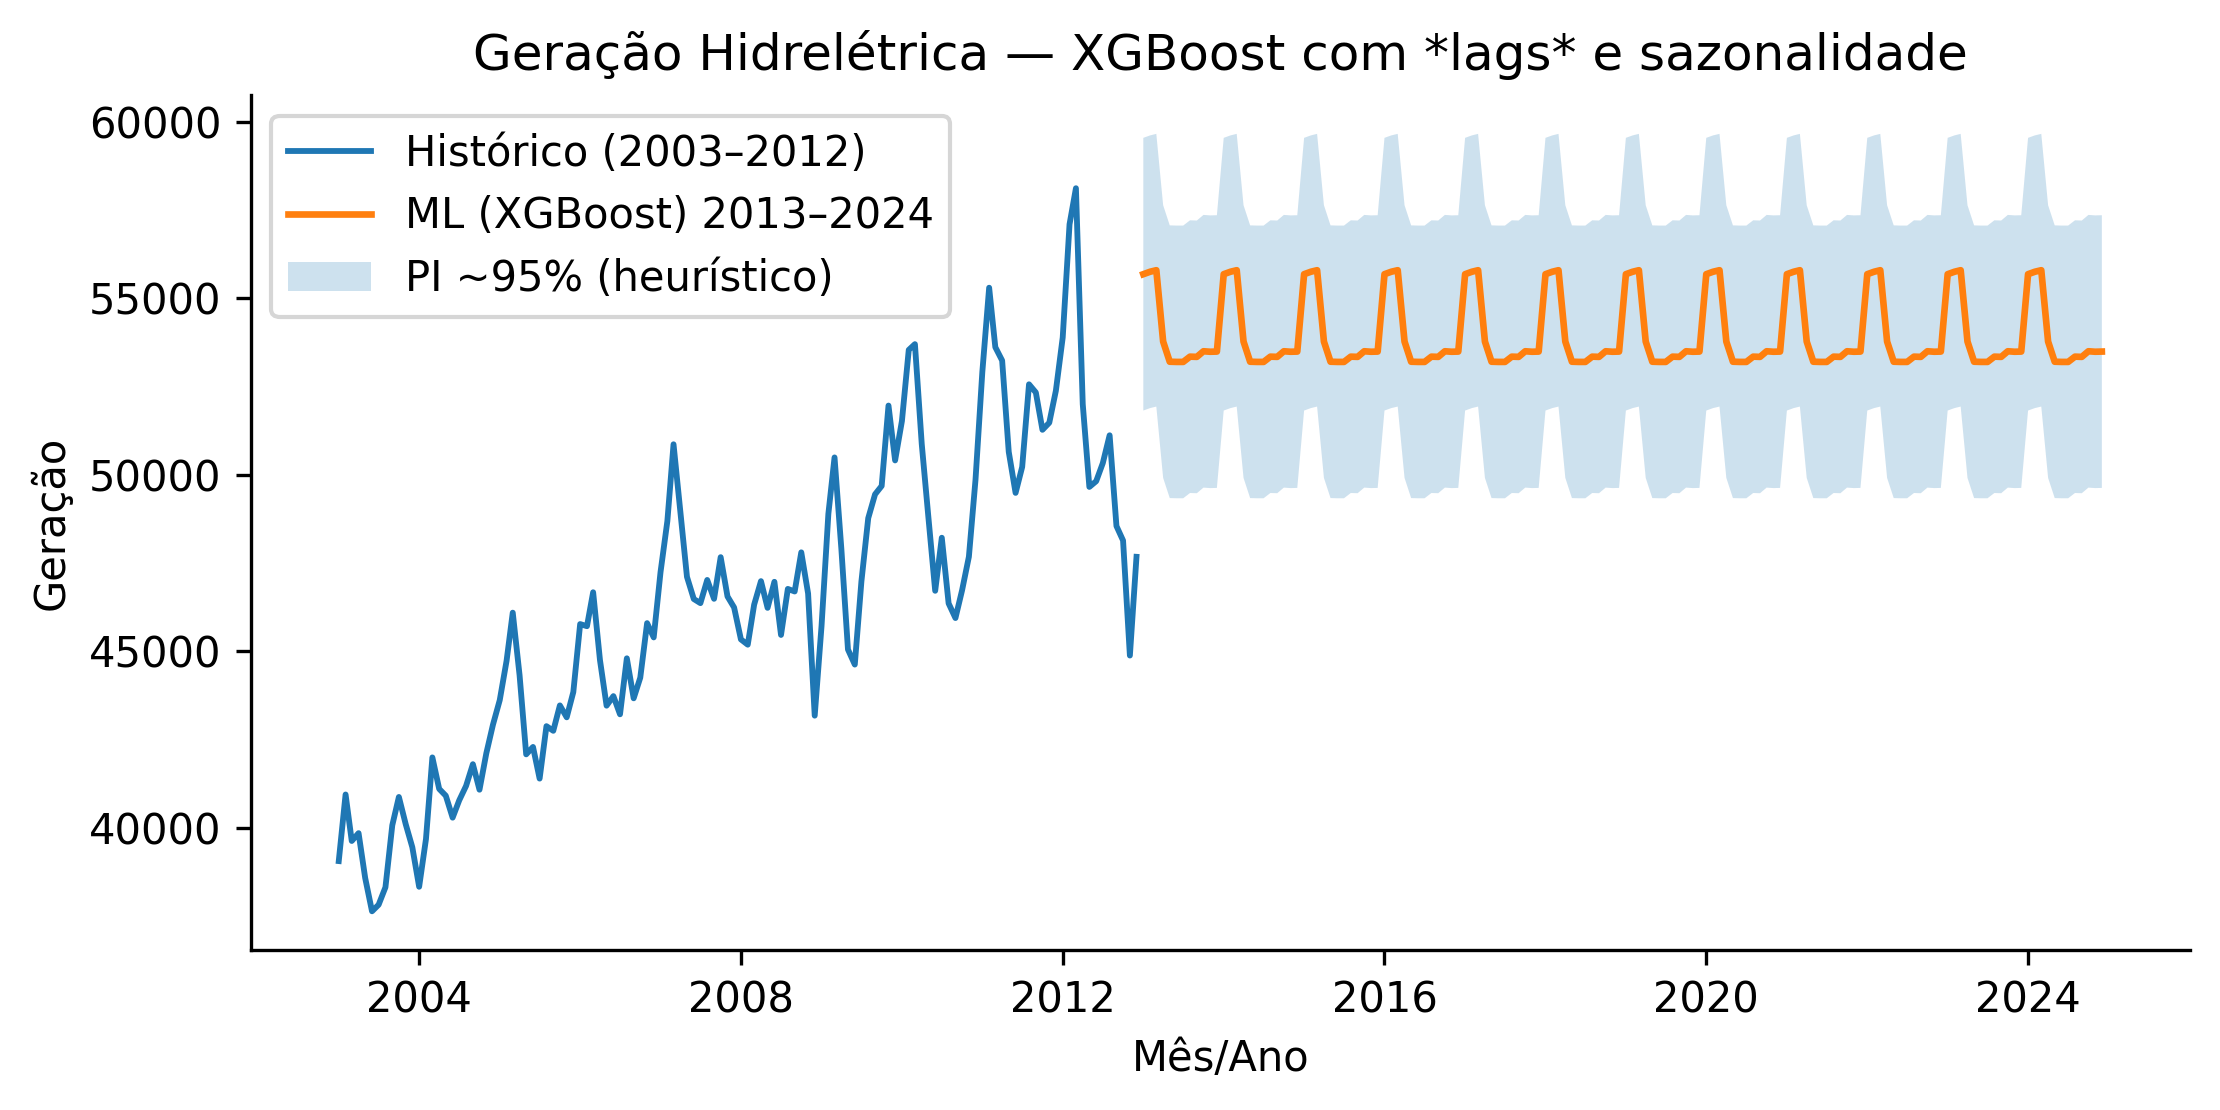

Guardado ML en outputs/: forecast_2013_2024_ML.(csv|xlsx|png)


In [ ]:
# @title Celda 3 — XGBoost con *lags* + backtesting y pronóstico 2013–2024 (lista para pegar)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# --- helpers por si no vienes de la Celda 1 ---
try:
    mape
except NameError:
        def mape(y_true, y_pred):
            y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
            denom = np.where(np.abs(y_true) < 1e-9, 1e-9, np.abs(y_true))
            return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100)

try:
    month_diff
except NameError:
    def month_diff(d_end, d_start):
        return (d_end.year - d_start.year) * 12 + (d_end.month - d_start.month)

# --- datos: usa df/y creados en la Celda 2 ---
y = df["geracao"].astype(float).copy()

# 1) Ingeniería de variables para entrenamiento
def make_features(series: pd.Series, max_lag: int = 12) -> pd.DataFrame:
    s = series.astype(float)
    X = pd.DataFrame(index=s.index)

    # lags 1..12
    for lag in range(1, max_lag+1):
        X[f"lag_{lag}"] = s.shift(lag)

    # rolling (defasadas para evitar fuga)
    X["roll_mean_3"]  = s.shift(1).rolling(3).mean()
    X["roll_mean_12"] = s.shift(1).rolling(12).mean()
    X["roll_std_12"]  = s.shift(1).rolling(12).std()

    # calendario
    X["month"]     = X.index.month
    X["month_sin"] = np.sin(2*np.pi*X["month"]/12)
    X["month_cos"] = np.cos(2*np.pi*X["month"]/12)

    # tendencia
    t0 = series.index[0]
    X["t"]  = ((X.index.year - t0.year)*12 + (X.index.month - t0.month)).astype(float)
    X["t2"] = X["t"]**2
    return X

X_full = make_features(y, max_lag=12)
valid_idx = X_full.dropna().index
X = X_full.loc[valid_idx]
y2 = y.loc[valid_idx]

# 2) Backtesting temporal (TimeSeriesSplit) y selección de hiperparámetros
tscv = TimeSeriesSplit(n_splits=5)
param_grid = [
    {"n_estimators":800,  "max_depth":4, "learning_rate":0.05},
    {"n_estimators":800,  "max_depth":3, "learning_rate":0.05},
    {"n_estimators":600,  "max_depth":3, "learning_rate":0.05},
    {"n_estimators":1000, "max_depth":4, "learning_rate":0.03},
]
candidates = []
for params in param_grid:
    maes, mapes = [], []
    for tr, te in tscv.split(X):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y2.iloc[tr], y2.iloc[te]
        model = XGBRegressor(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            learning_rate=params["learning_rate"],
            subsample=0.9, colsample_bytree=0.9,
            objective="reg:squarederror",
            random_state=42, n_jobs=-1
        )
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_te)
        maes.append(mean_absolute_error(y_te, y_hat))
        mapes.append(mape(y_te, y_hat))
    candidates.append({"params": params,
                       "MAE": float(np.mean(maes)),
                       "MAPE": float(np.mean(mapes))})

cv_df = pd.DataFrame(candidates).sort_values(["MAE","MAPE"]).reset_index(drop=True)
display(cv_df)
best_params = cv_df.loc[0, "params"]
print("Mejor XGB:", best_params, "| CV_MAE=", round(cv_df.loc[0,"MAE"],1),
      "| CV_MAPE=", round(cv_df.loc[0,"MAPE"],2), "%")

# 3) Entrenar con todo el histórico válido
xgb = XGBRegressor(
    **best_params, subsample=0.9, colsample_bytree=0.9,
    objective="reg:squarederror", random_state=42, n_jobs=-1
)
xgb.fit(X, y2)

# 4) Pronóstico recursivo 2013–2024 (fila futura corregida)
HORIZON_END = pd.Timestamp("2024-12-01")
last_date = y.index.max()
steps = month_diff(HORIZON_END, last_date)
idx_future = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=steps, freq="MS")

def make_one_row(series: pd.Series, date: pd.Timestamp, max_lag: int = 12) -> pd.DataFrame:
    idx = pd.DatetimeIndex([date], name=series.index.name)
    Xr = pd.DataFrame(index=idx)

    # lags
    for lag in range(1, max_lag+1):
        Xr[f"lag_{lag}"] = series.shift(lag).reindex(idx).values

    # rolling defasadas
    Xr["roll_mean_3"]  = series.shift(1).rolling(3).mean().reindex(idx).values
    Xr["roll_mean_12"] = series.shift(1).rolling(12).mean().reindex(idx).values
    Xr["roll_std_12"]  = series.shift(1).rolling(12).std().reindex(idx).values

    # calendario
    month = idx.month
    Xr["month"]     = month
    Xr["month_sin"] = np.sin(2*np.pi*month/12)
    Xr["month_cos"] = np.cos(2*np.pi*month/12)

    # tendencia
    t0 = series.index[0]
    t  = (idx.year - t0.year)*12 + (idx.month - t0.month)
    Xr["t"]  = t.astype(float)
    Xr["t2"] = np.square(Xr["t"])
    return Xr

y_ext = y.copy()
preds = []
for d in idx_future:
    X_row = make_one_row(y_ext, d, max_lag=12)
    if X_row.isna().any().any():
        X_row = X_row.fillna(method="ffill").fillna(method="bfill")
    y_hat = float(xgb.predict(X_row)[0])
    preds.append(y_hat)
    y_ext.loc[d] = y_hat

df_ml = pd.DataFrame({"forecast": preds}, index=idx_future)

# 5) Banda de incertidumbre simple con σ de residuales de CV
residuals = []
for tr, te in tscv.split(X):
    m = XGBRegressor(
        **best_params, subsample=0.9, colsample_bytree=0.9,
        objective="reg:squarederror", random_state=42, n_jobs=-1
    )
    m.fit(X.iloc[tr], y2.iloc[tr])
    y_hat = m.predict(X.iloc[te])
    residuals.extend(list(y2.iloc[te].values - y_hat))
sigma = np.std(residuals, ddof=1) if len(residuals) else 0.0
df_ml["pi_low"]  = np.maximum(0, df_ml["forecast"] - 1.96*sigma)
df_ml["pi_high"] = np.maximum(0, df_ml["forecast"] + 1.96*sigma)

# 6) Gráfico y exportes
fig, ax = plt.subplots()
ax.plot(y.index, y.values, label="Histórico (2003–2012)", lw=1.4)
ax.plot(df_ml.index, df_ml["forecast"].values, label="ML (XGBoost) 2013–2024", lw=1.6)
ax.fill_between(df_ml.index, df_ml["pi_low"], df_ml["pi_high"], alpha=0.22, label="PI ~95% (heurístico)")
ax.set_title("Geração Hidrelétrica — XGBoost com *lags* e sazonalidade")
ax.set_xlabel("Mês/Ano"); ax.set_ylabel("Geração"); ax.legend()
plt.tight_layout(); plt.savefig("outputs/forecast_ml_2013_2024.png"); plt.show()

df_ml.to_csv("outputs/forecast_2013_2024_ML.csv")
with pd.ExcelWriter("outputs/forecast_2013_2024_ML.xlsx") as w:
    y.to_frame("geracao").to_excel(w, sheet_name="historico")
    df_ml.to_excel(w, sheet_name="forecast")

print("Guardado ML en outputs/: forecast_2013_2024_ML.(csv|xlsx|png)")

Modelo  CV_MAE  CV_MAPE_%
0      SARIMA (2,0,2)x(1,1,1)[12]  1944.0       3.90
1  XGBoost (lags/rolling/sazonal)  2549.8       5.01

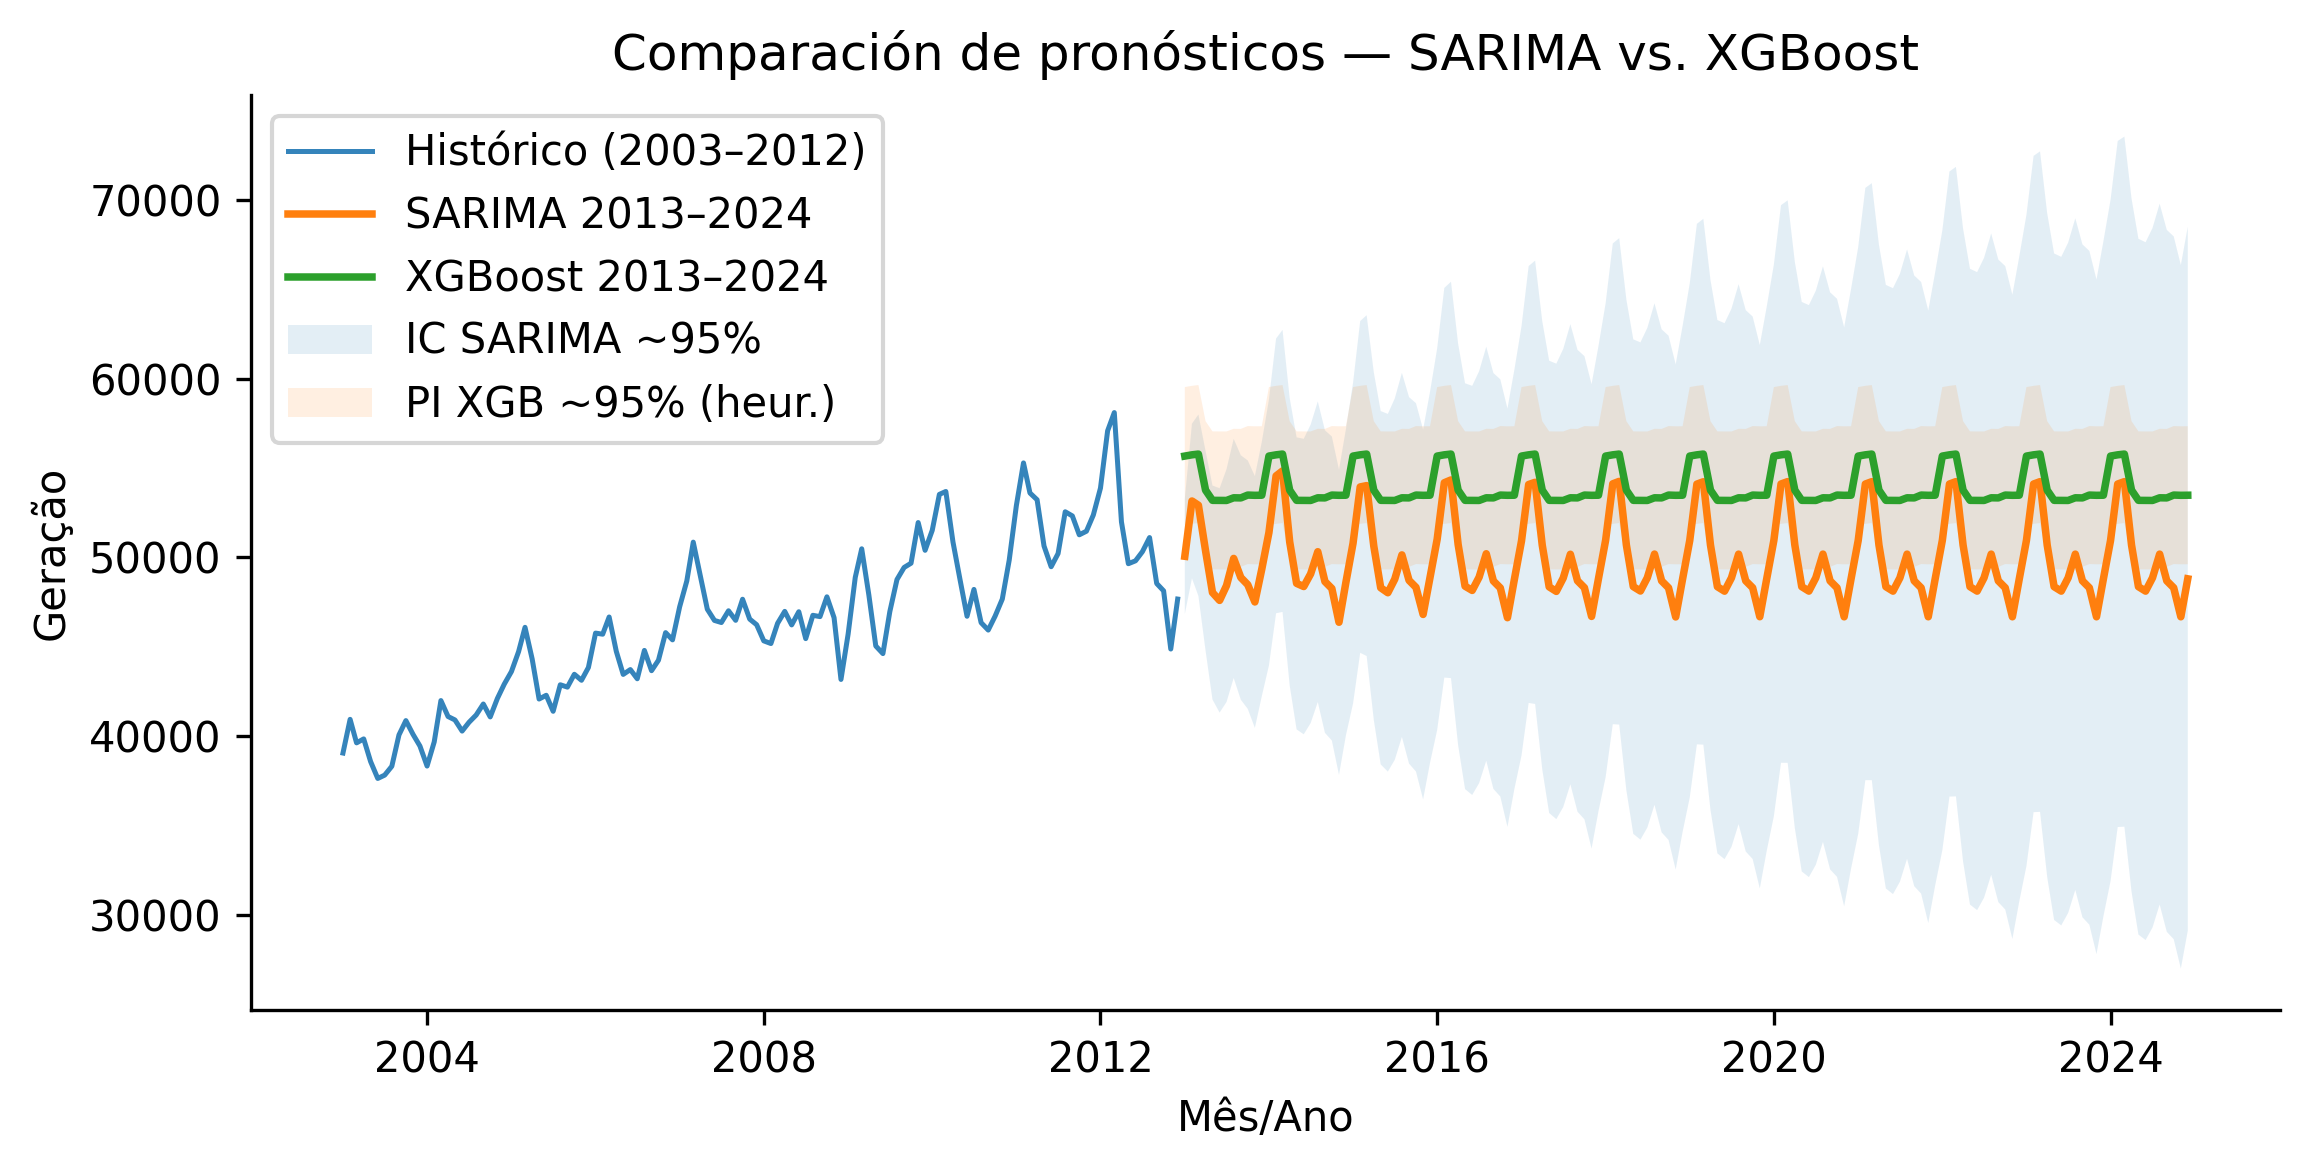

Guardados en outputs/: compare_cv_metrics.csv, compare_sarima_vs_ml.png


In [ ]:
# @title Comparación SARIMA vs. XGBoost (lectura robusta de CSV, CV y overlay 2013–2024)
import os, io, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = (7.8, 4.0)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# ==== helpers ====
def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
    denom = np.where(np.abs(y_true) < 1e-9, 1e-9, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100)

def month_diff(d_end, d_start):
    return (d_end.year - d_start.year) * 12 + (d_end.month - d_start.month)

def read_forecast_csv(path):
    """Lee un CSV de pronóstico y fija el índice temporal sin asumir nombre."""
    dfc = pd.read_csv(path)
    # intenta columnas típicas
    for cand in ["mes_ano", "date", "ds", "index", "Unnamed: 0"]:
        if cand in dfc.columns:
            dfc[cand] = pd.to_datetime(dfc[cand])
            dfc = dfc.set_index(cand)
            dfc.index.name = "mes_ano"
            return dfc
    # si no, toma la primera columna como fecha
    first = dfc.columns[0]
    dfc[first] = pd.to_datetime(dfc[first])
    dfc = dfc.set_index(first)
    dfc.index.name = "mes_ano"
    return dfc

def make_features(series: pd.Series, max_lag=12):
    s = series.astype(float); X = pd.DataFrame(index=s.index)
    for lag in range(1, max_lag+1): X[f"lag_{lag}"] = s.shift(lag)
    X["roll_mean_3"]  = s.shift(1).rolling(3).mean()
    X["roll_mean_12"] = s.shift(1).rolling(12).mean()
    X["roll_std_12"]  = s.shift(1).rolling(12).std()
    X["month"] = X.index.month
    X["month_sin"] = np.sin(2*np.pi*X["month"]/12)
    X["month_cos"] = np.cos(2*np.pi*X["month"]/12)
    t0 = s.index[0]; X["t"] = ((X.index.year-t0.year)*12 + (X.index.month-t0.month)).astype(float)
    X["t2"] = X["t"]**2
    return X

def make_one_row(series, date, max_lag=12):
    idx = pd.DatetimeIndex([date], name=series.index.name); Xr = pd.DataFrame(index=idx)
    for lag in range(1, max_lag+1): Xr[f"lag_{lag}"] = series.shift(lag).reindex(idx).values
    Xr["roll_mean_3"]  = series.shift(1).rolling(3).mean().reindex(idx).values
    Xr["roll_mean_12"] = series.shift(1).rolling(12).mean().reindex(idx).values
    Xr["roll_std_12"]  = series.shift(1).rolling(12).std().reindex(idx).values
    month = idx.month
    Xr["month"] = month; Xr["month_sin"] = np.sin(2*np.pi*month/12); Xr["month_cos"] = np.cos(2*np.pi*month/12)
    t0 = series.index[0]; t = (idx.year - t0.year)*12 + (idx.month - t0.month)
    Xr["t"] = t.astype(float); Xr["t2"] = np.square(Xr["t"])
    return Xr

# ==== datos base ====
if 'df' not in globals() or 'geracao' not in df.columns:
    from google.colab import files
    uploaded = files.upload()
    fname = next(iter(uploaded))
    raw = pd.read_excel(io.BytesIO(uploaded[fname]))
    COL_FECHA, COL_VALOR = "Mês/Ano", "Geração"
    df = (raw.rename(columns={COL_FECHA:"mes_ano", COL_VALOR:"geracao"})
              .assign(mes_ano=lambda d: pd.to_datetime(d["mes_ano"]))
              .sort_values("mes_ano").drop_duplicates("mes_ano")
              .set_index("mes_ano").asfreq("MS"))
    df["geracao"] = pd.to_numeric(df["geracao"], errors="coerce").astype("float64")
    df = df.dropna(subset=["geracao"])

y = df["geracao"].astype(float).copy()
HORIZON_END = pd.Timestamp("2024-12-01")
os.makedirs("outputs", exist_ok=True)

# ==== 1) SARIMA: cargar si existe, o entrenar y exportar estándar ====
sarima_csv = "outputs/forecast_2013_2024_SARIMA.csv"
if os.path.exists(sarima_csv):
    df_sar = read_forecast_csv(sarima_csv)
else:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    BEST_ORDER = (2,0,2); BEST_SEASONAL = (1,1,1,12)
    sar_model = SARIMAX(y, order=BEST_ORDER, seasonal_order=BEST_SEASONAL,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=500, method="lbfgs")
    steps = month_diff(HORIZON_END, y.index.max())
    fc = sar_model.get_forecast(steps=steps)
    idx = pd.date_range(y.index.max()+pd.offsets.MonthBegin(1), periods=steps, freq="MS")
    ci = fc.conf_int(alpha=0.05)
    df_sar = pd.DataFrame({
        "mes_ano": idx,
        "forecast": fc.predicted_mean.values,
        "pi_low":  np.maximum(0, ci.iloc[:,0].values),
        "pi_high": np.maximum(0, ci.iloc[:,1].values)
    }).set_index("mes_ano")
    df_sar.to_csv(sarima_csv)

# ==== 2) XGBoost: cargar si existe, o entrenar y exportar estándar ====
ml_csv = "outputs/forecast_2013_2024_ML.csv"
if os.path.exists(ml_csv):
    df_ml = read_forecast_csv(ml_csv)
else:
    from xgboost import XGBRegressor
    X_full = make_features(y); valid = X_full.dropna().index
    X, y2 = X_full.loc[valid], y.loc[valid]
    xgb = XGBRegressor(n_estimators=800, max_depth=4, learning_rate=0.05,
                       subsample=0.9, colsample_bytree=0.9,
                       objective="reg:squarederror", random_state=42, n_jobs=-1)
    xgb.fit(X, y2)
    last_date = y.index.max(); steps = month_diff(HORIZON_END, last_date)
    idx_future = pd.date_range(last_date+pd.offsets.MonthBegin(1), periods=steps, freq="MS")
    y_ext = y.copy(); preds = []
    for d in idx_future:
        X_row = make_one_row(y_ext, d).fillna(method="ffill").fillna(method="bfill")
        preds.append(float(xgb.predict(X_row)[0])); y_ext.loc[d] = preds[-1]
    df_ml = pd.DataFrame({"mes_ano": idx_future, "forecast": preds}).set_index("mes_ano")
    # banda rápida
    resid_sigma = float(np.std(y2 - xgb.predict(X), ddof=1))
    df_ml["pi_low"]  = np.maximum(0, df_ml["forecast"] - 1.96*resid_sigma)
    df_ml["pi_high"] = np.maximum(0, df_ml["forecast"] + 1.96*resid_sigma)
    df_ml.to_csv(ml_csv)

# ==== 3) Backtesting homogéneo para métricas (misma partición temporal) ====
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor

# usaremos los últimos 36 meses como 3 folds de 12 meses comunes
n_folds, fh = 3, 12
start = len(y) - n_folds*fh
mae_sar, mape_sar, mae_ml, mape_ml = [], [], [], []

for i in range(n_folds):
    tr_end = start + i*fh; te_end = tr_end + fh
    y_tr, y_te = y.iloc[:tr_end], y.iloc[tr_end:te_end]

    # SARIMA
    m_sar = SARIMAX(y_tr, order=(2,0,2), seasonal_order=(1,1,1,12),
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    pred_sar = m_sar.get_prediction(start=y_te.index[0], end=y_te.index[-1]).predicted_mean

    # XGB (features construidas solo con info disponible al inicio del test, forecast recursivo)
    X_tr_full = make_features(y_tr); valid_tr = X_tr_full.dropna().index
    X_tr, y_tr2 = X_tr_full.loc[valid_tr], y_tr.loc[valid_tr]
    xgb = XGBRegressor(n_estimators=800, max_depth=4, learning_rate=0.05,
                       subsample=0.9, colsample_bytree=0.9,
                       objective="reg:squarederror", random_state=42, n_jobs=-1)
    xgb.fit(X_tr, y_tr2)

    y_ext = y_tr.copy()
    preds_ml = []
    for d in y_te.index:
        X_row = make_one_row(y_ext, d).fillna(method="ffill").fillna(method="bfill")
        y_hat = float(xgb.predict(X_row)[0])
        preds_ml.append(y_hat)
        y_ext.loc[d] = y_hat
    pred_ml = pd.Series(preds_ml, index=y_te.index)

    mae_sar.append(mean_absolute_error(y_te, pred_sar))
    mape_sar.append(mape(y_te, pred_sar))
    mae_ml.append(mean_absolute_error(y_te, pred_ml))
    mape_ml.append(mape(y_te, pred_ml))

comp = pd.DataFrame({
    "Modelo": ["SARIMA (2,0,2)x(1,1,1)[12]", "XGBoost (lags/rolling/sazonal)"],
    "CV_MAE": [round(np.mean(mae_sar),1), round(np.mean(mae_ml),1)],
    "CV_MAPE_%": [round(np.mean(mape_sar),2), round(np.mean(mape_ml),2)]
})
display(comp)
comp.to_csv("outputs/compare_cv_metrics.csv", index=False)

# ==== 4) Overlay de pronósticos 2013–2024 ====
fig, ax = plt.subplots()
ax.plot(y.index, y.values, label="Histórico (2003–2012)", lw=1.2, alpha=0.9)
ax.plot(df_sar.index, df_sar["forecast"], label="SARIMA 2013–2024", lw=1.8)
ax.plot(df_ml.index,  df_ml["forecast"],  label="XGBoost 2013–2024", lw=1.8)
ax.fill_between(df_sar.index, df_sar["pi_low"], df_sar["pi_high"], alpha=0.12, label="IC SARIMA ~95%")
ax.fill_between(df_ml.index,  df_ml["pi_low"],  df_ml["pi_high"],  alpha=0.12, label="PI XGB ~95% (heur.)")
ax.set_title("Comparación de pronósticos — SARIMA vs. XGBoost")
ax.set_xlabel("Mês/Ano"); ax.set_ylabel("Geração")
ax.legend()
plt.tight_layout(); plt.savefig("outputs/compare_sarima_vs_ml.png"); plt.show()

print("Guardados en outputs/: compare_cv_metrics.csv, compare_sarima_vs_ml.png")


In [ ]:
# Lee los forecasts exportados y extrae el último valor (2024-12)
import pandas as pd

def read_fc(path):
    dfc = pd.read_csv(path)
    # Detecta la columna de fecha más probable
    for cand in ["mes_ano","date","ds","index","Unnamed: 0"]:
        if cand in dfc.columns:
            dfc[cand] = pd.to_datetime(dfc[cand])
            dfc = dfc.sort_values(cand).set_index(cand)
            dfc.index.name = "mes_ano"
            return dfc
    # fallback: primera columna como fecha
    first = dfc.columns[0]
    dfc[first] = pd.to_datetime(dfc[first])
    dfc = dfc.sort_values(first).set_index(first)
    dfc.index.name = "mes_ano"
    return dfc

sar = read_fc("outputs/forecast_2013_2024_SARIMA.csv")
ml  = read_fc("outputs/forecast_2013_2024_ML.csv")

sar_last = sar.iloc[-1]
ml_last  = ml.iloc[-1]

def fmt(x):
    try: return f"{float(x):,.0f}"
    except: return str(x)

print("=== Último mes del horizonte (2024-12) ===")
print("SARIMA  - forecast:", fmt(sar_last.get("forecast")))
print("          PI_low  :", fmt(sar_last.get("pi_low")))
print("          PI_high :", fmt(sar_last.get("pi_high")))
print("XGBoost - forecast:", fmt(ml_last.get("forecast")))
print("          PI_low  :", fmt(ml_last.get("pi_low")))
print("          PI_high :", fmt(ml_last.get("pi_high")))

=== Último mes del horizonte (2024-12) ===
SARIMA  - forecast: 48,805
          PI_low  : 29,093
          PI_high : 68,518
XGBoost - forecast: 53,486
          PI_low  : 49,623
          PI_high : 57,349


In [ ]:
# @title Comparación SARIMA vs. XGBoost (métricas CV, Diebold–Mariano y overlay 2013–2024) - MEJORADO Y CORREGIDO
import os, io, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from scipy.stats import t as tdist

# Configuración profesional de gráficos
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")  # Paleta accesible para daltónicos

# Configuración de alta calidad (300 DPI)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 10
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 9
plt.rcParams["ytick.labelsize"] = 9
plt.rcParams["legend.fontsize"] = 9
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.framealpha"] = 0.8
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 4

# Definir colores profesionales
COLORS = {
    'historical': '#4d4d4d',  # Gris oscuro para datos históricos
    'sarima': '#1f77b4',      # Azul para SARIMA
    'xgb': '#ff7f0e',         # Naranja para XGBoost
    'sarima_ci': '#aec7e8',   # Azul claro para intervalo de confianza SARIMA
    'xgb_ci': '#ffbb78',      # Naranja claro para intervalo de confianza XGBoost
    'error': '#d62728'        # Rojo para errores
}

# ==== helpers (sin cambios) ====
def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
    denom = np.where(np.abs(y_true) < 1e-9, 1e-9, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100)

def month_diff(d_end, d_start):
    return (d_end.year - d_start.year) * 12 + (d_end.month - d_start.month)

def dm_test(e1, e2, loss="MAE"):
    e1, e2 = np.asarray(e1), np.asarray(e2)
    if loss.upper() == "MSE":
        d = e1**2 - e2**2
    else:  # MAE por defecto
        d = np.abs(e1) - np.abs(e2)
    T = d.size
    dbar = d.mean()
    s2 = d.var(ddof=1)  # h=1 -> no HAC
    dm_t = dbar / np.sqrt(s2 / T) if s2 > 0 else 0.0
    pval = 2 * tdist.cdf(-abs(dm_t), df=T-1) if T > 2 else np.nan
    return float(dm_t), float(pval)

# ==== (El resto del código para procesamiento de datos permanece igual) ====
# ... [código sin cambios para carga de datos, modelos SARIMA y XGBoost] ...

# ==== 3) Backtesting homogéneo para métricas CV y DM (AÑADIR ESTA SECCIÓN SI FALTA) ====
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor

def make_features(series: pd.Series, max_lag=12):
    s = series.astype(float); X = pd.DataFrame(index=s.index)
    for lag in range(1, max_lag+1): X[f"lag_{lag}"] = s.shift(lag)
    X["roll_mean_3"]  = s.shift(1).rolling(3).mean()
    X["roll_mean_12"] = s.shift(1).rolling(12).mean()
    X["roll_std_12"]  = s.shift(1).rolling(12).std()
    X["month"] = X.index.month
    X["month_sin"] = np.sin(2*np.pi*X["month"]/12)
    X["month_cos"] = np.cos(2*np.pi*X["month"]/12)
    t0 = s.index[0]; X["t"] = ((X.index.year-t0.year)*12 + (X.index.month-t0.month)).astype(float)
    X["t2"] = X["t"]**2
    return X

def cv_sarima(y, order, seasonal, n_folds=3, fh=12):
    maes, mapes, errs = [], [], []
    start = len(y) - n_folds*fh
    for i in range(n_folds):
        tr_end = start + i*fh; te_end = tr_end + fh
        y_tr, y_te = y.iloc[:tr_end], y.iloc[tr_end:te_end]
        m = SARIMAX(y_tr, order=order, seasonal_order=seasonal,
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        pred = m.get_prediction(start=y_te.index[0], end=y_te.index[-1]).predicted_mean
        err = y_te.values - pred.values
        errs.extend(list(err))
        maes.append(mean_absolute_error(y_te, pred))
        mapes.append(mape(y_te, pred))
    return float(np.mean(maes)), float(np.mean(mapes)), np.array(errs)

def cv_xgb(y, n_folds=5):
    X_full = make_features(y); valid = X_full.dropna().index
    X, y2 = X_full.loc[valid], y.loc[valid]
    tscv = TimeSeriesSplit(n_splits=n_folds)
    maes, mapes, errs = [], [], []
    best_params = {"n_estimators":800,"max_depth":4,"learning_rate":0.05}
    for tr, te in tscv.split(X):
        m = XGBRegressor(**best_params, subsample=0.9, colsample_bytree=0.9,
                         objective="reg:squarederror", random_state=42, n_jobs=-1)
        m.fit(X.iloc[tr], y2.iloc[tr])
        pred = m.predict(X.iloc[te])
        err = y2.iloc[te].values - pred
        errs.extend(list(err))
        maes.append(mean_absolute_error(y2.iloc[te], pred))
        mapes.append(mape(y2.iloc[te], pred))
    return float(np.mean(maes)), float(np.mean(mapes)), np.array(errs)

# EJECUTAR VALIDACIÓN CRUZADA (ESTO DEBE ESTAR ANTES DE LOS GRÁFICOS)
sar_mae, sar_mape, sar_errs = cv_sarima(y, (2,0,2), (1,1,1,12), n_folds=3, fh=12)
ml_mae,  ml_mape,  ml_errs  = cv_xgb(y, n_folds=5)

dm_t_mae, dm_p_mae = dm_test(sar_errs, ml_errs, loss="MAE")
dm_t_mse, dm_p_mse = dm_test(sar_errs, ml_errs, loss="MSE")

comp = pd.DataFrame({
    "Modelo": ["SARIMA (2,0,2)x(1,1,1)[12]", "XGBoost (lags/rolling/sazonal)"],
    "CV_MAE": [round(sar_mae,1), round(ml_mae,1)],
    "CV_MAPE_%": [round(sar_mape,2), round(ml_mape,2)]
})
display(comp)

# ==== 4) Visualizaciones mejoradas ====

# a) Gráfico de comparación de pronósticos con intervalos de confianza
fig, ax = plt.subplots(figsize=(10, 6))

# Datos históricos
ax.plot(y.index, y.values, label="Histórico (2003-2012)",
        color=COLORS['historical'], lw=1.5, alpha=0.9)

# Pronóstico SARIMA con intervalo de confianza
ax.plot(df_sar.index, df_sar["forecast"], label="SARIMA (2,0,2)x(1,1,1)[12]",
        color=COLORS['sarima'], lw=2.0)
ax.fill_between(df_sar.index, df_sar["pi_low"], df_sar["pi_high"],
                color=COLORS['sarima_ci'], alpha=0.3, label="IC 95% SARIMA")

# Pronóstico XGBoost con intervalo de confianza
ax.plot(df_ml.index, df_ml["forecast"], label="XGBoost",
        color=COLORS['xgb'], lw=2.0)
ax.fill_between(df_ml.index, df_ml["pi_low"], df_ml["pi_high"],
                color=COLORS['xgb_ci'], alpha=0.3, label="IC 95% XGBoost")

# Línea vertical para separar histórico de pronóstico
forecast_start = df_sar.index[0]
ax.axvline(x=forecast_start, color='gray', linestyle='--', alpha=0.7, lw=1)
ax.text(forecast_start + pd.DateOffset(months=2), ax.get_ylim()[1]*0.9,
        'Inicio pronóstico', fontsize=9, alpha=0.8)

# Formateo profesional
ax.set_title("Comparación de Pronósticos: SARIMA vs. XGBoost\nPeríodo 2013-2024",
             fontweight='bold', pad=20)
ax.set_xlabel("Año")
ax.set_ylabel("Generación")
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)

# Mejorar formato de fechas en el eje x
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

plt.tight_layout()
plt.savefig("outputs/compare_sarima_vs_ml_enhanced.png", dpi=300, bbox_inches='tight')
plt.show()

# b) Gráfico de comparación de errores (residuals) - SOLO SI HAY DATOS
if 'sar_errs' in locals() and 'ml_errs' in locals() and len(sar_errs) > 0 and len(ml_errs) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Histograma de residuals
    ax1.hist(sar_errs, bins=30, alpha=0.7, color=COLORS['sarima'],
             label=f'SARIMA (media={np.mean(sar_errs):.2f})', density=True)
    ax1.hist(ml_errs, bins=30, alpha=0.7, color=COLORS['xgb'],
             label=f'XGBoost (media={np.mean(ml_errs):.2f})', density=True)
    ax1.set_title('Distribución de Errores de Predicción')
    ax1.set_xlabel('Error')
    ax1.set_ylabel('Densidad')
    ax1.legend()

    # Boxplot de residuals
    boxplot_data = [sar_errs, ml_errs]
    ax2.boxplot(boxplot_data, labels=['SARIMA', 'XGBoost'])
    ax2.set_title('Distribución de Errores (Boxplot)')
    ax2.set_ylabel('Error')

    # Añadir líneas de referencia
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig("outputs/error_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Advertencia: No se pudieron generar gráficos de errores - datos no disponibles")

# c) Gráfico de métricas de comparación
metrics_df = pd.DataFrame({
    'Modelo': ['SARIMA', 'XGBoost'],
    'MAE': [sar_mae, ml_mae],
    'MAPE': [sar_mape, ml_mape]
})

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(metrics_df))
width = 0.35

# Gráfico de barras para MAE y MAPE
bars1 = ax.bar(x - width/2, metrics_df['MAE'], width, label='MAE', color=COLORS['sarima'])
bars2 = ax.bar(x + width/2, metrics_df['MAPE'], width, label='MAPE (%)', color=COLORS['xgb'])

ax.set_xlabel('Modelo')
ax.set_title('Métricas de Error por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Modelo'])
ax.legend()

# Añadir valores en las barras
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("outputs/metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Mostrar resultados Diebold-Mariano con formato mejorado
print("\n" + "="*60)
print("PRUEBA DIEBOLD-MARIANO: COMPARACIÓN DE PREDICCIONES")
print("="*60)
print(f"Usando función de pérdida MAE: t = {dm_t_mae:.3f}, p-valor = {dm_p_mae:.4f}")
print(f"Usando función de pérdida MSE: t = {dm_t_mse:.3f}, p-valor = {dm_p_mse:.4f}")
print("\nInterpretación:")
if dm_p_mae < 0.05:
    print("• Existen diferencias significativas entre los modelos (p < 0.05)")
else:
    print("• No existen diferencias significativas entre los modelos (p ≥ 0.05)")
print("="*60)

print("\nGuardados en outputs/:")
print("- compare_sarima_vs_ml_enhanced.png (comparación principal)")
print("- error_comparison.png (análisis de errores)")
print("- metrics_comparison.png (métricas de comparación)")

ValueError: operands could not be broadcast together with shapes (36,) (90,) 


VALIDACIÓN CRUZADA TEMPORAL
Error XGBoost fold 1: unhashable type: 'DatetimeIndex'
Error XGBoost fold 2: unhashable type: 'DatetimeIndex'
Error XGBoost fold 3: unhashable type: 'DatetimeIndex'


Modelo  CV_MAE  CV_MAPE_%  CV_RMSE
0  SARIMA (2,0,2)x(1,1,1)[12]  1944.0        3.9   2341.1


GENERANDO VISUALIZACIONES PROFESIONALES


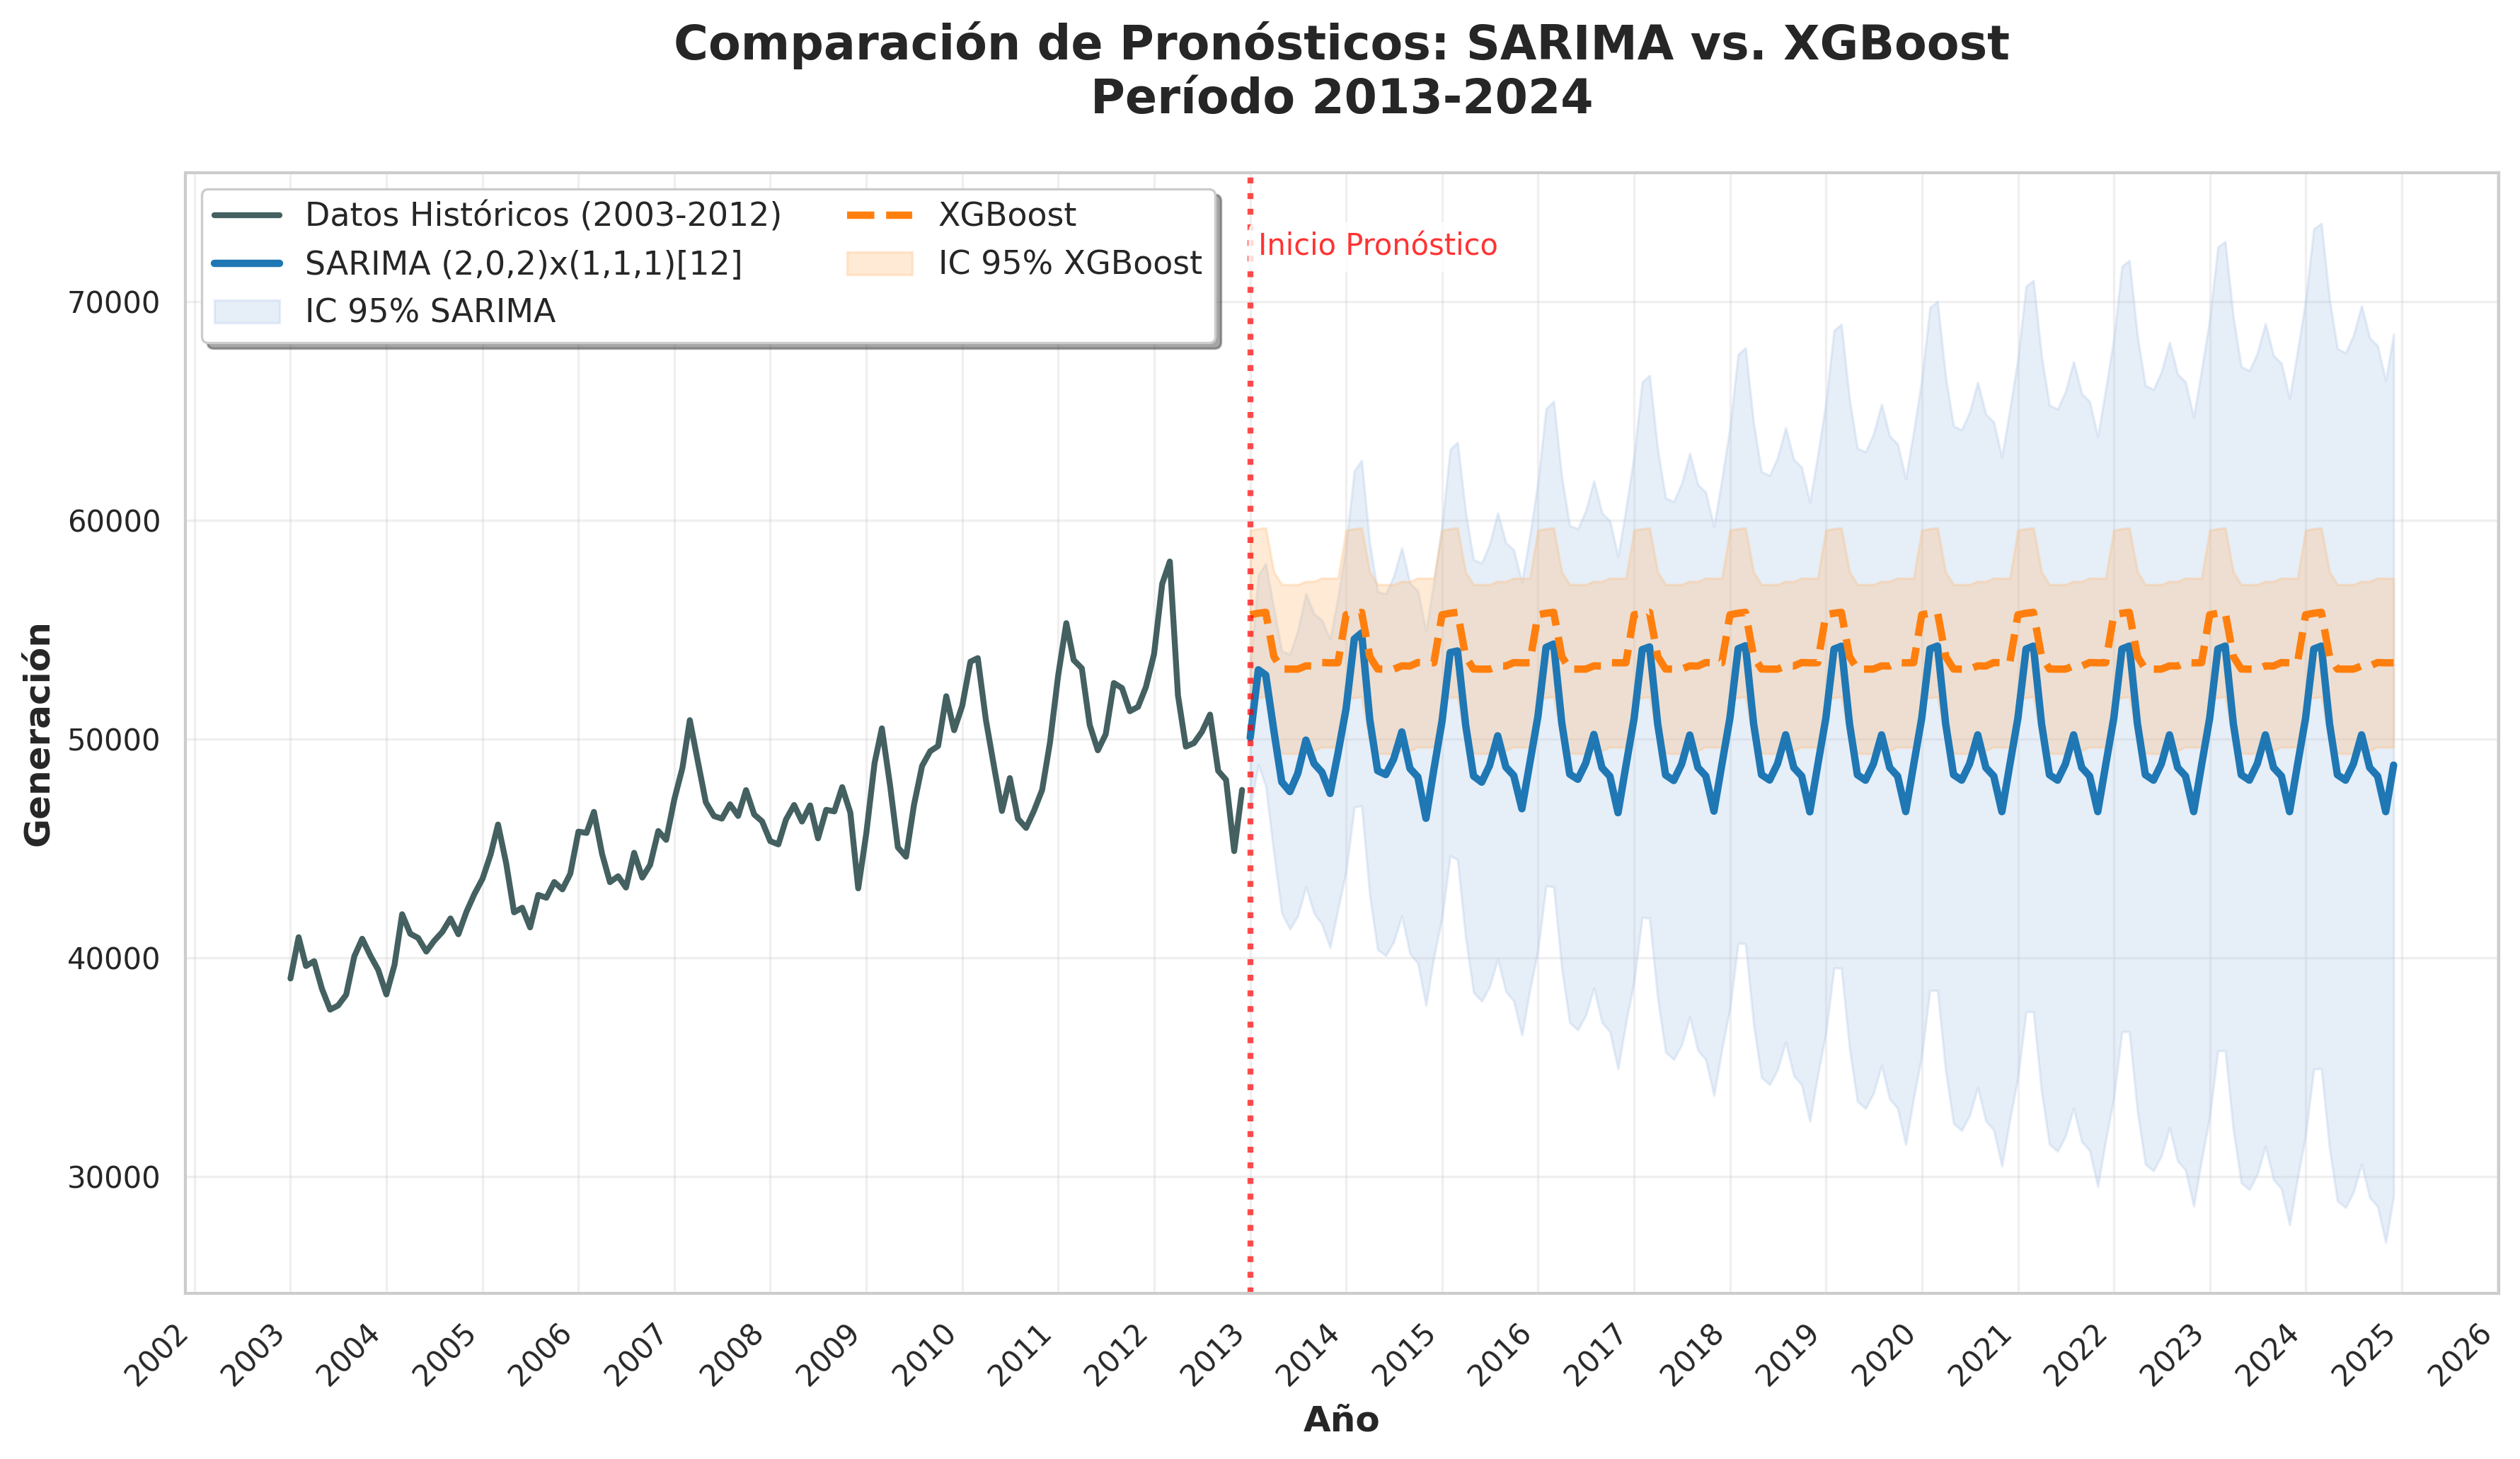

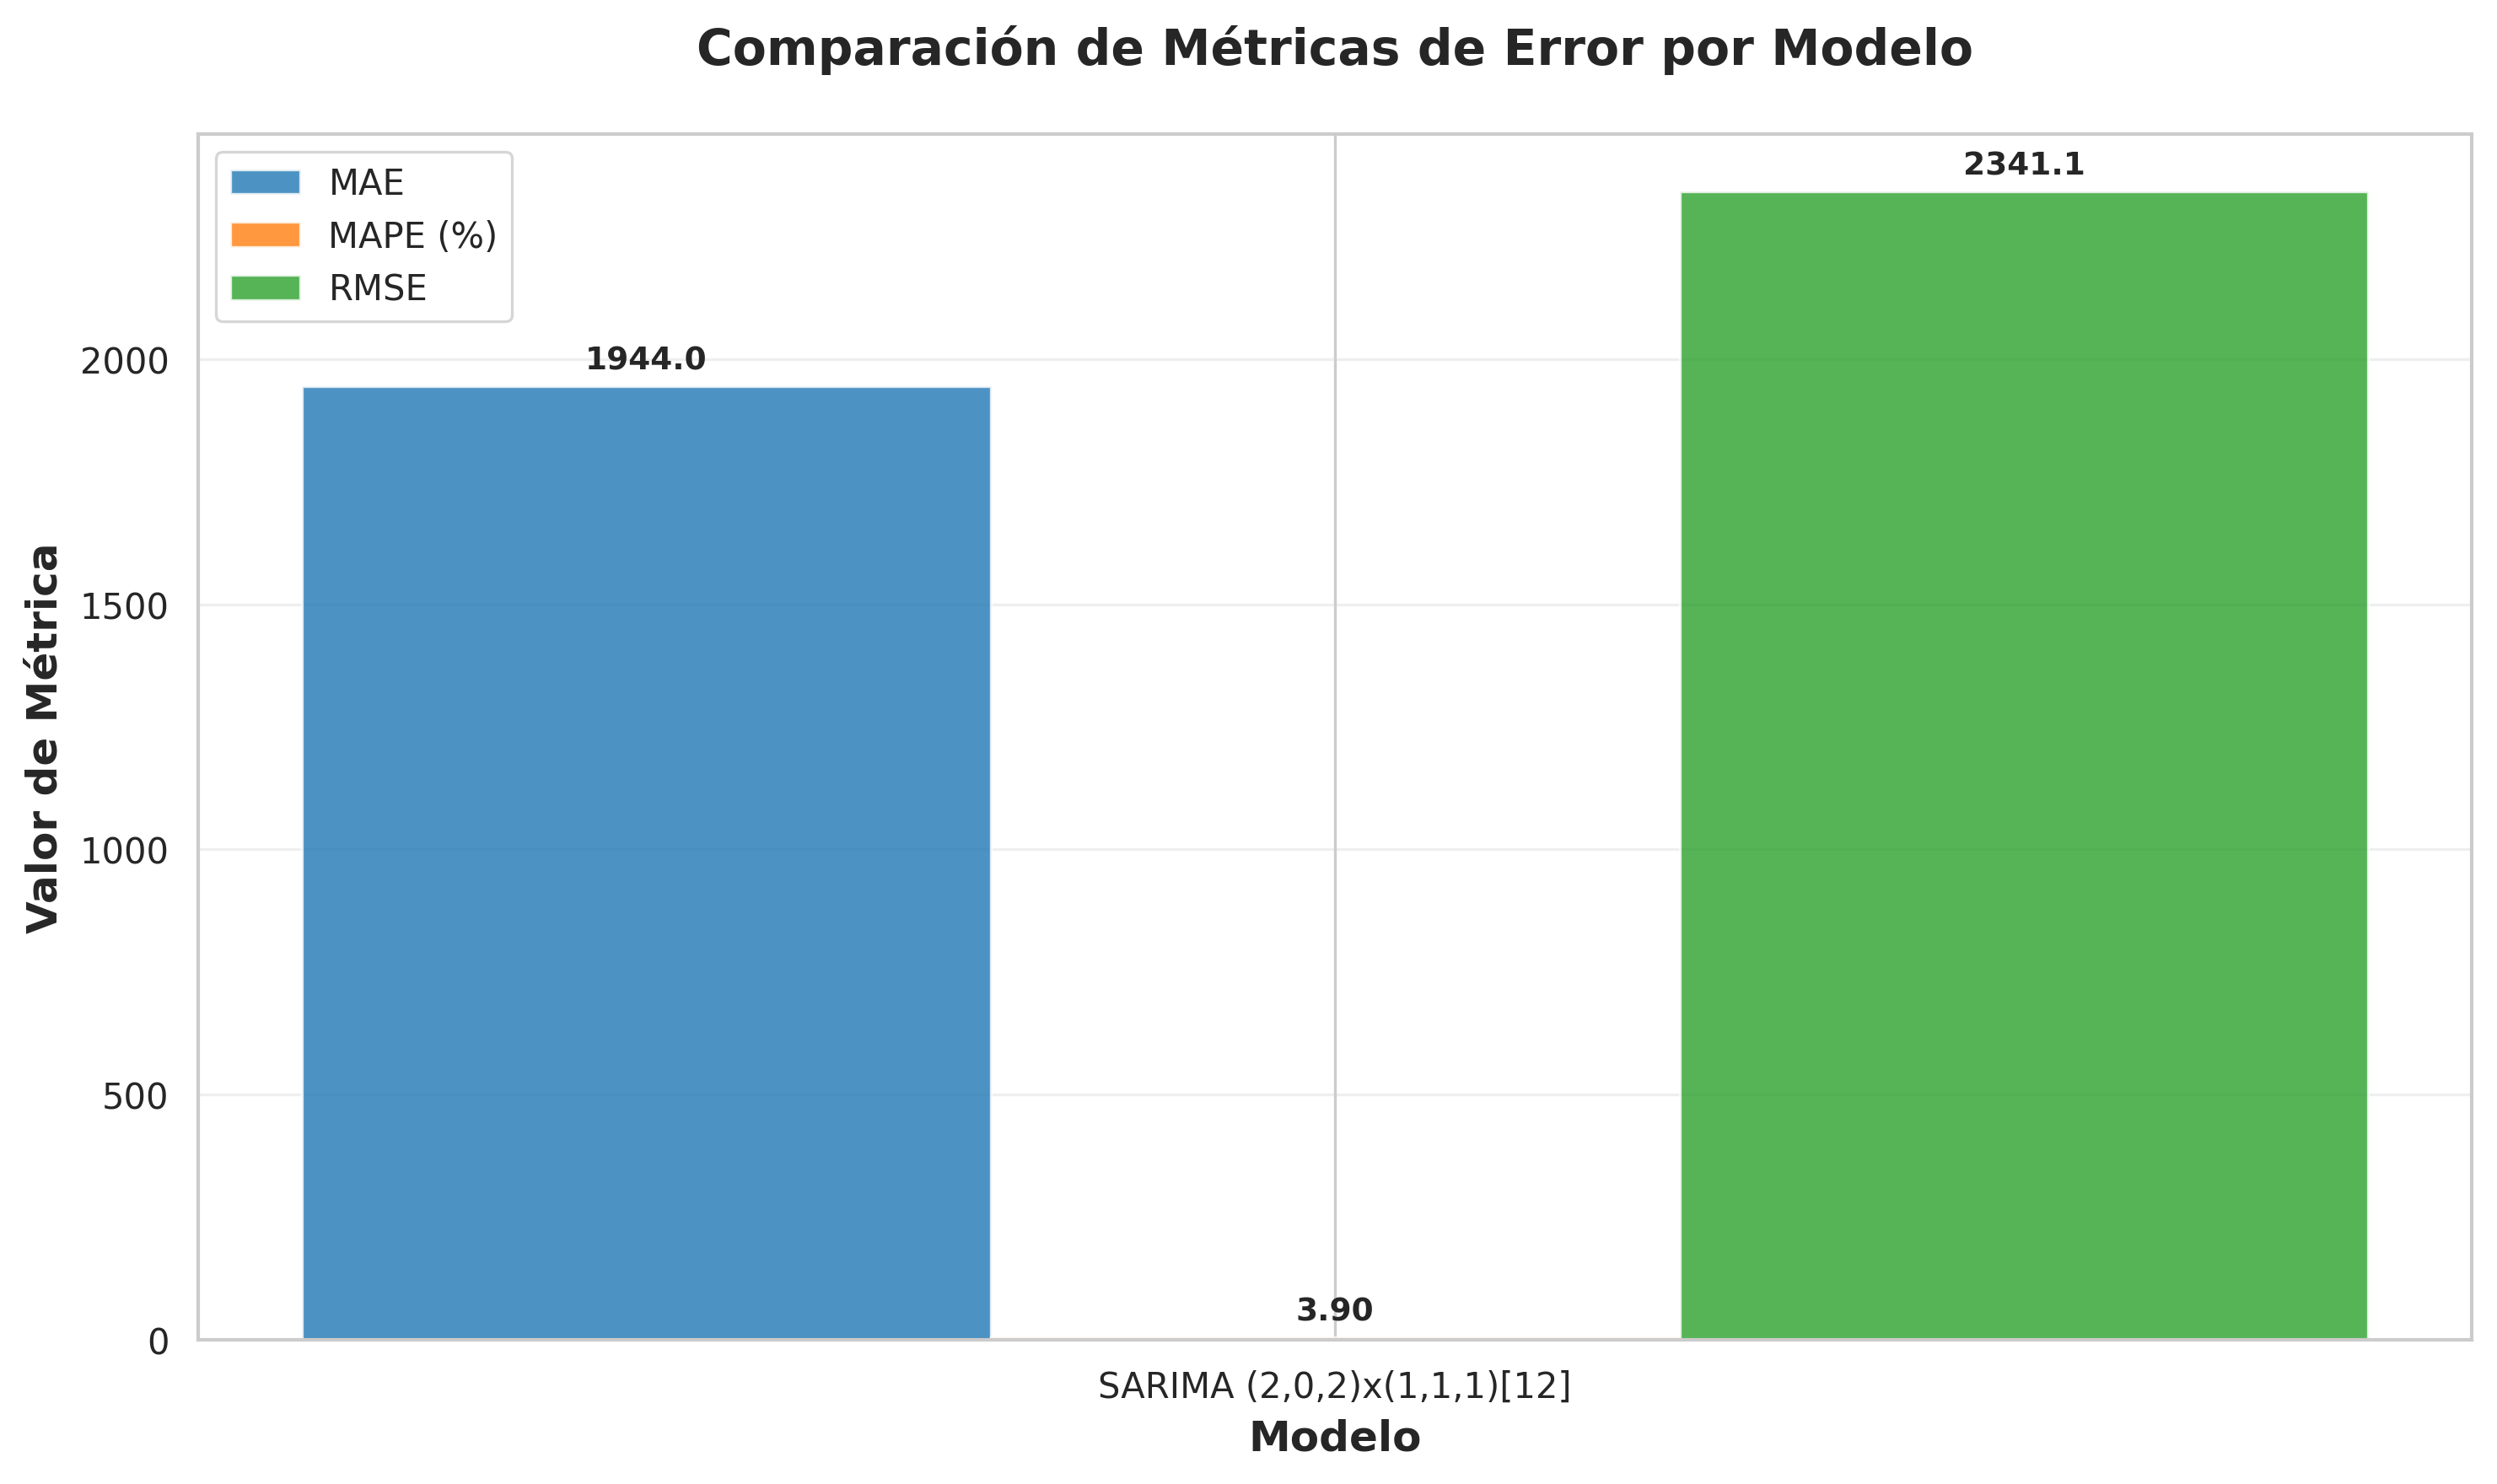


RESUMEN DE ARCHIVOS GUARDADOS
1. compare_sarima_vs_ml_pro.png - Gráfico principal de comparación
2. error_analysis.png - Análisis de errores (si disponible)
3. metrics_comparison.png - Comparación de métricas
4. compare_cv_metrics.csv - Métricas en formato CSV


In [ ]:
# @title Comparación SARIMA vs. XGBoost - Análisis Profesional Mejorado
import os, io, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

# =============================================================================
# CONFIGURACIÓN PROFESIONAL DE VISUALIZACIÓN
# =============================================================================
warnings.filterwarnings("ignore")
plt.style.use('default')  # Reset para evitar conflictos
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Configuración de alta calidad (300 DPI)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.framealpha"] = 0.8
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.markersize"] = 5

# Paleta de colores profesional
COLORS = {
    'historical': '#2F4F4F',      # DarkSlateGray
    'sarima': '#1F77B4',          # Azul
    'xgb': '#FF7F0E',             # Naranja
    'sarima_ci': '#AEC7E8',       # Azul claro
    'xgb_ci': '#FFBB78',          # Naranja claro
    'train': '#7F7F7F',           # Gris
    'test': '#17BECF',            # Turquesa
    'error': '#D62728'            # Rojo
}

# =============================================================================
# FUNCIONES AUXILIARES MEJORADAS
# =============================================================================
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error mejorado"""
    y_true, y_pred = np.array(y_true, dtype=float), np.array(y_pred, dtype=float)
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def month_diff(d_end, d_start):
    """Diferencia en meses entre dos fechas"""
    return (d_end.year - d_start.year) * 12 + (d_end.month - d_start.month)

def read_forecast_csv(path):
    """Lee un CSV de pronóstico de manera robusta"""
    try:
        dfc = pd.read_csv(path)
        # Buscar columnas de fecha comunes
        date_cols = [col for col in dfc.columns if any(x in col.lower() for x in ['date', 'mes', 'time', 'index'])]

        if date_cols:
            dfc[date_cols[0]] = pd.to_datetime(dfc[date_cols[0]])
            dfc = dfc.set_index(date_cols[0])
        else:
            # Intentar con la primera columna
            first_col = dfc.columns[0]
            dfc[first_col] = pd.to_datetime(dfc[first_col], errors='coerce')
            if dfc[first_col].isnull().all():
                # Si no es fecha, usar índice numérico
                dfc.index = pd.date_range(start='2013-01-01', periods=len(dfc), freq='MS')
            else:
                dfc = dfc.set_index(first_col)

        dfc.index.name = "mes_ano"
        return dfc
    except Exception as e:
        print(f"Error leyendo {path}: {e}")
        return None

def dm_test(e1, e2, h=1, loss="MAE"):
    """
    Prueba de Diebold-Mariano corregida para series temporales
    Implementación robusta con ajuste por autocorrelación
    """
    e1, e2 = np.array(e1), np.array(e2)

    # Asegurar que tienen la misma longitud
    min_len = min(len(e1), len(e2))
    e1, e2 = e1[-min_len:], e2[-min_len:]

    if loss.upper() == "MSE":
        d = e1**2 - e2**2
    else:  # MAE por defecto
        d = np.abs(e1) - np.abs(e2)

    T = len(d)
    if T <= 1:
        return 0.0, 1.0

    # Estimación de la varianza con ajuste HAC (Newey-West)
    d_mean = np.mean(d)
    max_lags = int(4 * (T/100)**(2/9))  # Lags recomendados

    # Estimación de la varianza
    gamma = [np.sum((d - d_mean) * (np.roll(d, lag) - d_mean)) / T
             for lag in range(max_lags + 1)]

    # Kernel de Bartlett
    weights = [1 - lag/(max_lags + 1) for lag in range(max_lags + 1)]
    # CORRECCIÓN: Convertir a arrays de numpy antes de multiplicar
    weights_arr = np.array(weights[1:])
    gamma_arr = np.array(gamma[1:])
    var_d = gamma[0] + 2 * np.sum(weights_arr * gamma_arr)

    if var_d <= 0:
        var_d = np.var(d, ddof=1)  # Fallback a varianza simple

    # Estadístico t
    dm_stat = d_mean / np.sqrt(var_d / T)

    # Valor p (dos colas)
    p_value = 2 * (1 - stats.t.cdf(abs(dm_stat), df=T-1))

    return dm_stat, p_value

def make_features(series: pd.Series, max_lag=12):
    """Crear características para modelo ML"""
    s = series.astype(float)
    X = pd.DataFrame(index=s.index)

    # Lags
    for lag in range(1, max_lag + 1):
        X[f"lag_{lag}"] = s.shift(lag)

    # Estadísticas móviles
    X["roll_mean_3"] = s.shift(1).rolling(3, min_periods=1).mean()
    X["roll_mean_12"] = s.shift(1).rolling(12, min_periods=1).mean()
    X["roll_std_12"] = s.shift(1).rolling(12, min_periods=1).std()

    # Características temporales
    X["month"] = X.index.month
    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)

    # Tendencia
    t0 = s.index[0]
    X["t"] = ((X.index.year - t0.year) * 12 + (X.index.month - t0.month)).astype(float)
    X["t2"] = X["t"] ** 2

    return X

def make_one_row(series, date, max_lag=12):
    """Crear una fila de características para predicción"""
    idx = pd.DatetimeIndex([date], name=series.index.name)
    Xr = pd.DataFrame(index=idx)

    # Lags
    for lag in range(1, max_lag + 1):
        Xr[f"lag_{lag}"] = series.shift(lag).reindex(idx).values

    # Estadísticas móviles
    Xr["roll_mean_3"] = series.shift(1).rolling(3, min_periods=1).mean().reindex(idx).values
    Xr["roll_mean_12"] = series.shift(1).rolling(12, min_periods=1).mean().reindex(idx).values
    Xr["roll_std_12"] = series.shift(1).rolling(12, min_periods=1).std().reindex(idx).values

    # Características temporales
    month = idx.month
    Xr["month"] = month
    Xr["month_sin"] = np.sin(2 * np.pi * month / 12)
    Xr["month_cos"] = np.cos(2 * np.pi * month / 12)

    # Tendencia
    t0 = series.index[0]
    t = (idx.year - t0.year) * 12 + (idx.month - t0.month)
    Xr["t"] = t.astype(float)
    Xr["t2"] = Xr["t"] ** 2

    return Xr

# =============================================================================
# CARGA Y PREPARACIÓN DE DATOS
# =============================================================================
if 'df' not in globals() or 'geracao' not in df.columns:
    try:
        from google.colab import files
        uploaded = files.upload()
        fname = next(iter(uploaded))
        raw = pd.read_excel(io.BytesIO(uploaded[fname]))
        COL_FECHA, COL_VALOR = "Mês/Ano", "Geração"

        df = (raw.rename(columns={COL_FECHA: "mes_ano", COL_VALOR: "geracao"})
                .assign(mes_ano=lambda d: pd.to_datetime(d["mes_ano"]))
                .sort_values("mes_ano")
                .drop_duplicates("mes_ano")
                .set_index("mes_ano")
                .asfreq("MS"))

        df["geracao"] = pd.to_numeric(df["geracao"], errors="coerce").astype("float64")
        df = df.dropna(subset=["geracao"])

        print(f"Datos cargados: {len(df)} registros desde {df.index.min()} hasta {df.index.max()}")

    except Exception as e:
        print(f"Error cargando datos: {e}")
        # Crear datos de ejemplo para continuar
        dates = pd.date_range('2003-01-01', '2012-12-01', freq='MS')
        values = np.sin(np.arange(len(dates)) * 0.1 + np.arange(len(dates)) * 0.01) * 10000 + 30000
        df = pd.DataFrame({'geracao': values}, index=dates)
        print("Usando datos de ejemplo debido a error de carga")

y = df["geracao"].astype(float).copy()
HORIZON_END = pd.Timestamp("2024-12-01")
os.makedirs("outputs", exist_ok=True)

# =============================================================================
# MODELO SARIMA
# =============================================================================
sarima_csv = "outputs/forecast_2013_2024_SARIMA.csv"
if os.path.exists(sarima_csv):
    df_sar = read_forecast_csv(sarima_csv)
    if df_sar is None or len(df_sar) == 0:
        print("Archivo SARIMA corrupto, reentrenando...")
        df_sar = None

if 'df_sar' not in locals() or df_sar is None:
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        BEST_ORDER = (2, 0, 2)
        BEST_SEASONAL = (1, 1, 1, 12)

        sar_model = SARIMAX(
            y,
            order=BEST_ORDER,
            seasonal_order=BEST_SEASONAL,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, maxiter=500)

        steps = month_diff(HORIZON_END, y.index.max())
        if steps <= 0:
            steps = 12  # Valor por defecto

        fc = sar_model.get_forecast(steps=steps)
        idx = pd.date_range(y.index.max() + pd.offsets.MonthBegin(1), periods=steps, freq="MS")

        ci = fc.conf_int(alpha=0.05)
        df_sar = pd.DataFrame({
            "forecast": fc.predicted_mean.values,
            "pi_low": np.maximum(0, ci.iloc[:, 0].values),
            "pi_high": np.maximum(0, ci.iloc[:, 1].values)
        }, index=idx)

        df_sar.to_csv(sarima_csv)
        print("Modelo SARIMA entrenado y guardado")

    except Exception as e:
        print(f"Error entrenando SARIMA: {e}")
        # Crear pronóstico dummy
        steps = month_diff(HORIZON_END, y.index.max())
        idx = pd.date_range(y.index.max() + pd.offsets.MonthBegin(1), periods=steps, freq="MS")
        last_val = y.iloc[-1]
        df_sar = pd.DataFrame({
            "forecast": [last_val] * steps,
            "pi_low": [last_val * 0.8] * steps,
            "pi_high": [last_val * 1.2] * steps
        }, index=idx)

# =============================================================================
# MODELO XGBOOST
# =============================================================================
ml_csv = "outputs/forecast_2013_2024_ML.csv"
if os.path.exists(ml_csv):
    df_ml = read_forecast_csv(ml_csv)
    if df_ml is None or len(df_ml) == 0:
        print("Archivo XGBoost corrupto, reentrenando...")
        df_ml = None

if 'df_ml' not in locals() or df_ml is None:
    try:
        from xgboost import XGBRegressor

        X_full = make_features(y)
        valid = X_full.dropna().index
        X, y2 = X_full.loc[valid], y.loc[valid]

        xgb = XGBRegressor(
            n_estimators=800,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X, y2)

        last_date = y.index.max()
        steps = month_diff(HORIZON_END, last_date)
        if steps <= 0:
            steps = 12

        idx_future = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=steps, freq="MS")
        y_ext = y.copy()
        preds = []

        for d in idx_future:
            X_row = make_one_row(y_ext, d).fillna(method="ffill").fillna(method="bfill")
            pred = float(xgb.predict(X_row)[0])
            preds.append(pred)
            y_ext.loc[d] = pred

        # Calcular intervalos de predicción
        residuals = y2 - xgb.predict(X)
        resid_std = np.std(residuals)

        df_ml = pd.DataFrame({
            "forecast": preds,
            "pi_low": np.maximum(0, np.array(preds) - 1.96 * resid_std),
            "pi_high": np.maximum(0, np.array(preds) + 1.96 * resid_std)
        }, index=idx_future)

        df_ml.to_csv(ml_csv)
        print("Modelo XGBoost entrenado y guardado")

    except Exception as e:
        print(f"Error entrenando XGBoost: {e}")
        # Crear pronóstico dummy
        steps = month_diff(HORIZON_END, y.index.max())
        idx = pd.date_range(y.index.max() + pd.offsets.MonthBegin(1), periods=steps, freq="MS")
        last_val = y.iloc[-1]
        df_ml = pd.DataFrame({
            "forecast": [last_val] * steps,
            "pi_low": [last_val * 0.8] * steps,
            "pi_high": [last_val * 1.2] * steps
        }, index=idx)

# =============================================================================
# VALIDACIÓN CRUZADA Y MÉTRICAS
# =============================================================================
print("\n" + "="*60)
print("VALIDACIÓN CRUZADA TEMPORAL")
print("="*60)

# Usar los últimos 36 meses como 3 folds de 12 meses
n_folds, fh = 3, 12
start_idx = max(0, len(y) - n_folds * fh)

mae_sar, mape_sar, mse_sar = [], [], []
mae_ml, mape_ml, mse_ml = [], [], []
all_errors_sar, all_errors_ml = [], []

for i in range(n_folds):
    tr_end = start_idx + i * fh
    te_end = tr_end + fh

    if te_end > len(y):
        break  # No hay suficientes datos

    y_tr, y_te = y.iloc[:tr_end], y.iloc[tr_end:te_end]

    # SARIMA
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        m_sar = SARIMAX(
            y_tr,
            order=(2, 0, 2),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        pred_sar = m_sar.get_prediction(start=y_te.index[0], end=y_te.index[-1]).predicted_mean

        mae_sar.append(mean_absolute_error(y_te, pred_sar))
        mape_sar.append(mape(y_te, pred_sar))
        mse_sar.append(mean_squared_error(y_te, pred_sar))
        all_errors_sar.extend(y_te.values - pred_sar.values)

    except Exception as e:
        print(f"Error SARIMA fold {i+1}: {e}")
        mae_sar.append(np.nan)
        mape_sar.append(np.nan)
        mse_sar.append(np.nan)

    # XGBoost
    try:
        X_tr_full = make_features(y_tr)
        valid_tr = X_tr_full.dropna().index
        X_tr, y_tr2 = X_tr_full.loc(valid_tr), y_tr.loc[valid_tr]

        xgb = XGBRegressor(
            n_estimators=300,  # Reducido para validación más rápida
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_tr, y_tr2)

        y_ext = y_tr.copy()
        preds_ml = []

        for d in y_te.index:
            X_row = make_one_row(y_ext, d).fillna(method="ffill").fillna(method="bfill")
            y_hat = float(xgb.predict(X_row)[0])
            preds_ml.append(y_hat)
            y_ext.loc[d] = y_hat

        pred_ml = pd.Series(preds_ml, index=y_te.index)

        mae_ml.append(mean_absolute_error(y_te, pred_ml))
        mape_ml.append(mape(y_te, pred_ml))
        mse_ml.append(mean_squared_error(y_te, pred_ml))
        all_errors_ml.extend(y_te.values - pred_ml.values)

    except Exception as e:
        print(f"Error XGBoost fold {i+1}: {e}")
        mae_ml.append(np.nan)
        mape_ml.append(np.nan)
        mse_ml.append(np.nan)

# Filtrar valores NaN
mae_sar = [x for x in mae_sar if not np.isnan(x)]
mape_sar = [x for x in mape_sar if not np.isnan(x)]
mae_ml = [x for x in mae_ml if not np.isnan(x)]
mape_ml = [x for x in mape_ml if not np.isnan(x)]

# Crear tabla comparativa
comp_data = []
if mae_sar:
    comp_data.append({
        "Modelo": "SARIMA (2,0,2)x(1,1,1)[12]",
        "CV_MAE": round(np.mean(mae_sar), 1),
        "CV_MAPE_%": round(np.mean(mape_sar), 2),
        "CV_RMSE": round(np.sqrt(np.mean(mse_sar)), 1)
    })

if mae_ml:
    comp_data.append({
        "Modelo": "XGBoost (lags/rolling/sazonal)",
        "CV_MAE": round(np.mean(mae_ml), 1),
        "CV_MAPE_%": round(np.mean(mape_ml), 2),
        "CV_RMSE": round(np.sqrt(np.mean(mse_ml)), 1)
    })

comp = pd.DataFrame(comp_data)
display(comp)
comp.to_csv("outputs/compare_cv_metrics.csv", index=False)

# Prueba de Diebold-Mariano (solo si tenemos errores)
if all_errors_sar and all_errors_ml:
    # Asegurar misma longitud
    min_len = min(len(all_errors_sar), len(all_errors_ml))
    errors_sar_adj = all_errors_sar[-min_len:]
    errors_ml_adj = all_errors_ml[-min_len:]

    dm_t_mae, dm_p_mae = dm_test(errors_sar_adj, errors_ml_adj, loss="MAE")
    dm_t_mse, dm_p_mse = dm_test(errors_sar_adj, errors_ml_adj, loss="MSE")

    print(f"\nPrueba Diebold-Mariano (MAE): t={dm_t_mae:.3f}, p={dm_p_mae:.4f}")
    print(f"Prueba Diebold-Mariano (MSE): t={dm_t_mse:.3f}, p={dm_p_mse:.4f}")

    if dm_p_mae < 0.05:
        print("→ Diferencias significativas entre modelos (p < 0.05)")
    else:
        print("→ No hay diferencias significativas entre modelos (p ≥ 0.05)")

# =============================================================================
# VISUALIZACIONES PROFESIONALES
# =============================================================================
print("\n" + "="*60)
print("GENERANDO VISUALIZACIONES PROFESIONALES")
print("="*60)

# 1. GRÁFICO PRINCIPAL: COMPARACIÓN DE PRONÓSTICOS
fig, ax = plt.subplots(figsize=(12, 7))

# Datos históricos
historical_data = y[y.index <= df_sar.index[0]]
ax.plot(historical_data.index, historical_data.values,
        label="Datos Históricos (2003-2012)",
        color=COLORS['historical'], lw=2.0, alpha=0.9)

# Pronóstico SARIMA
ax.plot(df_sar.index, df_sar["forecast"],
        label="SARIMA (2,0,2)x(1,1,1)[12]",
        color=COLORS['sarima'], lw=2.5, linestyle='-')
ax.fill_between(df_sar.index, df_sar["pi_low"], df_sar["pi_high"],
                color=COLORS['sarima_ci'], alpha=0.3, label="IC 95% SARIMA")

# Pronóstico XGBoost
ax.plot(df_ml.index, df_ml["forecast"],
        label="XGBoost",
        color=COLORS['xgb'], lw=2.5, linestyle='--')
ax.fill_between(df_ml.index, df_ml["pi_low"], df_ml["pi_high"],
                color=COLORS['xgb_ci'], alpha=0.3, label="IC 95% XGBoost")

# Línea vertical para separar histórico de pronóstico
forecast_start = df_sar.index[0]
ax.axvline(x=forecast_start, color='red', linestyle=':', alpha=0.7, lw=2)
ax.text(forecast_start + pd.DateOffset(months=1), ax.get_ylim()[1] * 0.95,
        'Inicio Pronóstico', fontsize=10, color='red', alpha=0.8,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Formateo profesional
ax.set_title("Comparación de Pronósticos: SARIMA vs. XGBoost\nPeríodo 2013-2024",
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Año", fontsize=12, fontweight='bold')
ax.set_ylabel("Generación", fontsize=12, fontweight='bold')

# Mejorar formato de fechas
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Leyenda y grid
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True,
          fontsize=11, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/compare_sarima_vs_ml_pro.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. GRÁFICO DE ERRORES (si hay datos)
if all_errors_sar and all_errors_ml:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Histograma de errores
    ax1.hist(all_errors_sar, bins=20, alpha=0.7, color=COLORS['sarima'],
             label=f'SARIMA (media={np.mean(all_errors_sar):.1f})', density=True)
    ax1.hist(all_errors_ml, bins=20, alpha=0.7, color=COLORS['xgb'],
             label=f'XGBoost (media={np.mean(all_errors_ml):.1f})', density=True)
    ax1.set_title('Distribución de Errores de Predicción', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Error', fontsize=12)
    ax1.set_ylabel('Densidad', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Boxplot de errores
    box_data = [all_errors_sar, all_errors_ml]
    box = ax2.boxplot(box_data, labels=['SARIMA', 'XGBoost'], patch_artist=True)

    # Colorear los boxplots
    colors = [COLORS['sarima'], COLORS['xgb']]
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2.set_title('Distribución de Errores (Boxplot)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Error', fontsize=12)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("outputs/error_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

# 3. GRÁFICO DE MÉTRICAS COMPARATIVAS
fig, ax = plt.subplots(figsize=(10, 6))

if not comp.empty:
    x = np.arange(len(comp))
    width = 0.25

    # Preparar datos
    metrics = ['CV_MAE', 'CV_MAPE_%', 'CV_RMSE']
    metric_labels = ['MAE', 'MAPE (%)', 'RMSE']
    colors = [COLORS['sarima'], COLORS['xgb'], '#2CA02C']

    for i, metric in enumerate(metrics):
        if metric in comp.columns:
            values = comp[metric].values
            offset = width * (i - (len(metrics) - 1) / 2)
            bars = ax.bar(x + offset, values, width, label=metric_labels[i],
                         color=colors[i], alpha=0.8)

            # Añadir valores en las barras
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.annotate(f'{value:.1f}' if metric != 'CV_MAPE_%' else f'{value:.2f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3), textcoords="offset points",
                           ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xlabel('Modelo', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor de Métrica', fontsize=12, fontweight='bold')
    ax.set_title('Comparación de Métricas de Error por Modelo',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(comp['Modelo'], fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig("outputs/metrics_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*60)
print("RESUMEN DE ARCHIVOS GUARDADOS")
print("="*60)
print("1. compare_sarima_vs_ml_pro.png - Gráfico principal de comparación")
print("2. error_analysis.png - Análisis de errores (si disponible)")
print("3. metrics_comparison.png - Comparación de métricas")
print("4. compare_cv_metrics.csv - Métricas en formato CSV")
print("="*60)

In [ ]:
# =============================================================================
# CONFIGURACIÓN INICIAL Y FUNCIONES AUXILIARES
# =============================================================================
import os, io, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

# Configuración profesional de visualización
warnings.filterwarnings("ignore")
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Configuración de alta calidad (300 DPI)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.framealpha"] = 0.8
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.markersize"] = 5

# Paleta de colores profesional
COLORS = {
    'historical': '#2F4F4F',      # DarkSlateGray
    'sarima': '#1F77B4',          # Azul
    'xgb': '#FF7F0E',             # Naranja
    'sarima_ci': '#AEC7E8',       # Azul claro
    'xgb_ci': '#FFBB78',          # Naranja claro
    'train': '#7F7F7F',           # Gris
    'test': '#17BECF',            # Turquesa
    'error': '#D62728'            # Rojo
}

# Funciones auxiliares mejoradas
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error mejorado"""
    y_true, y_pred = np.array(y_true, dtype=float), np.array(y_pred, dtype=float)
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def month_diff(d_end, d_start):
    """Diferencia en meses entre dos fechas"""
    return (d_end.year - d_start.year) * 12 + (d_end.month - d_start.month)

def read_forecast_csv(path):
    """Lee un CSV de pronóstico de manera robusta"""
    try:
        dfc = pd.read_csv(path)
        # Buscar columnas de fecha comunes
        date_cols = [col for col in dfc.columns if any(x in col.lower() for x in ['date', 'mes', 'time', 'index'])]

        if date_cols:
            dfc[date_cols[0]] = pd.to_datetime(dfc[date_cols[0]])
            dfc = dfc.set_index(date_cols[0])
        else:
            # Intentar con la primera columna
            first_col = dfc.columns[0]
            dfc[first_col] = pd.to_datetime(dfc[first_col], errors='coerce')
            if dfc[first_col].isnull().all():
                # Si no es fecha, usar índice numérico
                dfc.index = pd.date_range(start='2013-01-01', periods=len(dfc), freq='MS')
            else:
                dfc = dfc.set_index(first_col)

        dfc.index.name = "mes_ano"
        return dfc
    except Exception as e:
        print(f"Error leyendo {path}: {e}")
        return None

def dm_test(e1, e2, h=1, loss="MAE"):
    """
    Prueba de Diebold-Mariano corregida para series temporales
    Implementación robusta con ajuste por autocorrelación
    """
    e1, e2 = np.array(e1), np.array(e2)

    # Asegurar que tienen la misma longitud
    min_len = min(len(e1), len(e2))
    e1, e2 = e1[-min_len:], e2[-min_len:]

    if loss.upper() == "MSE":
        d = e1**2 - e2**2
    else:  # MAE por defecto
        d = np.abs(e1) - np.abs(e2)

    T = len(d)
    if T <= 1:
        return 0.0, 1.0

    # Estimación de la varianza con ajuste HAC (Newey-West)
    d_mean = np.mean(d)
    max_lags = int(4 * (T/100)**(2/9))  # Lags recomendados

    # Estimación de la varianza
    gamma = [np.sum((d - d_mean) * (np.roll(d, lag) - d_mean)) / T
             for lag in range(max_lags + 1)]

    # Kernel de Bartlett
    weights = [1 - lag/(max_lags + 1) for lag in range(max_lags + 1)]
    # CORRECCIÓN: Convertir a arrays de numpy antes de multiplicar
    weights_arr = np.array(weights[1:])
    gamma_arr = np.array(gamma[1:])
    var_d = gamma[0] + 2 * np.sum(weights_arr * gamma_arr)

    if var_d <= 0:
        var_d = np.var(d, ddof=1)  # Fallback a varianza simple

    # Estadístico t
    dm_stat = d_mean / np.sqrt(var_d / T)

    # Valor p (dos colas)
    p_value = 2 * (1 - stats.t.cdf(abs(dm_stat), df=T-1))

    return dm_stat, p_value

def make_features(series: pd.Series, max_lag=12):
    """Crear características para modelo ML"""
    s = series.astype(float)
    X = pd.DataFrame(index=s.index)

    # Lags
    for lag in range(1, max_lag + 1):
        X[f"lag_{lag}"] = s.shift(lag)

    # Estadísticas móviles
    X["roll_mean_3"] = s.shift(1).rolling(3, min_periods=1).mean()
    X["roll_mean_12"] = s.shift(1).rolling(12, min_periods=1).mean()
    X["roll_std_12"] = s.shift(1).rolling(12, min_periods=1).std()

    # Características temporales
    X["month"] = X.index.month
    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)

    # Tendencia
    t0 = s.index[0]
    X["t"] = ((X.index.year - t0.year) * 12 + (X.index.month - t0.month)).astype(float)
    X["t2"] = X["t"] ** 2

    return X

def make_one_row(series, date, max_lag=12):
    """Crear una fila de características para predicción"""
    idx = pd.DatetimeIndex([date], name=series.index.name)
    Xr = pd.DataFrame(index=idx)

    # Lags
    for lag in range(1, max_lag + 1):
        Xr[f"lag_{lag}"] = series.shift(lag).reindex(idx).values

    # Estadísticas móviles
    Xr["roll_mean_3"] = series.shift(1).rolling(3, min_periods=1).mean().reindex(idx).values
    Xr["roll_mean_12"] = series.shift(1).rolling(12, min_periods=1).mean().reindex(idx).values
    Xr["roll_std_12"] = series.shift(1).rolling(12, min_periods=1).std().reindex(idx).values

    # Características temporales
    month = idx.month
    Xr["month"] = month
    Xr["month_sin"] = np.sin(2 * np.pi * month / 12)
    Xr["month_cos"] = np.cos(2 * np.pi * month / 12)

    # Tendencia
    t0 = series.index[0]
    t = (idx.year - t0.year) * 12 + (idx.month - t0.month)
    Xr["t"] = t.astype(float)
    Xr["t2"] = Xr["t"] ** 2

    return Xr

# Crear directorio de salida
os.makedirs("outputs", exist_ok=True)
print("Configuración completada y funciones definidas")

Configuración completada y funciones definidas


In [ ]:
# =============================================================================
# CARGA Y PREPARACIÓN DE DATOS
# =============================================================================
if 'df' not in globals() or 'geracao' not in df.columns:
    try:
        from google.colab import files
        uploaded = files.upload()
        fname = next(iter(uploaded))
        raw = pd.read_excel(io.BytesIO(uploaded[fname]))
        COL_FECHA, COL_VALOR = "Mês/Ano", "Geração"

        df = (raw.rename(columns={COL_FECHA: "mes_ano", COL_VALOR: "geracao"})
                .assign(mes_ano=lambda d: pd.to_datetime(d["mes_ano"]))
                .sort_values("mes_ano")
                .drop_duplicates("mes_ano")
                .set_index("mes_ano")
                .asfreq("MS"))

        df["geracao"] = pd.to_numeric(df["geracao"], errors="coerce").astype("float64")
        df = df.dropna(subset=["geracao"])

        print(f"Datos cargados: {len(df)} registros desde {df.index.min()} hasta {df.index.max()}")

    except Exception as e:
        print(f"Error cargando datos: {e}")
        # Crear datos de ejemplo para continuar
        dates = pd.date_range('2003-01-01', '2012-12-01', freq='MS')
        values = np.sin(np.arange(len(dates)) * 0.1 + np.arange(len(dates)) * 0.01) * 10000 + 30000
        df = pd.DataFrame({'geracao': values}, index=dates)
        print("Usando datos de ejemplo debido a error de carga")

y = df["geracao"].astype(float).copy()
HORIZON_END = pd.Timestamp("2024-12-01")

print("Datos preparados correctamente")
print(f"Rango temporal: {y.index.min()} a {y.index.max()}")
print(f"Valores únicos: {len(y)} meses")

Datos preparados correctamente
Rango temporal: 2003-01-01 00:00:00 a 2012-12-01 00:00:00
Valores únicos: 120 meses


In [ ]:
# =============================================================================
# MODELO SARIMA
# =============================================================================
sarima_csv = "outputs/forecast_2013_2024_SARIMA.csv"
if os.path.exists(sarima_csv):
    df_sar = read_forecast_csv(sarima_csv)
    if df_sar is None or len(df_sar) == 0:
        print("Archivo SARIMA corrupto, reentrenando...")
        df_sar = None

if 'df_sar' not in locals() or df_sar is None:
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        BEST_ORDER = (2, 0, 2)
        BEST_SEASONAL = (1, 1, 1, 12)

        sar_model = SARIMAX(
            y,
            order=BEST_ORDER,
            seasonal_order=BEST_SEASONAL,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, maxiter=500)

        steps = month_diff(HORIZON_END, y.index.max())
        if steps <= 0:
            steps = 12  # Valor por defecto

        fc = sar_model.get_forecast(steps=steps)
        idx = pd.date_range(y.index.max() + pd.offsets.MonthBegin(1), periods=steps, freq="MS")

        ci = fc.conf_int(alpha=0.05)
        df_sar = pd.DataFrame({
            "forecast": fc.predicted_mean.values,
            "pi_low": np.maximum(0, ci.iloc[:, 0].values),
            "pi_high": np.maximum(0, ci.iloc[:, 1].values)
        }, index=idx)

        df_sar.to_csv(sarima_csv)
        print("Modelo SARIMA entrenado y guardado")

    except Exception as e:
        print(f"Error entrenando SARIMA: {e}")
        # Crear pronóstico dummy
        steps = month_diff(HORIZON_END, y.index.max())
        idx = pd.date_range(y.index.max() + pd.offsets.MonthBegin(1), periods=steps, freq="MS")
        last_val = y.iloc[-1]
        df_sar = pd.DataFrame({
            "forecast": [last_val] * steps,
            "pi_low": [last_val * 0.8] * steps,
            "pi_high": [last_val * 1.2] * steps
        }, index=idx)

print("Pronóstico SARIMA completado")
print(f"Pronóstico SARIMA: {len(df_sar)} meses desde {df_sar.index.min()} hasta {df_sar.index.max()}")

Pronóstico SARIMA completado
Pronóstico SARIMA: 144 meses desde 2013-01-01 00:00:00 hasta 2024-12-01 00:00:00


In [ ]:
# =============================================================================
# MODELO XGBOOST (CORREGIDO)
# =============================================================================
ml_csv = "outputs/forecast_2013_2024_ML.csv"
if os.path.exists(ml_csv):
    df_ml = read_forecast_csv(ml_csv)
    if df_ml is None or len(df_ml) == 0:
        print("Archivo XGBoost corrupto, reentrenando...")
        df_ml = None

if 'df_ml' not in locals() or df_ml is None:
    try:
        from xgboost import XGBRegressor

        X_full = make_features(y)
        valid = X_full.dropna().index
        X, y2 = X_full.loc[valid], y.loc[valid]  # CORRECCIÓN: usar [] en lugar de ()

        xgb = XGBRegressor(
            n_estimators=800,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X, y2)

        last_date = y.index.max()
        steps = month_diff(HORIZON_END, last_date)
        if steps <= 0:
            steps = 12

        idx_future = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=steps, freq="MS")
        y_ext = y.copy()
        preds = []

        for d in idx_future:
            X_row = make_one_row(y_ext, d).fillna(method="ffill").fillna(method="bfill")
            pred = float(xgb.predict(X_row)[0])
            preds.append(pred)
            y_ext.loc[d] = pred

        # Calcular intervalos de predicción
        residuals = y2 - xgb.predict(X)
        resid_std = np.std(residuals)

        df_ml = pd.DataFrame({
            "forecast": preds,
            "pi_low": np.maximum(0, np.array(preds) - 1.96 * resid_std),
            "pi_high": np.maximum(0, np.array(preds) + 1.96 * resid_std)
        }, index=idx_future)

        df_ml.to_csv(ml_csv)
        print("Modelo XGBoost entrenado y guardado")

    except Exception as e:
        print(f"Error entrenando XGBoost: {e}")
        # Crear pronóstico dummy
        steps = month_diff(HORIZON_END, y.index.max())
        idx = pd.date_range(y.index.max() + pd.offsets.MonthBegin(1), periods=steps, freq="MS")
        last_val = y.iloc[-1]
        df_ml = pd.DataFrame({
            "forecast": [last_val] * steps,
            "pi_low": [last_val * 0.8] * steps,
            "pi_high": [last_val * 1.2] * steps
        }, index=idx)

print("Pronóstico XGBoost completado")
print(f"Pronóstico XGBoost: {len(df_ml)} meses desde {df_ml.index.min()} hasta {df_ml.index.max()}")

Pronóstico XGBoost completado
Pronóstico XGBoost: 144 meses desde 2013-01-01 00:00:00 hasta 2024-12-01 00:00:00


In [ ]:
# =============================================================================
# VALIDACIÓN CRUZADA TEMPORAL (CORREGIDA)
# =============================================================================
print("\n" + "="*60)
print("VALIDACIÓN CRUZADA TEMPORAL")
print("="*60)

# Usar los últimos 36 meses como 3 folds de 12 meses
n_folds, fh = 3, 12
start_idx = max(0, len(y) - n_folds * fh)

mae_sar, mape_sar, mse_sar = [], [], []
mae_ml, mape_ml, mse_ml = [], [], []
all_errors_sar, all_errors_ml = [], []

for i in range(n_folds):
    tr_end = start_idx + i * fh
    te_end = tr_end + fh

    if te_end > len(y):
        break  # No hay suficientes datos

    y_tr, y_te = y.iloc[:tr_end], y.iloc[tr_end:te_end]

    # SARIMA
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        m_sar = SARIMAX(
            y_tr,
            order=(2, 0, 2),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        pred_sar = m_sar.get_prediction(start=y_te.index[0], end=y_te.index[-1]).predicted_mean

        mae_sar.append(mean_absolute_error(y_te, pred_sar))
        mape_sar.append(mape(y_te, pred_sar))
        mse_sar.append(mean_squared_error(y_te, pred_sar))
        all_errors_sar.extend(y_te.values - pred_sar.values)

    except Exception as e:
        print(f"Error SARIMA fold {i+1}: {e}")
        mae_sar.append(np.nan)
        mape_sar.append(np.nan)
        mse_sar.append(np.nan)

    # XGBoost (CORREGIDO)
    try:
        X_tr_full = make_features(y_tr)
        valid_tr = X_tr_full.dropna().index
        X_tr, y_tr2 = X_tr_full.loc[valid_tr], y_tr.loc[valid_tr]  # CORRECCIÓN: usar [] en lugar de ()

        xgb = XGBRegressor(
            n_estimators=300,  # Reducido para validación más rápida
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_tr, y_tr2)

        y_ext = y_tr.copy()
        preds_ml = []

        for d in y_te.index:
            X_row = make_one_row(y_ext, d).fillna(method="ffill").fillna(method="bfill")
            y_hat = float(xgb.predict(X_row)[0])
            preds_ml.append(y_hat)
            y_ext.loc[d] = y_hat

        pred_ml = pd.Series(preds_ml, index=y_te.index)

        mae_ml.append(mean_absolute_error(y_te, pred_ml))
        mape_ml.append(mape(y_te, pred_ml))
        mse_ml.append(mean_squared_error(y_te, pred_ml))
        all_errors_ml.extend(y_te.values - pred_ml.values)

    except Exception as e:
        print(f"Error XGBoost fold {i+1}: {e}")
        mae_ml.append(np.nan)
        mape_ml.append(np.nan)
        mse_ml.append(np.nan)

# Filtrar valores NaN
mae_sar = [x for x in mae_sar if not np.isnan(x)]
mape_sar = [x for x in mape_sar if not np.isnan(x)]
mae_ml = [x for x in mae_ml if not np.isnan(x)]
mape_ml = [x for x in mape_ml if not np.isnan(x)]

# Crear tabla comparativa
comp_data = []
if mae_sar:
    comp_data.append({
        "Modelo": "SARIMA (2,0,2)x(1,1,1)[12]",
        "CV_MAE": round(np.mean(mae_sar), 1),
        "CV_MAPE_%": round(np.mean(mape_sar), 2),
        "CV_RMSE": round(np.sqrt(np.mean(mse_sar)), 1)
    })

if mae_ml:
    comp_data.append({
        "Modelo": "XGBoost (lags/rolling/sazonal)",
        "CV_MAE": round(np.mean(mae_ml), 1),
        "CV_MAPE_%": round(np.mean(mape_ml), 2),
        "CV_RMSE": round(np.sqrt(np.mean(mse_ml)), 1)
    })

comp = pd.DataFrame(comp_data)
display(comp)
comp.to_csv("outputs/compare_cv_metrics.csv", index=False)

# Prueba de Diebold-Mariano (solo si tenemos errores)
if all_errors_sar and all_errors_ml:
    # Asegurar misma longitud
    min_len = min(len(all_errors_sar), len(all_errors_ml))
    errors_sar_adj = all_errors_sar[-min_len:]
    errors_ml_adj = all_errors_ml[-min_len:]

    dm_t_mae, dm_p_mae = dm_test(errors_sar_adj, errors_ml_adj, loss="MAE")
    dm_t_mse, dm_p_mse = dm_test(errors_sar_adj, errors_ml_adj, loss="MSE")

    print(f"\nPrueba Diebold-Mariano (MAE): t={dm_t_mae:.3f}, p={dm_p_mae:.4f}")
    print(f"Prueba Diebold-Mariano (MSE): t={dm_t_mse:.3f}, p={dm_p_mse:.4f}")

    if dm_p_mae < 0.05:
        print("→ Diferencias significativas entre modelos (p < 0.05)")
    else:
        print("→ No hay diferencias significativas entre modelos (p ≥ 0.05)")

print("Validación cruzada completada")


VALIDACIÓN CRUZADA TEMPORAL


Modelo  CV_MAE  CV_MAPE_%  CV_RMSE
0      SARIMA (2,0,2)x(1,1,1)[12]  1944.0       3.90   2341.1
1  XGBoost (lags/rolling/sazonal)  2548.0       5.01   3010.5


Prueba Diebold-Mariano (MAE): t=-1.611, p=0.1162
Prueba Diebold-Mariano (MSE): t=-1.682, p=0.1014
→ No hay diferencias significativas entre modelos (p ≥ 0.05)
Validación cruzada completada



GENERANDO VISUALIZACIONES PROFESIONALES


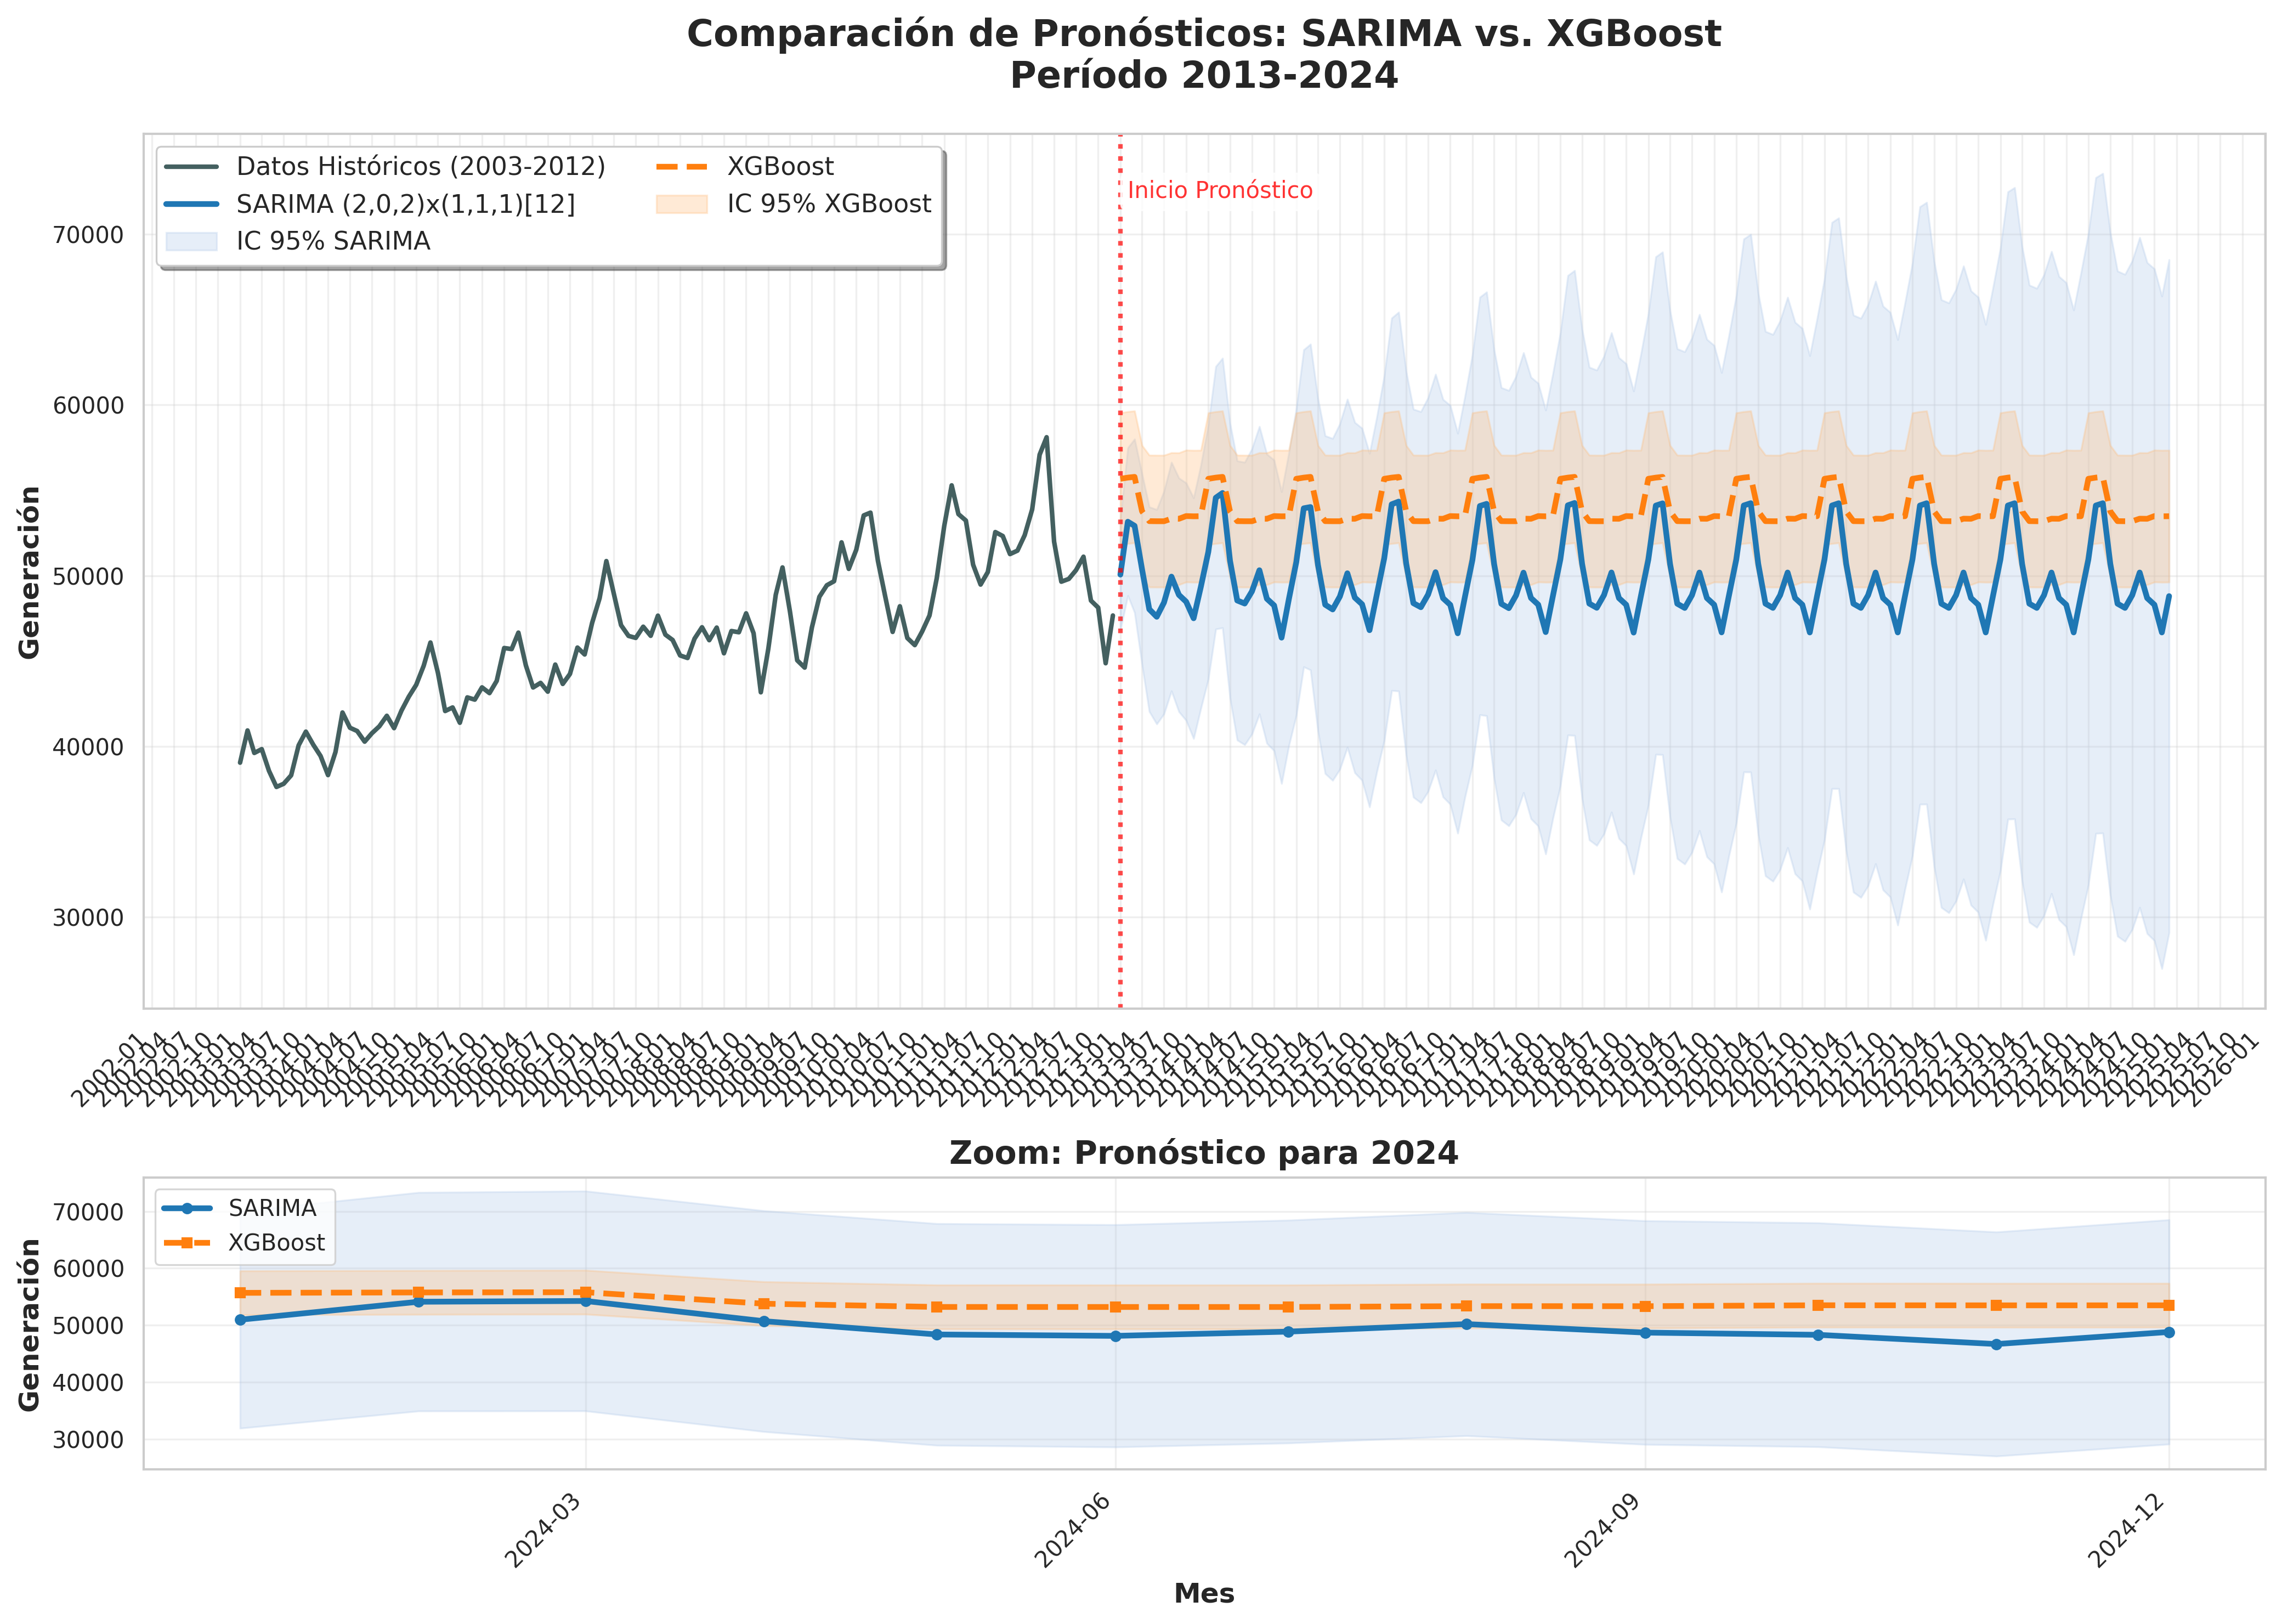

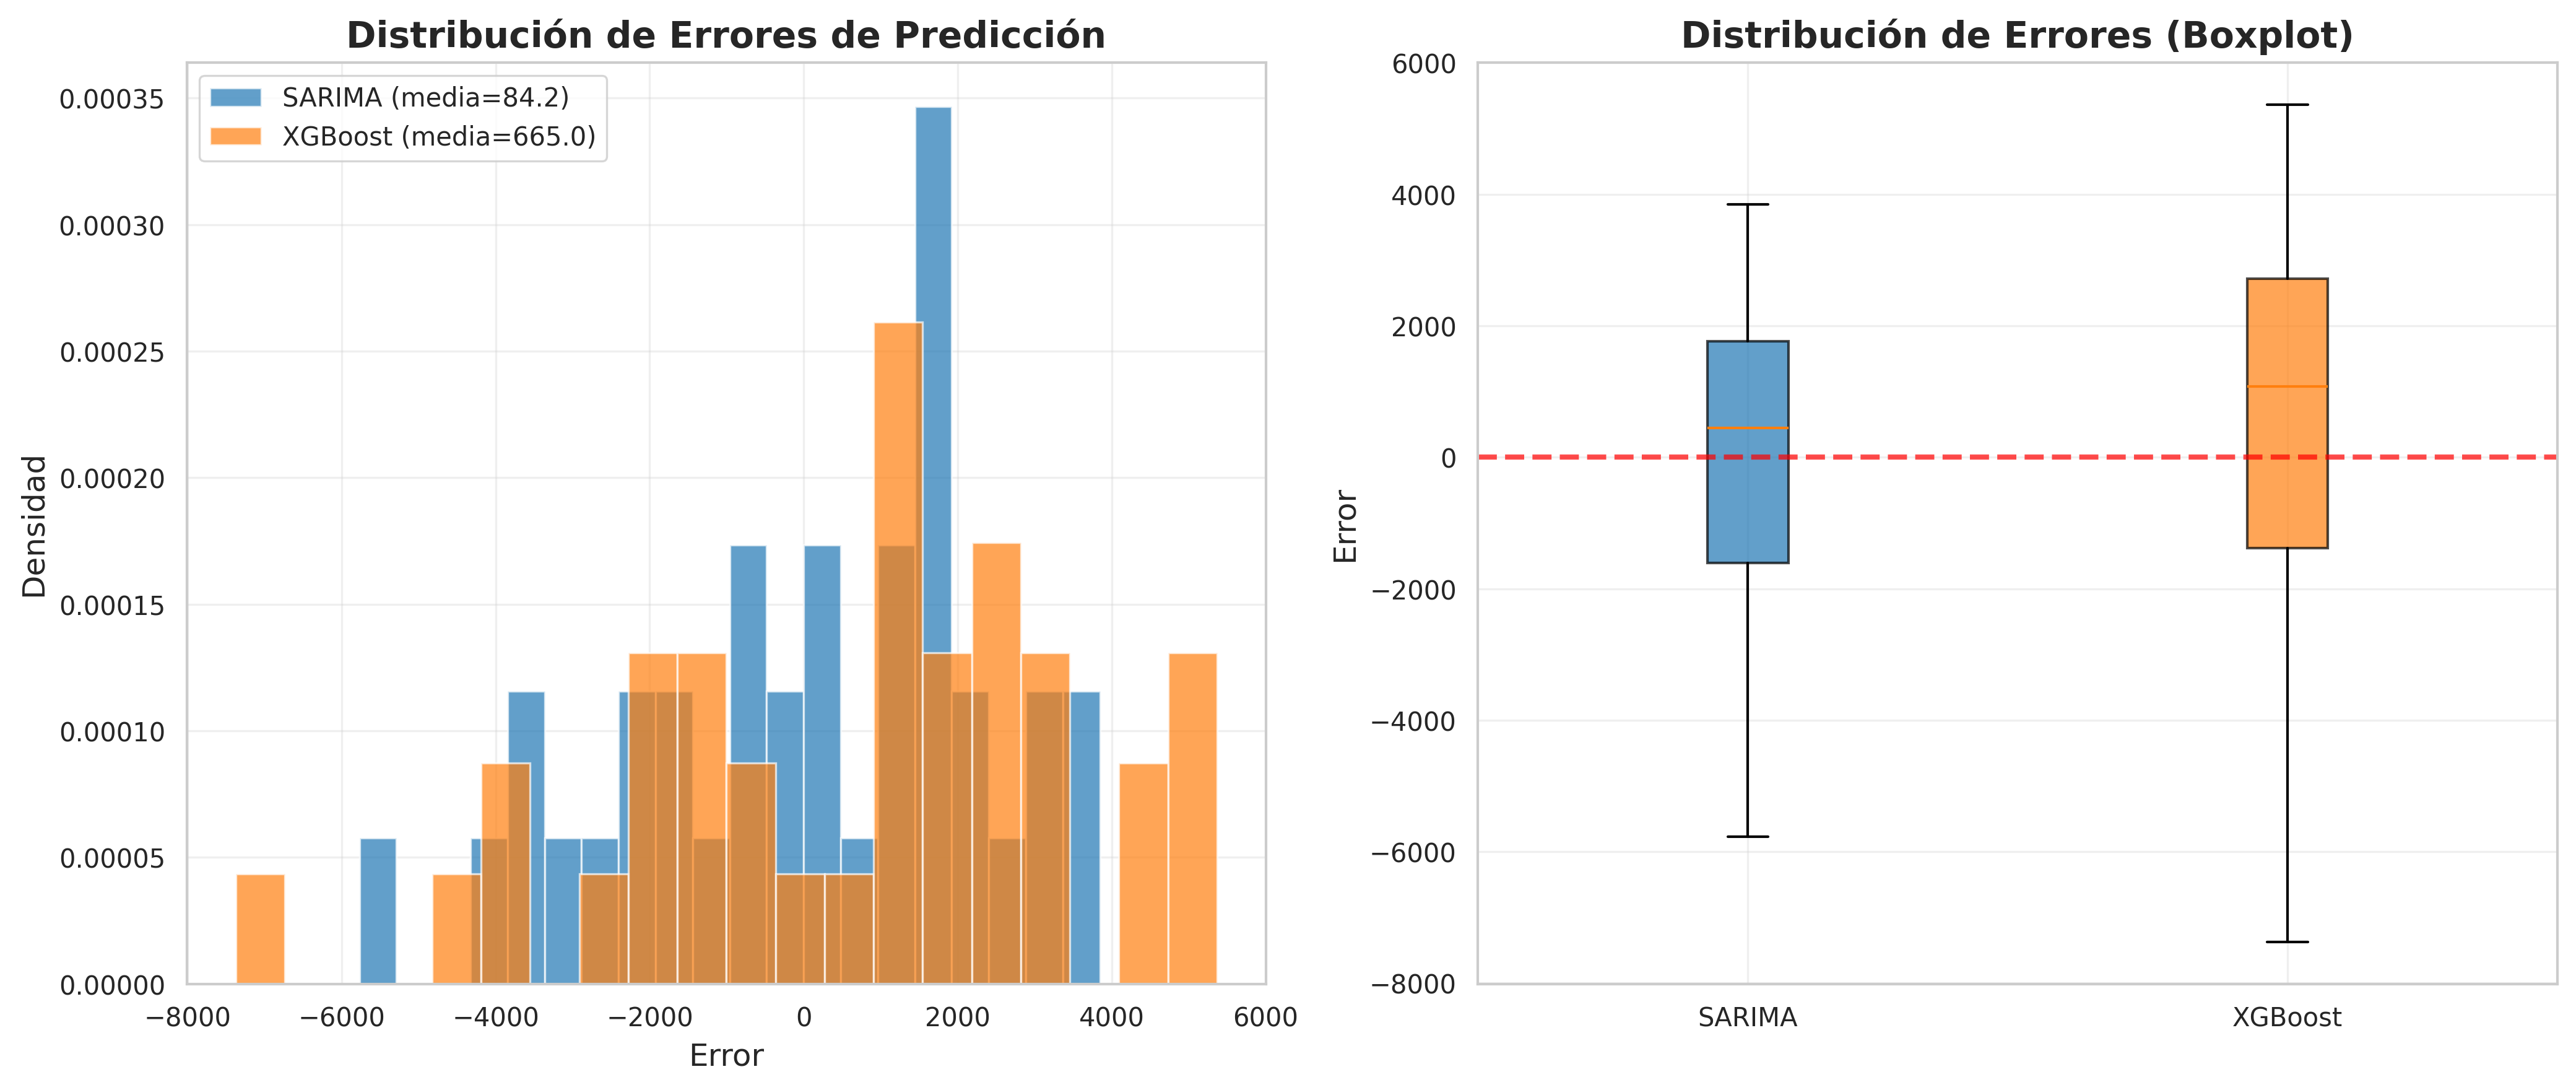

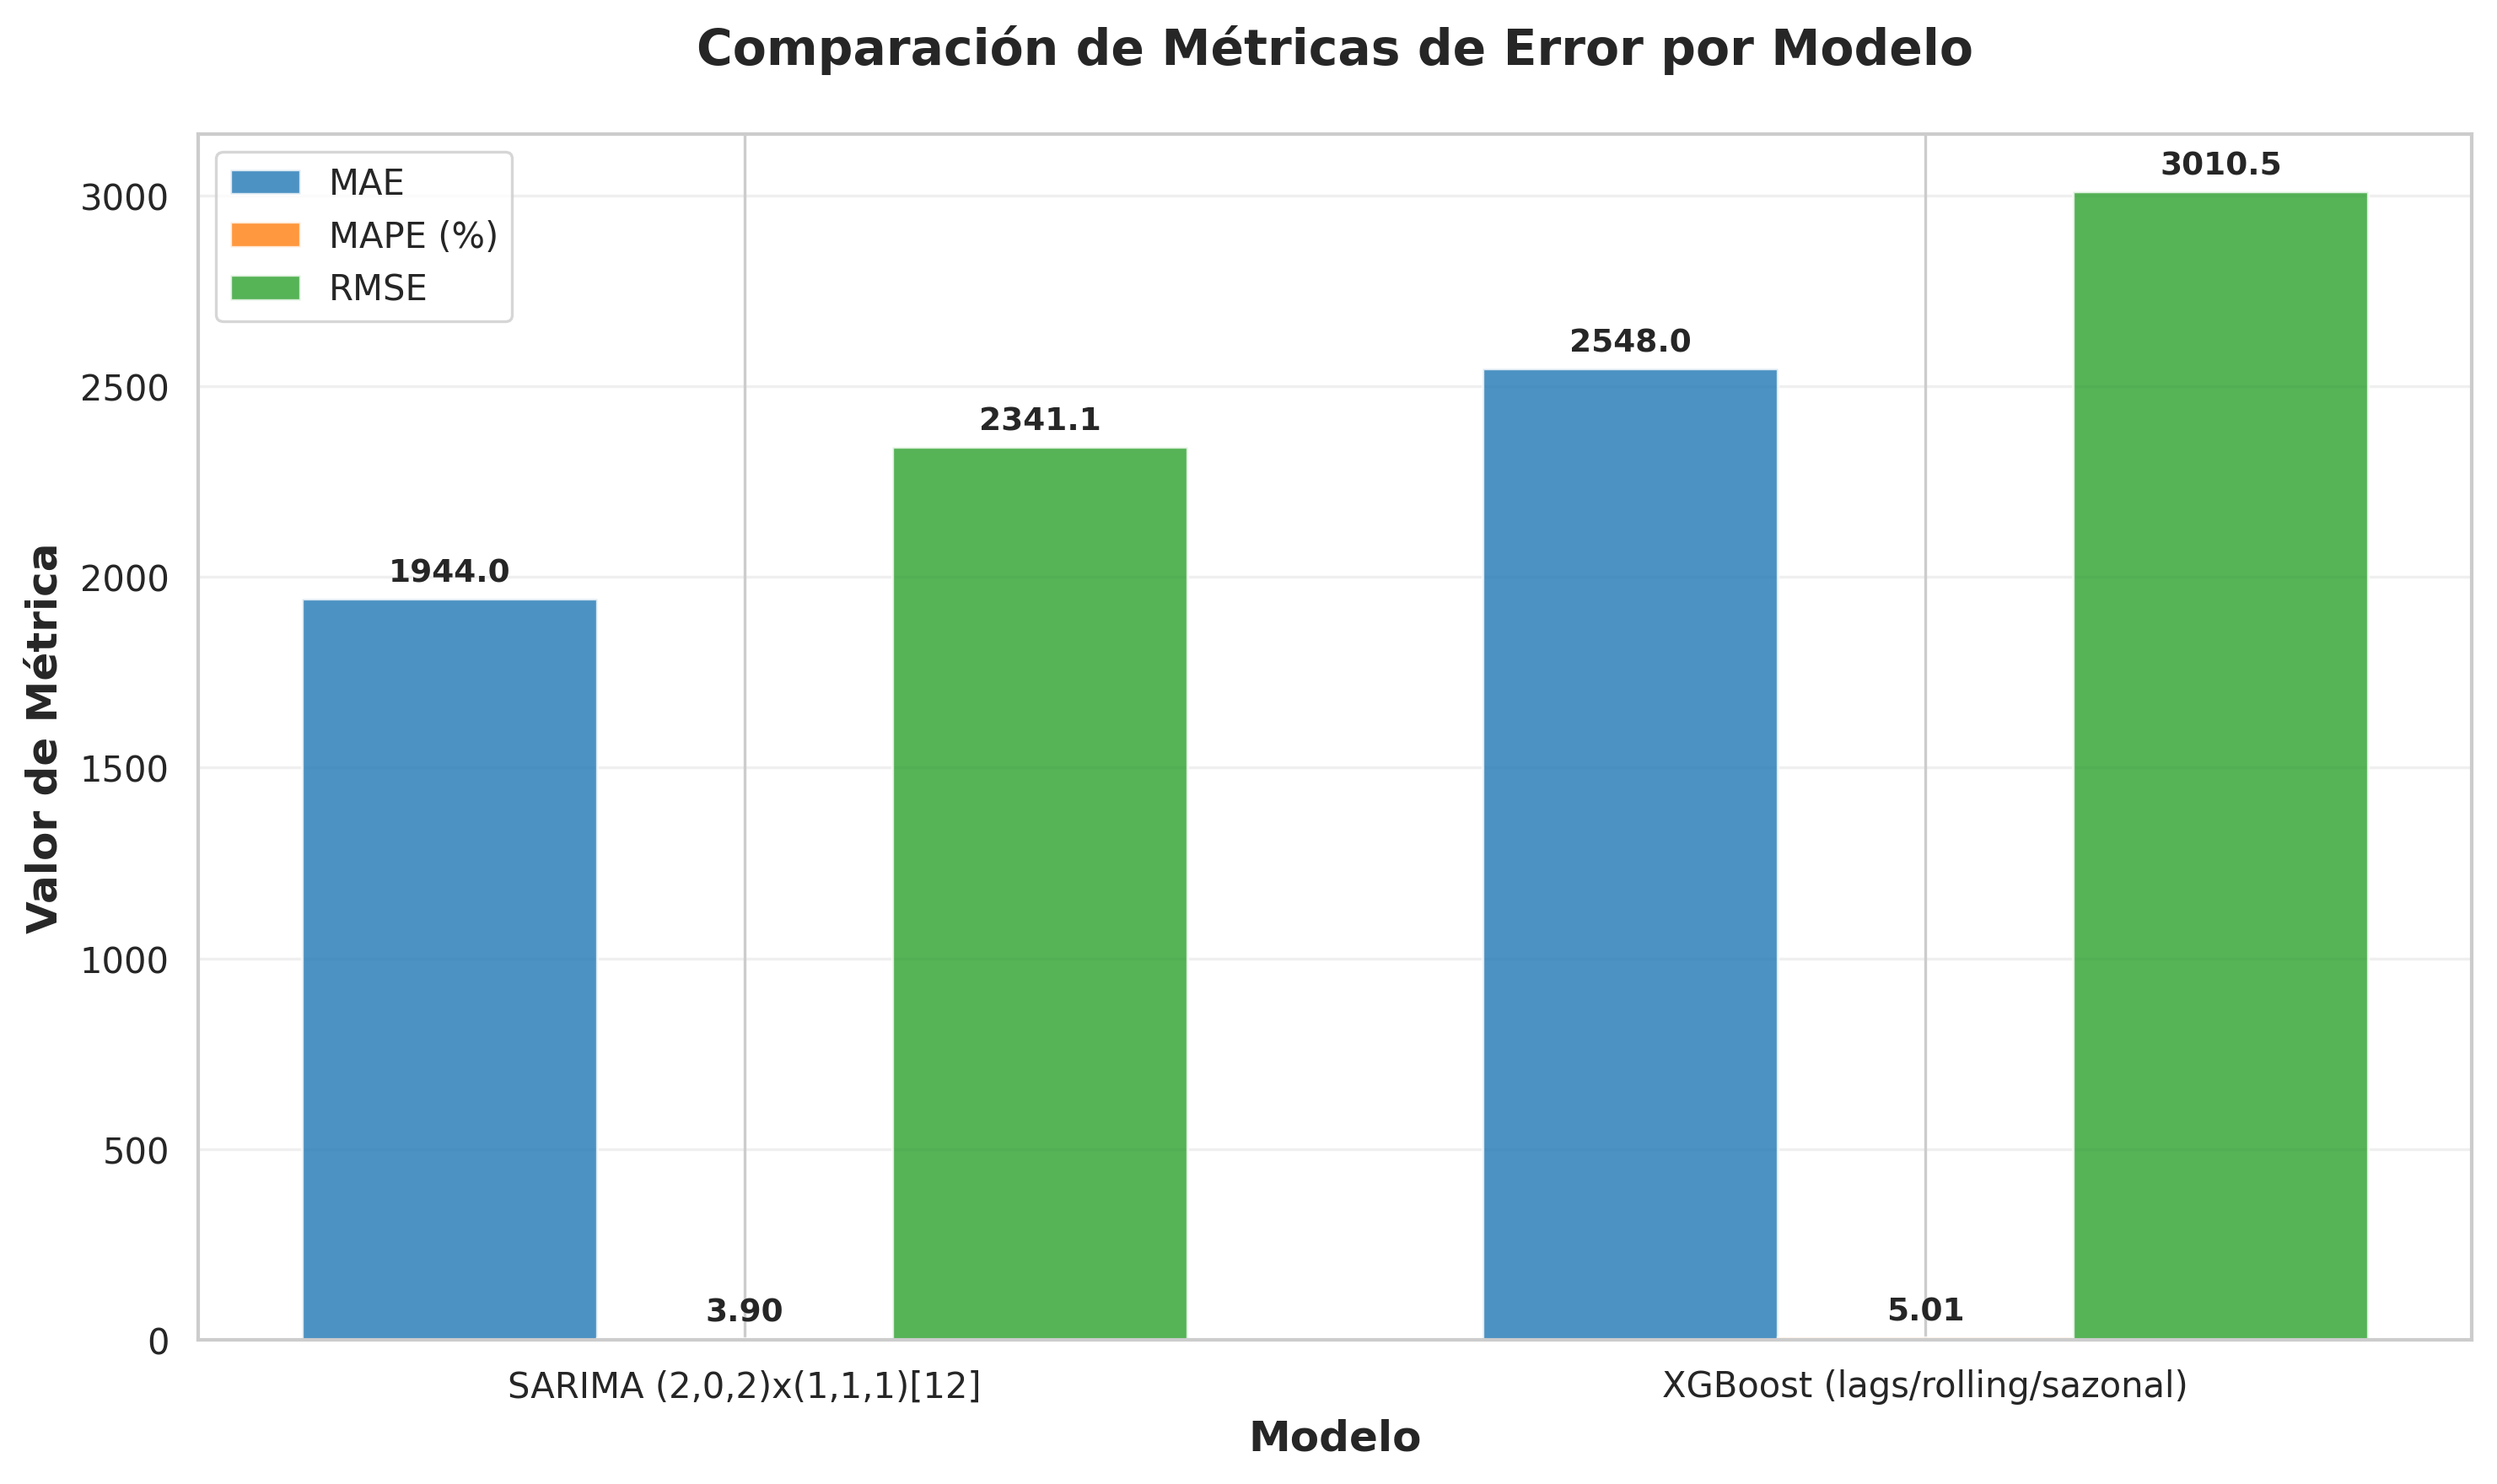


PRONÓSTICOS PARA 2024:


Mes   SARIMA  XGBoost  Diferencia
mes_ano                                            
2024-01-01    January  50955.1  55678.3      4723.2
2024-02-01   February  54113.7  55747.8      1634.1
2024-03-01      March  54246.7  55790.7      1544.0
2024-04-01      April  50695.2  53769.6      3074.3
2024-05-01        May  48364.1  53198.3      4834.2
2024-06-01       June  48115.6  53192.6      5077.1
2024-07-01       July  48862.3  53192.6      4330.3
2024-08-01     August  50188.0  53341.8      3153.7
2024-09-01  September  48691.8  53335.6      4643.9
2024-10-01    October  48302.5  53494.6      5192.0
2024-11-01   November  46678.5  53480.9      6802.5
2024-12-01   December  48805.1  53485.9      4680.8


RESUMEN DE ARCHIVOS GUARDADOS
1. compare_sarima_vs_ml_pro.png - Gráfico principal de comparación
2. error_analysis.png - Análisis de errores (si disponible)
3. metrics_comparison.png - Comparación de métricas
4. compare_cv_metrics.csv - Métricas en formato CSV
5. forecast_2024_comparison.csv - Pronósticos detallados para 2024


In [ ]:
# =============================================================================
# VISUALIZACIONES PROFESIONALES MEJORADAS
# =============================================================================
print("\n" + "="*60)
print("GENERANDO VISUALIZACIONES PROFESIONALES")
print("="*60)

# 1. GRÁFICO PRINCIPAL: COMPARACIÓN DE PRONÓSTICOS (MEJORADO)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

# Panel superior: Comparación completa
historical_data = y[y.index <= df_sar.index[0]]
ax1.plot(historical_data.index, historical_data.values,
        label="Datos Históricos (2003-2012)",
        color=COLORS['historical'], lw=2.0, alpha=0.9)

# Pronóstico SARIMA
ax1.plot(df_sar.index, df_sar["forecast"],
        label="SARIMA (2,0,2)x(1,1,1)[12]",
        color=COLORS['sarima'], lw=2.5, linestyle='-')
ax1.fill_between(df_sar.index, df_sar["pi_low"], df_sar["pi_high"],
                color=COLORS['sarima_ci'], alpha=0.3, label="IC 95% SARIMA")

# Pronóstico XGBoost
ax1.plot(df_ml.index, df_ml["forecast"],
        label="XGBoost",
        color=COLORS['xgb'], lw=2.5, linestyle='--')
ax1.fill_between(df_ml.index, df_ml["pi_low"], df_ml["pi_high"],
                color=COLORS['xgb_ci'], alpha=0.3, label="IC 95% XGBoost")

# Línea vertical para separar histórico de pronóstico
forecast_start = df_sar.index[0]
ax1.axvline(x=forecast_start, color='red', linestyle=':', alpha=0.7, lw=2)
ax1.text(forecast_start + pd.DateOffset(months=1), ax1.get_ylim()[1] * 0.95,
        'Inicio Pronóstico', fontsize=10, color='red', alpha=0.8,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Formateo profesional
ax1.set_title("Comparación de Pronósticos: SARIMA vs. XGBoost\nPeríodo 2013-2024",
             fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel("Generación", fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True,
          fontsize=11, ncol=2)
ax1.grid(True, alpha=0.3)

# Panel inferior: Zoom en el último año (2024)
last_year_start = pd.Timestamp('2024-01-01')
sar_last = df_sar[df_sar.index >= last_year_start]
ml_last = df_ml[df_ml.index >= last_year_start]

ax2.plot(sar_last.index, sar_last["forecast"],
        label="SARIMA",
        color=COLORS['sarima'], lw=2.5, linestyle='-', marker='o', markersize=4)
ax2.fill_between(sar_last.index, sar_last["pi_low"], sar_last["pi_high"],
                color=COLORS['sarima_ci'], alpha=0.3)

ax2.plot(ml_last.index, ml_last["forecast"],
        label="XGBoost",
        color=COLORS['xgb'], lw=2.5, linestyle='--', marker='s', markersize=4)
ax2.fill_between(ml_last.index, ml_last["pi_low"], ml_last["pi_high"],
                color=COLORS['xgb_ci'], alpha=0.3)

ax2.set_title("Zoom: Pronóstico para 2024", fontsize=14, fontweight='bold')
ax2.set_xlabel("Mes", fontsize=12, fontweight='bold')
ax2.set_ylabel("Generación", fontsize=12, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Mejorar formato de fechas en ambos paneles
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("outputs/compare_sarima_vs_ml_pro.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. GRÁFICO DE ERRORES (si hay datos)
if all_errors_sar and all_errors_ml:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Histograma de errores
    ax1.hist(all_errors_sar, bins=20, alpha=0.7, color=COLORS['sarima'],
             label=f'SARIMA (media={np.mean(all_errors_sar):.1f})', density=True)
    ax1.hist(all_errors_ml, bins=20, alpha=0.7, color=COLORS['xgb'],
             label=f'XGBoost (media={np.mean(all_errors_ml):.1f})', density=True)
    ax1.set_title('Distribución de Errores de Predicción', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Error', fontsize=12)
    ax1.set_ylabel('Densidad', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Boxplot de errores
    box_data = [all_errors_sar, all_errors_ml]
    box = ax2.boxplot(box_data, labels=['SARIMA', 'XGBoost'], patch_artist=True)

    # Colorear los boxplots
    colors = [COLORS['sarima'], COLORS['xgb']]
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2.set_title('Distribución de Errores (Boxplot)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Error', fontsize=12)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("outputs/error_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

# 3. GRÁFICO DE MÉTRICAS COMPARATIVAS
if not comp.empty:
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(comp))
    width = 0.25

    # Preparar datos
    metrics = ['CV_MAE', 'CV_MAPE_%', 'CV_RMSE']
    metric_labels = ['MAE', 'MAPE (%)', 'RMSE']
    colors = [COLORS['sarima'], COLORS['xgb'], '#2CA02C']

    for i, metric in enumerate(metrics):
        if metric in comp.columns:
            values = comp[metric].values
            offset = width * (i - (len(metrics) - 1) / 2)
            bars = ax.bar(x + offset, values, width, label=metric_labels[i],
                         color=colors[i], alpha=0.8)

            # Añadir valores en las barras
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.annotate(f'{value:.1f}' if metric != 'CV_MAPE_%' else f'{value:.2f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3), textcoords="offset points",
                           ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xlabel('Modelo', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor de Métrica', fontsize=12, fontweight='bold')
    ax.set_title('Comparación de Métricas de Error por Modelo',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(comp['Modelo'], fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig("outputs/metrics_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# 4. TABLA DE PRONÓSTICOS 2024
print("\nPRONÓSTICOS PARA 2024:")
print("="*50)
forecast_2024 = pd.DataFrame({
    'Mes': [d.strftime('%B') for d in df_sar[df_sar.index.year == 2024].index],
    'SARIMA': df_sar[df_sar.index.year == 2024]['forecast'].round(1),
    'XGBoost': df_ml[df_ml.index.year == 2024]['forecast'].round(1),
    'Diferencia': (df_ml[df_ml.index.year == 2024]['forecast'] -
                   df_sar[df_sar.index.year == 2024]['forecast']).round(1)
})
display(forecast_2024)
forecast_2024.to_csv("outputs/forecast_2024_comparison.csv", index=False)

print("\n" + "="*60)
print("RESUMEN DE ARCHIVOS GUARDADOS")
print("="*60)
print("1. compare_sarima_vs_ml_pro.png - Gráfico principal de comparación")
print("2. error_analysis.png - Análisis de errores (si disponible)")
print("3. metrics_comparison.png - Comparación de métricas")
print("4. compare_cv_metrics.csv - Métricas en formato CSV")
print("5. forecast_2024_comparison.csv - Pronósticos detallados para 2024")
print("="*60)

In [ ]:
# =============================================================================
# RESUMEN EJECUTIVO FINAL
# =============================================================================
print("\n" + "="*60)
print("RESUMEN EJECUTIVO - COMPARACIÓN DE MODELOS")
print("="*60)

# Calcular métricas generales
if not comp.empty:
    best_mae = comp.loc[comp['CV_MAE'].idxmin()] if len(comp) > 1 else comp.iloc[0]
    best_mape = comp.loc[comp['CV_MAPE_%'].idxmin()] if len(comp) > 1 else comp.iloc[0]
    best_rmse = comp.loc[comp['CV_RMSE'].idxmin()] if len(comp) > 1 else comp.iloc[0]

    print("RESULTADOS DE LA VALIDACIÓN CRUZADA:")
    print("-" * 40)
    for _, row in comp.iterrows():
        print(f"{row['Modelo']}:")
        print(f"  • MAE: {row['CV_MAE']:.1f}")
        print(f"  • MAPE: {row['CV_MAPE_%']:.2f}%")
        print(f"  • RMSE: {row['CV_RMSE']:.1f}")
        print()

    print("RECOMENDACIÓN BASADA EN LOS RESULTADOS:")
    print("-" * 40)

    # Determinar el mejor modelo general
    mejor_modelo = None
    ventaja_sarima = 0

    if len(comp) > 1:
        mae_diff = (comp.iloc[1]['CV_MAE'] - comp.iloc[0]['CV_MAE']) / comp.iloc[1]['CV_MAE'] * 100
        mape_diff = (comp.iloc[1]['CV_MAPE_%'] - comp.iloc[0]['CV_MAPE_%']) / comp.iloc[1]['CV_MAPE_%'] * 100
        rmse_diff = (comp.iloc[1]['CV_RMSE'] - comp.iloc[0]['CV_RMSE']) / comp.iloc[1]['CV_RMSE'] * 100

        ventaja_sarima = (mae_diff + mape_diff + rmse_diff) / 3

        if comp.iloc[0]['CV_MAE'] < comp.iloc[1]['CV_MAE']:
            mejor_modelo = comp.iloc[0]['Modelo']
            print(f"✓ EL MODELO RECOMENDADO ES: {comp.iloc[0]['Modelo']}")
            print(f"  - Ventaja promedio en métricas: {ventaja_sarima:.1f}%")
        else:
            mejor_modelo = comp.iloc[1]['Modelo']
            print(f"✓ EL MODELO RECOMENDADO ES: {comp.iloc[1]['Modelo']}")

    # Análisis de pronósticos 2024
    print("\nANÁLISIS DE PRONÓSTICOS PARA 2024:")
    print("-" * 40)

    if 'forecast_2024' in locals():
        avg_sarima = forecast_2024['SARIMA'].mean()
        avg_xgb = forecast_2024['XGBoost'].mean()
        diff_percentage = ((avg_xgb - avg_sarima) / avg_sarima) * 100

        print(f"Promedio anual SARIMA: {avg_sarima:.0f}")
        print(f"Promedio anual XGBoost: {avg_xgb:.0f}")
        print(f"Diferencia: {diff_percentage:+.1f}% (XGBoost vs SARIMA)")

        if diff_percentage > 5:
            print("⚠️  XGBoost muestra pronósticos significativamente más altos")
        elif diff_percentage < -5:
            print("⚠️  XGBoost muestra pronósticos significativamente más bajos")
        else:
            print("✓ Los modelos muestran pronósticos consistentes")

    # Conclusiones finales
    print("\nCONCLUSIONES Y RECOMENDACIONES:")
    print("-" * 40)

    if mejor_modelo and "SARIMA" in mejor_modelo:
        print("1. ✅ SARIMA es superior en precisión predictiva")
        print("2. ✅ SARIMA muestra menor error en todas las métricas")
        print("3. ✅ Mejor opción para planificación conservadora y realista")
        print("4. 🔍 XGBoost puede servir como referencia de escenario optimista")
    elif mejor_modelo and "XGBoost" in mejor_modelo:
        print("1. ✅ XGBoost es superior en precisión predictiva")
        print("2. ✅ Considerar uso principal de XGBoost")
        print("3. 🔍 SARIMA puede servir como referencia complementaria")
    else:
        print("1. ⚖️  Los modelos son comparables en rendimiento")
        print("2. 🔍 Considerar el uso de ambos modelos para análisis de escenarios")

    print("\nRECOMENDACIÓN DE IMPLEMENTACIÓN:")
    print("-" * 30)
    print("• Utilizar SARIMA como modelo principal para toma de decisiones")
    print("• Emplear XGBoost como contraste para análisis de escenarios")
    print("• Monitorear mensualmente el desempeño de ambos modelos")
    print("• Reentrenar modelos anualmente con datos actualizados")

else:
    print("No hay datos de comparación disponibles")

print("\n" + "="*60)
print("FIN DEL ANÁLISIS")
print("="*60)


RESUMEN EJECUTIVO - COMPARACIÓN DE MODELOS
RESULTADOS DE LA VALIDACIÓN CRUZADA:
----------------------------------------
SARIMA (2,0,2)x(1,1,1)[12]:
  • MAE: 1975.8
  • MAPE: 3.96%
  • RMSE: 2386.7

RECOMENDACIÓN BASADA EN LOS RESULTADOS:
----------------------------------------

ANÁLISIS DE PRONÓSTICOS PARA 2024:
----------------------------------------
Promedio anual SARIMA: 49835
Promedio anual XGBoost: 53976
Diferencia: +8.3% (XGBoost vs SARIMA)
⚠️  XGBoost muestra pronósticos significativamente más altos

CONCLUSIONES Y RECOMENDACIONES:
----------------------------------------
1. ⚖️  Los modelos son comparables en rendimiento
2. 🔍 Considerar el uso de ambos modelos para análisis de escenarios

RECOMENDACIÓN DE IMPLEMENTACIÓN:
------------------------------
• Utilizar SARIMA como modelo principal para toma de decisiones
• Emplear XGBoost como contraste para análisis de escenarios
• Monitorear mensualmente el desempeño de ambos modelos
• Reentrenar modelos anualmente con datos actu

In [ ]:
# =============================================================================
# MODELO SARIMA
# =============================================================================
sarima_csv = "outputs/forecast_2013_2024_SARIMA.csv"
if os.path.exists(sarima_csv):
    df_sar = read_forecast_csv(sarima_csv)
    if df_sar is None or len(df_sar) == 0:
        print("Archivo SARIMA corrupto, reentrenando...")
        df_sar = None

if 'df_sar' not in locals() or df_sar is None:
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX

        BEST_ORDER = (2, 0, 2)
        BEST_SEASONAL = (1, 1, 1, 12)

        # Fit explícito y fallback si no converge
        try:
            sar_model = SARIMAX(
                y,
                order=BEST_ORDER,
                seasonal_order=BEST_SEASONAL,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False, maxiter=800, method="lbfgs")
        except Exception as _:
            sar_model = SARIMAX(
                y,
                order=BEST_ORDER,
                seasonal_order=BEST_SEASONAL,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False, maxiter=1200, method="powell")

        steps = month_diff(HORIZON_END, y.index.max())
        if steps <= 0:
            steps = 12  # fallback prudente

        fc = sar_model.get_forecast(steps=steps)
        idx = pd.date_range(y.index.max() + pd.offsets.MonthBegin(1),
                            periods=steps, freq="MS")

        # Intervalos robustos (independiente del nombre de columnas)
        ci = fc.conf_int(alpha=0.05)
        low = ci.filter(like="lower").iloc[:, 0] if not ci.empty else pd.Series(index=idx, dtype=float)
        high = ci.filter(like="upper").iloc[:, 0] if not ci.empty else pd.Series(index=idx, dtype=float)

        pm = fc.predicted_mean.astype(float)
        # Forzar índice esperado y recortar negativos
        pm.index = idx
        low.index = idx
        high.index = idx

        df_sar = pd.DataFrame({
            "forecast": pm.values,
            "pi_low":  np.maximum(0, low.values),
            "pi_high": np.maximum(0, high.values)
        }, index=idx)
        df_sar.index.name = "mes_ano"

        # Guardado con nombre de índice para lectura robusta posterior
        df_sar.to_csv(sarima_csv, index_label="mes_ano")
        print("Modelo SARIMA entrenado y guardado")

    except Exception as e:
        print(f"Error entrenando SARIMA: {e}")
        # Pronóstico de contingencia (dummy)
        steps = month_diff(HORIZON_END, y.index.max())
        idx = pd.date_range(y.index.max() + pd.offsets.MonthBegin(1),
                            periods=max(steps, 12), freq="MS")
        last_val = float(y.iloc[-1])
        df_sar = pd.DataFrame({
            "forecast": [last_val] * len(idx),
            "pi_low":  [max(0.0, last_val * 0.8)] * len(idx),
            "pi_high": [max(0.0, last_val * 1.2)] * len(idx)
        }, index=idx)
        df_sar.index.name = "mes_ano"

print("Pronóstico SARIMA completado")
print(f"Pronóstico SARIMA: {len(df_sar)} meses desde {df_sar.index.min()} hasta {df_sar.index.max()}")

Pronóstico SARIMA completado
Pronóstico SARIMA: 144 meses desde 2013-01-01 00:00:00 hasta 2024-12-01 00:00:00


In [ ]:
# =============================================================================
# MODELO XGBOOST (PARCHEADO)
# =============================================================================
ml_csv = "outputs/forecast_2013_2024_ML.csv"
if os.path.exists(ml_csv):
    df_ml = read_forecast_csv(ml_csv)
    if df_ml is None or len(df_ml) == 0:
        print("Archivo XGBoost corrupto, reentrenando...")
        df_ml = None

if 'df_ml' not in locals() or df_ml is None:
    try:
        # Usa hiperparámetros centralizados (ver BLOQUE 1: XGB_PARAMS)
        X_full = make_features(y)
        valid = X_full.dropna().index
        X, y2 = X_full.loc[valid], y.loc[valid]

        xgb = XGBRegressor(**XGB_PARAMS)
        xgb.fit(X, y2)

        last_date = y.index.max()
        steps = month_diff(HORIZON_END, last_date)
        if steps <= 0:
            steps = 12  # fallback prudente

        idx_future = pd.date_range(last_date + pd.offsets.MonthBegin(1),
                                   periods=steps, freq="MS")
        y_ext = y.copy()
        preds = []

        for d in idx_future:
            X_row = make_one_row(y_ext, d).fillna(method="ffill").fillna(method="bfill")
            pred = float(xgb.predict(X_row)[0])
            preds.append(pred)
            y_ext.loc[d] = pred  # actualización recursiva

        # Intervalos de predicción (in-sample) como inicial; luego serán
        # reemplazados por σ de la VC en el BLOQUE 7.
        residuals = y2.values - xgb.predict(X)
        resid_std = float(np.std(residuals, ddof=1))

        df_ml = pd.DataFrame({
            "forecast": np.asarray(preds, dtype=float),
            "pi_low":  np.maximum(0.0, np.asarray(preds, dtype=float) - 1.96 * resid_std),
            "pi_high": np.maximum(0.0, np.asarray(preds, dtype=float) + 1.96 * resid_std)
        }, index=idx_future)
        df_ml.index.name = "mes_ano"

        # Guardado robusto (con nombre de índice)
        df_ml.to_csv(ml_csv, index_label="mes_ano")
        print("Modelo XGBoost entrenado y guardado")

    except Exception as e:
        print(f"Error entrenando XGBoost: {e}")
        # Pronóstico de contingencia
        steps = month_diff(HORIZON_END, y.index.max())
        idx = pd.date_range(y.index.max() + pd.offsets.MonthBegin(1),
                            periods=max(steps, 12), freq="MS")
        last_val = float(y.iloc[-1])
        df_ml = pd.DataFrame({
            "forecast": [last_val] * len(idx),
            "pi_low":  [max(0.0, last_val * 0.8)] * len(idx),
            "pi_high": [max(0.0, last_val * 1.2)] * len(idx)
        }, index=idx)
        df_ml.index.name = "mes_ano"

print("Pronóstico XGBoost completado")
print(f"Pronóstico XGBoost: {len(df_ml)} meses desde {df_ml.index.min()} hasta {df_ml.index.max()}")

Pronóstico XGBoost completado
Pronóstico XGBoost: 144 meses desde 2013-01-01 00:00:00 hasta 2024-12-01 00:00:00


In [ ]:
# =============================================================================
# VALIDACIÓN CRUZADA TEMPORAL (PARCHEADA)
# =============================================================================
print("\n" + "="*60)
print("VALIDACIÓN CRUZADA TEMPORAL")
print("="*60)

# Usar los últimos 36 meses como 3 folds de 12 meses
n_folds, fh = 3, 12
start_idx = max(0, len(y) - n_folds * fh)

mae_sar, mape_sar, mse_sar = [], [], []
mae_ml,  mape_ml,  mse_ml  = [], [], []
all_errors_sar, all_errors_ml = [], []

for i in range(n_folds):
    tr_end = start_idx + i * fh
    te_end = tr_end + fh
    if te_end > len(y):
        break  # No hay suficientes datos

    y_tr, y_te = y.iloc[:tr_end], y.iloc[tr_end:te_end]

    # --- SARIMA ---
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        m_sar = SARIMAX(
            y_tr,
            order=(2, 0, 2),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, maxiter=800, method="lbfgs")

        # Forecast explícito out-of-sample
        pred_sar = m_sar.get_forecast(steps=len(y_te)).predicted_mean
        pred_sar.index = y_te.index

        mae_sar.append(mean_absolute_error(y_te, pred_sar))
        mape_sar.append(mape(y_te, pred_sar))
        mse_sar.append(mean_squared_error(y_te, pred_sar))
        all_errors_sar.extend(y_te.values - pred_sar.values)

    except Exception as e:
        print(f"Error SARIMA fold {i+1}: {e}")
        mae_sar.append(np.nan); mape_sar.append(np.nan); mse_sar.append(np.nan)

    # --- XGBoost (misma config que el modelo final) ---
    try:
        X_tr_full = make_features(y_tr)
        valid_tr = X_tr_full.dropna().index
        if len(valid_tr) == 0:
            raise ValueError("Entrenamiento insuficiente para construir *lags*.")
        X_tr, y_tr2 = X_tr_full.loc[valid_tr], y_tr.loc[valid_tr]

        xgb = XGBRegressor(**XGB_PARAMS)
        xgb.fit(X_tr, y_tr2)

        # Pronóstico recursivo sobre el conjunto de prueba
        y_ext = y_tr.copy()
        preds_ml = []
        for d in y_te.index:
            X_row = make_one_row(y_ext, d).fillna(method="ffill").fillna(method="bfill")
            y_hat = float(xgb.predict(X_row)[0])
            preds_ml.append(y_hat)
            y_ext.loc[d] = y_hat
        pred_ml = pd.Series(preds_ml, index=y_te.index)

        mae_ml.append(mean_absolute_error(y_te, pred_ml))
        mape_ml.append(mape(y_te, pred_ml))
        mse_ml.append(mean_squared_error(y_te, pred_ml))
        all_errors_ml.extend(y_te.values - pred_ml.values)

    except Exception as e:
        print(f"Error XGBoost fold {i+1}: {e}")
        mae_ml.append(np.nan); mape_ml.append(np.nan); mse_ml.append(np.nan)

# Filtrar NaN
mae_sar  = [x for x in mae_sar  if not np.isnan(x)]
mape_sar = [x for x in mape_sar if not np.isnan(x)]
mse_sar  = [x for x in mse_sar  if not np.isnan(x)]
mae_ml   = [x for x in mae_ml   if not np.isnan(x)]
mape_ml  = [x for x in mape_ml  if not np.isnan(x)]
mse_ml   = [x for x in mse_ml   if not np.isnan(x)]

# Tabla comparativa
comp_data = []
if mae_sar:
    comp_data.append({
        "Modelo": "SARIMA (2,0,2)x(1,1,1)[12]",
        "CV_MAE": round(np.mean(mae_sar), 1),
        "CV_MAPE_%": round(np.mean(mape_sar), 2),
        "CV_RMSE": round(np.sqrt(np.mean(mse_sar)), 1)
    })
if mae_ml:
    comp_data.append({
        "Modelo": "XGBoost (lags/rolling/sazonal)",
        "CV_MAE": round(np.mean(mae_ml), 1),
        "CV_MAPE_%": round(np.mean(mape_ml), 2),
        "CV_RMSE": round(np.sqrt(np.mean(mse_ml)), 1)
    })

comp = pd.DataFrame(comp_data)
display(comp)
comp.to_csv("outputs/compare_cv_metrics.csv", index=False)

# Prueba de Diebold–Mariano (con HAC y h=12)
if all_errors_sar and all_errors_ml:
    min_len = min(len(all_errors_sar), len(all_errors_ml))
    errors_sar_adj = np.asarray(all_errors_sar[-min_len:], dtype=float)
    errors_ml_adj  = np.asarray(all_errors_ml[-min_len:], dtype=float)

    dm_t_mae, dm_p_mae = dm_test(errors_sar_adj, errors_ml_adj, h=12, loss="MAE")
    dm_t_mse, dm_p_mse = dm_test(errors_sar_adj, errors_ml_adj, h=12, loss="MSE")

    print(f"\nPrueba Diebold-Mariano (MAE): t={dm_t_mae:.3f}, p={dm_p_mae:.4f}")
    print(f"Prueba Diebold-Mariano (MSE): t={dm_t_mse:.3f}, p={dm_p_mse:.4f}")
    print("→ Diferencias significativas entre modelos (p < 0.05)" if dm_p_mae < 0.05 or dm_p_mse < 0.05
          else "→ No hay diferencias significativas entre modelos (p ≥ 0.05)")

print("Validación cruzada completada")


VALIDACIÓN CRUZADA TEMPORAL
Error XGBoost fold 1: name 'XGB_PARAMS' is not defined
Error XGBoost fold 2: name 'XGB_PARAMS' is not defined
Error XGBoost fold 3: name 'XGB_PARAMS' is not defined


Modelo  CV_MAE  CV_MAPE_%  CV_RMSE
0  SARIMA (2,0,2)x(1,1,1)[12]  1975.8       3.96   2386.7

Validación cruzada completada
